# Background and Context

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

# Objective

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

## Data Description

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

## Data Dictionary

* **CustomerId:** Unique ID which is assigned to each customer
* **Surname:** Last name of the customer 
* **CreditScore:** It defines the credit history of the customer.  
* **Geography:** A customer’s location    
* **Gender:** It defines the Gender of the customer   
* **Age:** Age of the customer     
* **Tenure:** Number of years for which the customer has been with the bank
* **NumOfProducts:** It refers to the number of products that a customer has purchased through the bank.
* **Balance:** Account balance
* **HasCrCard:** It is a categorical variable that decides whether the customer has a credit card or not.
* **EstimatedSalary:** Estimated salary 
* **isActiveMember:** It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
* **Excited:** It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values   
    - 0=No ( Customer did not leave the bank )  
    - 1=Yes ( Customer left the bank )  

In [313]:
# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # I prefer when all columns are displayed

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True) #to make things look a little prettier

# Libraries to split data, and process data 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import tensorflow, keras and it's models and layers. Also import keras tuner and Random Search
import tensorflow as tf
from tensorflow import keras
import keras # importing keras library
from keras.models import Sequential  # importing the Sequential Model
from keras.layers import Dense       # importing Dense layer
import keras_tuner as kt 
from keras_tuner import RandomSearch

# import libraries to help evaluate our models
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

# import SMOTE to create samples to balance the target classes
from imblearn.over_sampling import SMOTE

In [314]:
print(tf.__version__)

2.6.0


# Reading Dataset and Feature Elimination
*Read the dataset properly - Print the overview of the data (statistical summary, shape, info, etc) - Eliminate the unique features from the dataset with proper reasoning*

In [315]:
df = pd.read_csv('bank.csv') # read data from csv file
df # Look at head and tail of data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


* Our data is 10000 rows and 14 columns.
* Right away we can see that RowNumber and CustomerId are unique features, i.e. they don't repeat and therefore don't have a pattern to them. We can likely delete these columns, but we will check them first.
* We can also likely drop Surname as it's a categorical data but there are likely too many categories to be useful. 

We will now look at the number of unique entires

In [316]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

* We can see that there are 10000 entries for both RowNumber and CustomerId, so we will drop those columns.
* There are also 2932 different values for Surname, far too many to work with. It is also highly likely that there is not a pattern between someone's name and the target variable. We will also drop this column
* It looks like there are only 3 Geographies. We have seen from the head and tail of the data that these are: Germany, France and Spain. So there are no strange values in this column.
* There are 2 genders, so there are no strange values in this column either.
* Our binary categories: HasCrCard, IsActiveMember and Exited all have 2 values, so there is likely no extra processing to do there - good news!

In [317]:
# Drop the unnecessary columns
df_original = df.copy()
df.drop(['RowNumber','CustomerId','Surname'], inplace=True, axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [318]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


* Most of the columns are numerical in nature, either integers or floats.
* The Gender and Geogrphy columns are objects. We will encode these before we run our models.

In [319]:
# Check the data for null values
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

* There are no null values, we will not need to do any imputting - more good news!

In [320]:
df.duplicated().value_counts()

False    10000
dtype: int64

* There are no duplicated rows in the data set.

In [321]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


**Observations**  
* Most of the continuous features appear to be normally distributed, as their median (50%) and mean are close. This is true for CreditScore, Age, Tenure and Estimated Salary.
* Balance appears to have a right skew, likely due to some outliers on the high side. We can see that the max value is about double the 75% value.

In [322]:
df.describe(include=['object']).T

,count,unique,top,freq
Geography,10000,3,France,5014
Gender,10000,2,Male,5457


* Just over half of the customers are male.
* Over half the customers are from France.

In [323]:
# Let's get a deeper break down of the categorical variables with object type
cols_cat= df.select_dtypes(['object'])
for i in cols_cat.columns:
    print('Unique values in',i, 'are :')
    print(cols_cat[i].value_counts(dropna=False))
    print('*'*50)

Unique values in Geography are :
France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
**************************************************
Unique values in Gender are :
Male      5457
Female    4543
Name: Gender, dtype: int64
**************************************************


* Just over half the Geography entries are France 50.14%. The other half is spread evenly between Germany 25.09% and Spain 24.77%
* There are slightly more males 54.57% than females 45.43%

In [324]:
df.shape

(10000, 11)

* We dropped 3 unnecessary columns.
* No edits to the rows were performed.
* The shape of the data frame after editing is 10,000 rows by 11 columns.

# Perform an Exploratory Data Analysis on the data
*Checked whether the dataset is balanced or not - Bivariate analysis - Use appropriate visualizations to identify the patterns and insights - Any other exploratory deep dive*

In [325]:
# While doing univariate analysis of numerical variables we want to study their central tendency and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical variable.
# This function takes the numerical column as the input and returns the boxplots and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(x=feature, kde=F, ax=ax_hist2, bins=bins,palette="winter") if bins else sns.histplot(x=feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

In [326]:
#For some variables, it doesn't make sense to plot the full histogram boxplot
# for these we will plot a bar plot with percentage on the bar

# Write some code to plot categorical variables with the percentage on the bar.
def perc_on_bar(feature):
    """
    plot
    feature: categorical feature
    the function won't work if a column is passed in the hue parameter
    """
    # Creating a countplot for the feature
    sns.set(rc={"figure.figsize": (10, 5)})
    ax = sns.countplot(x=feature, data=df)

    total = len(feature)  # length of the column
    for p in ax.patches:
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.1  # width of the plot
        y = p.get_y() + p.get_height()  # hieght of the plot
        ax.annotate(percentage, (x, y), size=14)  # annotate the percantage

    plt.show()  # show the plot

# Univariate Analysis

#### Observations on CreditScore

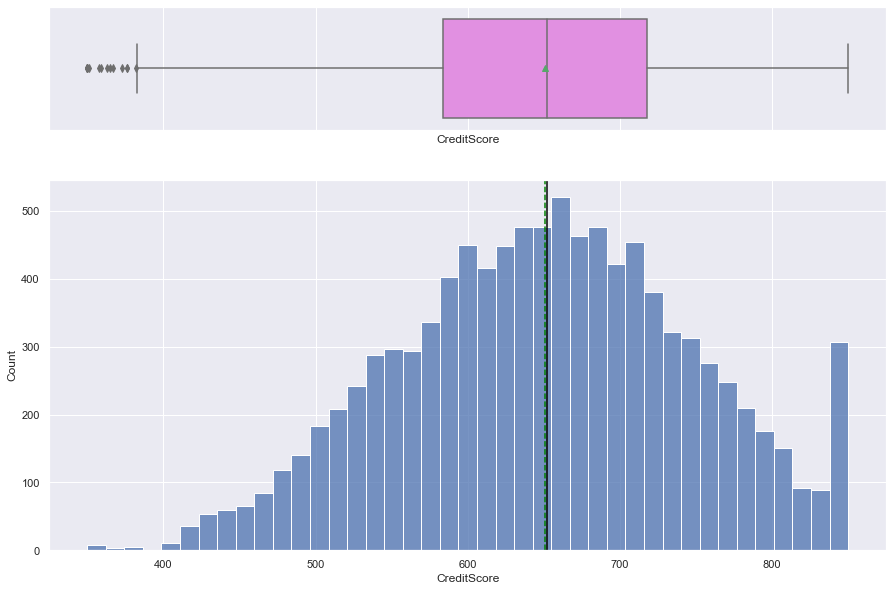

In [327]:
histogram_boxplot(df['CreditScore'])

* The distribution is *mostly* normal. The mean and median are very close.
* The data are slightly left-skewed, there are some outlying points on the low side of the range.
* There is a secondary mode at the maximum value. The maximum credit score possible in the U.S. is 850. That is the maximum that we see here. I'm pretty sure that European countries do not have the same system but I don't know the origin of the data, it could be a U.S. bank, the data could be completely synthetic. I'm going to assume these values are real, i.e., there are many customers with a perfect credit score.

In [312]:
# Let's look at the customers on the low side
df[df['CreditScore']<400]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
7,376,29,4,115046.74,4,1,0,119346.88,1,1,0,0
942,376,46,6,0.00,1,1,0,157333.69,1,0,0,0
1193,363,28,6,146098.43,3,1,0,100615.14,1,0,1,0
1201,399,46,2,127655.22,1,1,0,139994.68,1,1,0,1
1405,359,44,6,128747.69,1,1,0,146955.71,1,0,0,0
1631,350,54,1,152677.48,1,1,1,191973.49,1,0,1,1
1838,350,39,0,109733.20,2,0,0,123602.11,1,1,0,1
1962,358,52,8,143542.36,3,1,0,141959.11,1,0,1,0
2473,351,57,4,163146.46,1,1,0,169621.69,1,1,0,0
2579,365,30,0,127760.07,1,1,0,81537.85,1,1,0,1


* There are 19 customers with a credit score below 400. ALL of them have exited.
* There are some other commonalities between these customers but not strict rules. For example most of the customers above have a Balance greater than zero and have a credit card... but there are some who don't.
* The data are likely real. We will see how the data interact with the other variables when we do our bivariate analysis before we decide to treat them.

In [168]:
# There are many customers with a credit score of 850, so let's just look as some summary statistics.
df[df['CreditScore']==850.00].describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,233.0,850.000000,0.000000,850.00,850.00,850.00,850.00,850.00
Age,233.0,38.918455,10.572298,19.00,32.00,37.00,43.00,81.00
Tenure,233.0,4.819742,2.856050,0.00,2.00,5.00,7.00,10.00
Balance,233.0,78718.993219,61529.896588,0.00,0.00,98488.08,126776.30,212778.20
NumOfProducts,233.0,1.515021,0.573094,1.00,1.00,1.00,2.00,4.00
HasCrCard,233.0,0.699571,0.459432,0.00,0.00,1.00,1.00,1.00
IsActiveMember,233.0,0.549356,0.498629,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,233.0,95919.323777,61941.677679,705.18,40313.47,92053.75,152996.89,199775.67
Exited,233.0,0.184549,0.388767,0.00,0.00,0.00,0.00,1.00


* There are 233 customers with a perfect credit score

#### Observations on Age

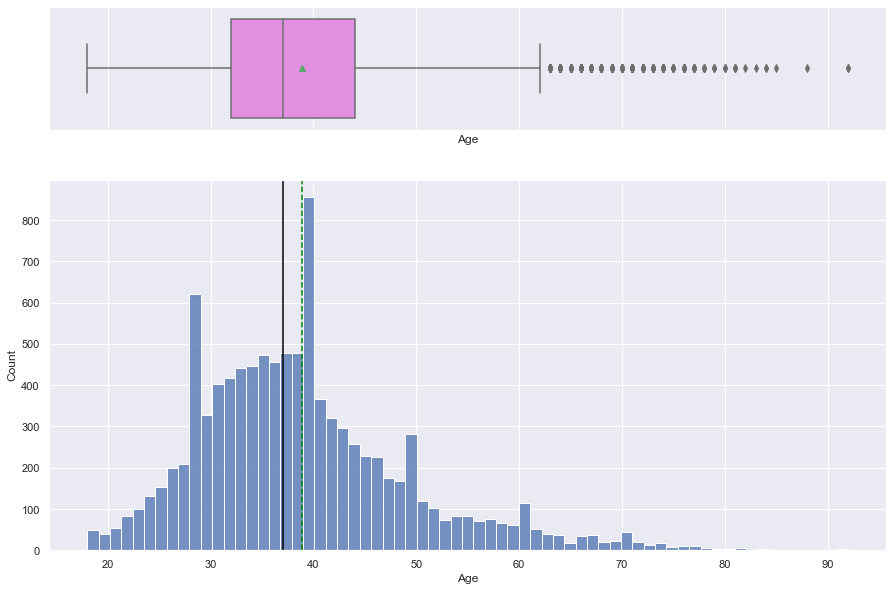

In [169]:
histogram_boxplot(df['Age'])

* Data are slightly skewed to the right. The mean is slightly higher than the median. 
* Data conforms to our expectations, there are some people who live longer than others, however people with very long lifespans are the exception to the rule.

In [170]:
# Let's look at the oldest 5 customers
df.sort_values(by='Age').tail()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3387,537,Germany,Male,84,8,92242.34,1,1,1,186235.98,0
3033,787,France,Female,85,10,0.00,2,1,1,116537.96,0
2458,513,Spain,Male,88,10,0.00,2,1,1,52952.24,0
6759,705,France,Male,92,1,126076.24,2,1,1,34436.83,0
6443,753,France,Male,92,3,121513.31,1,0,1,195563.99,0


* There are two customers with an age of 92, this age is not unreasonable and there is not a large gap between these customers and the customers with ages slighlty below. 
* There is not a real pattern with the advanced aged customers: There is a large range of Balance, Estimated Salary and Tenure values. They all appear to be active members that have not exited.
* For now, I will treat these values as real and not condition them.

#### Observations on Balance

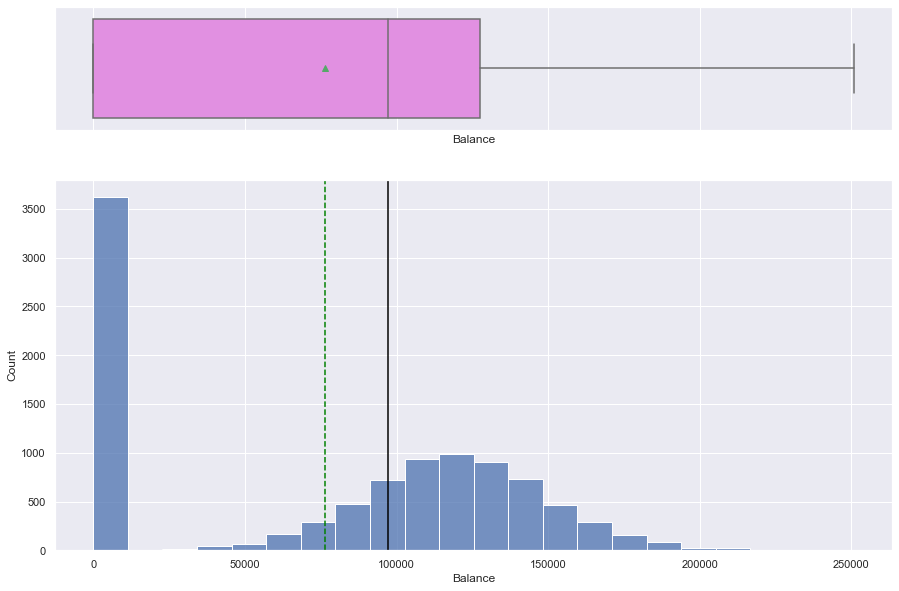

In [171]:
histogram_boxplot(df['Balance'])

* This column is bimodal. The majority of the customers have a zero balance.
* For customers that do not have a zero balance, the distribution appears to be normal.

In [172]:
# Let's look at the stats for customers with a non-zero balance
non_zero_balance_df = df[df['Balance']!=0]
non_zero_balance_df['Balance'].describe()

count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: Balance, dtype: float64

* There are 6383 customers with a non-zero balance.
* The data are normally distributed with the mean approximately equal to the median.
* For customers with a non-zero balance, the range of values is 3,769 - 250,898

#### Observations on Estimated Salary

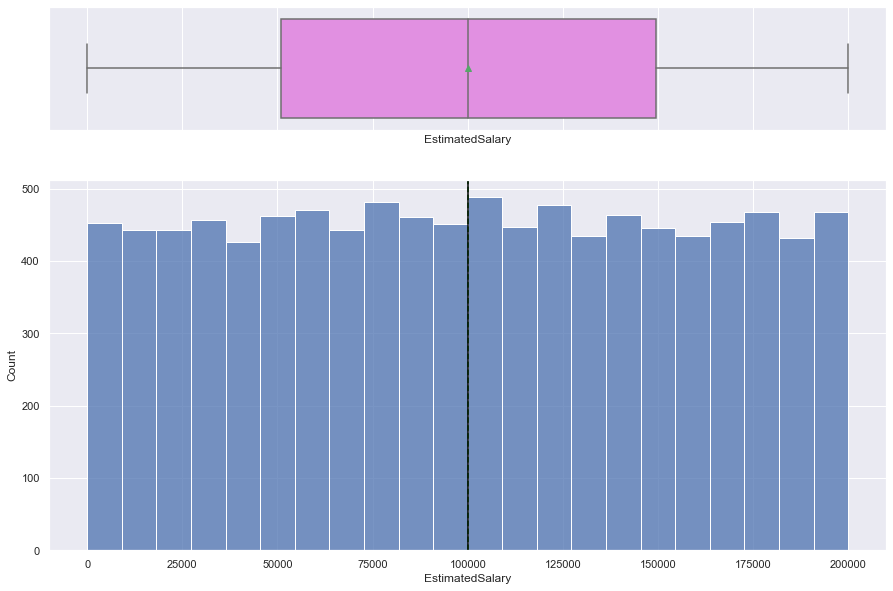

In [173]:
histogram_boxplot(df['EstimatedSalary'])

* The data are uniform and almost perfectly symetrical about the mean and median.

#### Observations on Tenure

For this feature and the following features, it does not make sense to plot a histogram and box plot due to the small range of values per feature. For this reason, we will use the percentage on bar plots to analyze these data

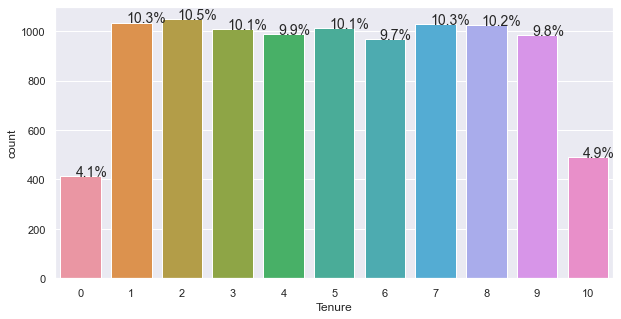

In [174]:
perc_on_bar(df['Tenure'])

* The distribution is mostly uniform between 1-9, with "tails" on each side where the number of customers is roughly half that of the values in the 1-9 range. 

#### Observations on NumOfProducts

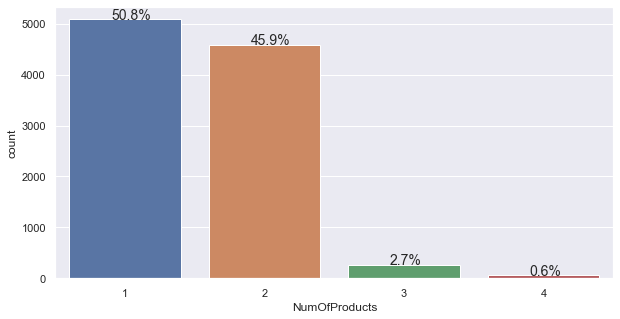

In [175]:
perc_on_bar(df['NumOfProducts'])

* The vast majority of customers have 1 or 2 products with the bank.
* Roughtly 3.3% of customers have more than 2 products with the bank. We will look at these data with repect to our target class in the next section and consider clipping the data if there is little difference in Exited customers in the 3 and 4 categories.

#### Observations on HasCrCard

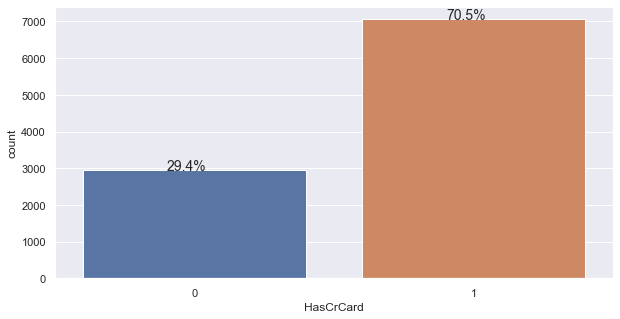

In [176]:
perc_on_bar(df['HasCrCard'])

* Approximately 30% of customers do not have a credit card, the other 70% do have a credit card.

#### Observations on IsActiveMember

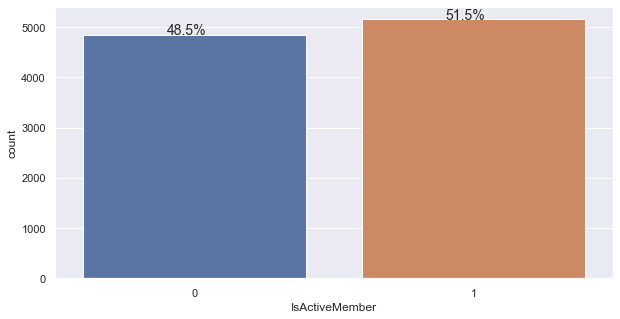

In [177]:
perc_on_bar(df['IsActiveMember'])

* About half of the customers are active members. The split is 48.5% non active, 51.5% active.

#### Observations on Exited

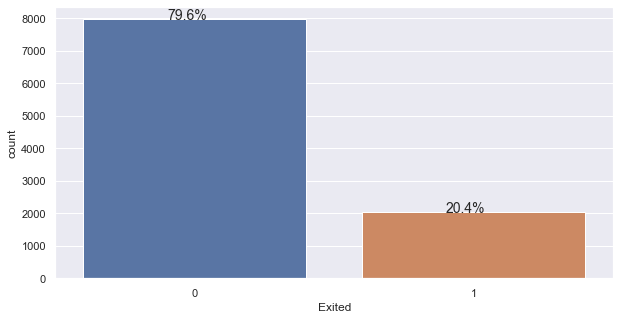

In [178]:
perc_on_bar(df['Exited'])

* This is our target variable.
* 80% of customers have not left the bank, 20% of customers have left the bank (within the last 6 months).

#### Observations on Gender

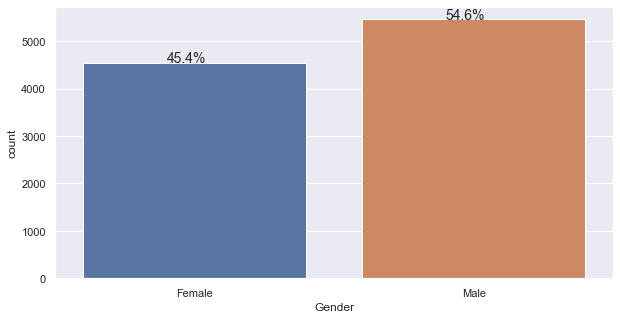

In [179]:
perc_on_bar(df['Gender'])

* Slightly more of the customers in the data frame are male. The split is 55% Male, 45% Female.

#### Observations on Geography

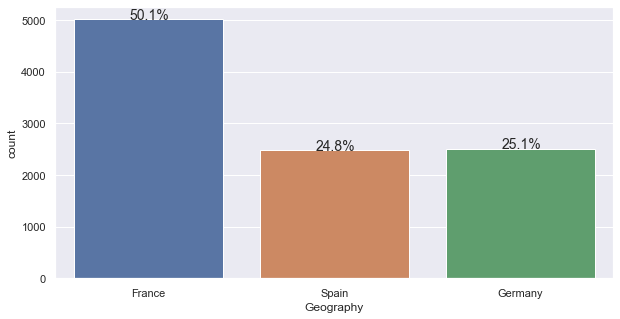

In [180]:
perc_on_bar(df['Geography'])

* Approximately half the customers fall into the France class. The other half of the data is split evenly between Spain and Germany.

# Bivariate Analysis

In this section we will look at the relationships between variables, with a focus on the relationship between each variable and the target class. We will start by looking at a correlation heat map and pairplots.

### Cross Correlation Heat Map

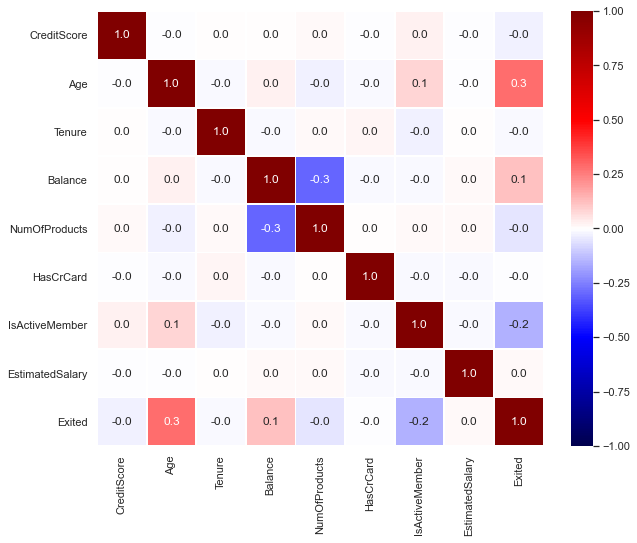

In [181]:
# Let's start by looking for correlation in the data
corr = df.corr()

sns.set(font_scale=1)
fix, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr, 
            cmap='seismic', annot=True,fmt=".1f",vmin=-1, vmax=1, center= 0,
            square=False, linewidths=.7);

#### Observations
* For almost all entries in the heat map, the cross correlation is zero or close to zero. This tells us that there are no strong *linear* relationships between the variables in the data.
* We can see that there is a very slight correlation between Age and Exited - as Age increases Exited also increases.
* There is also a very slight negative correlation between NumOfProducts and Balance, although as we will see on the following pair plots, the relationship is very weak.


### Pair Plots, Coloured by Target Variable

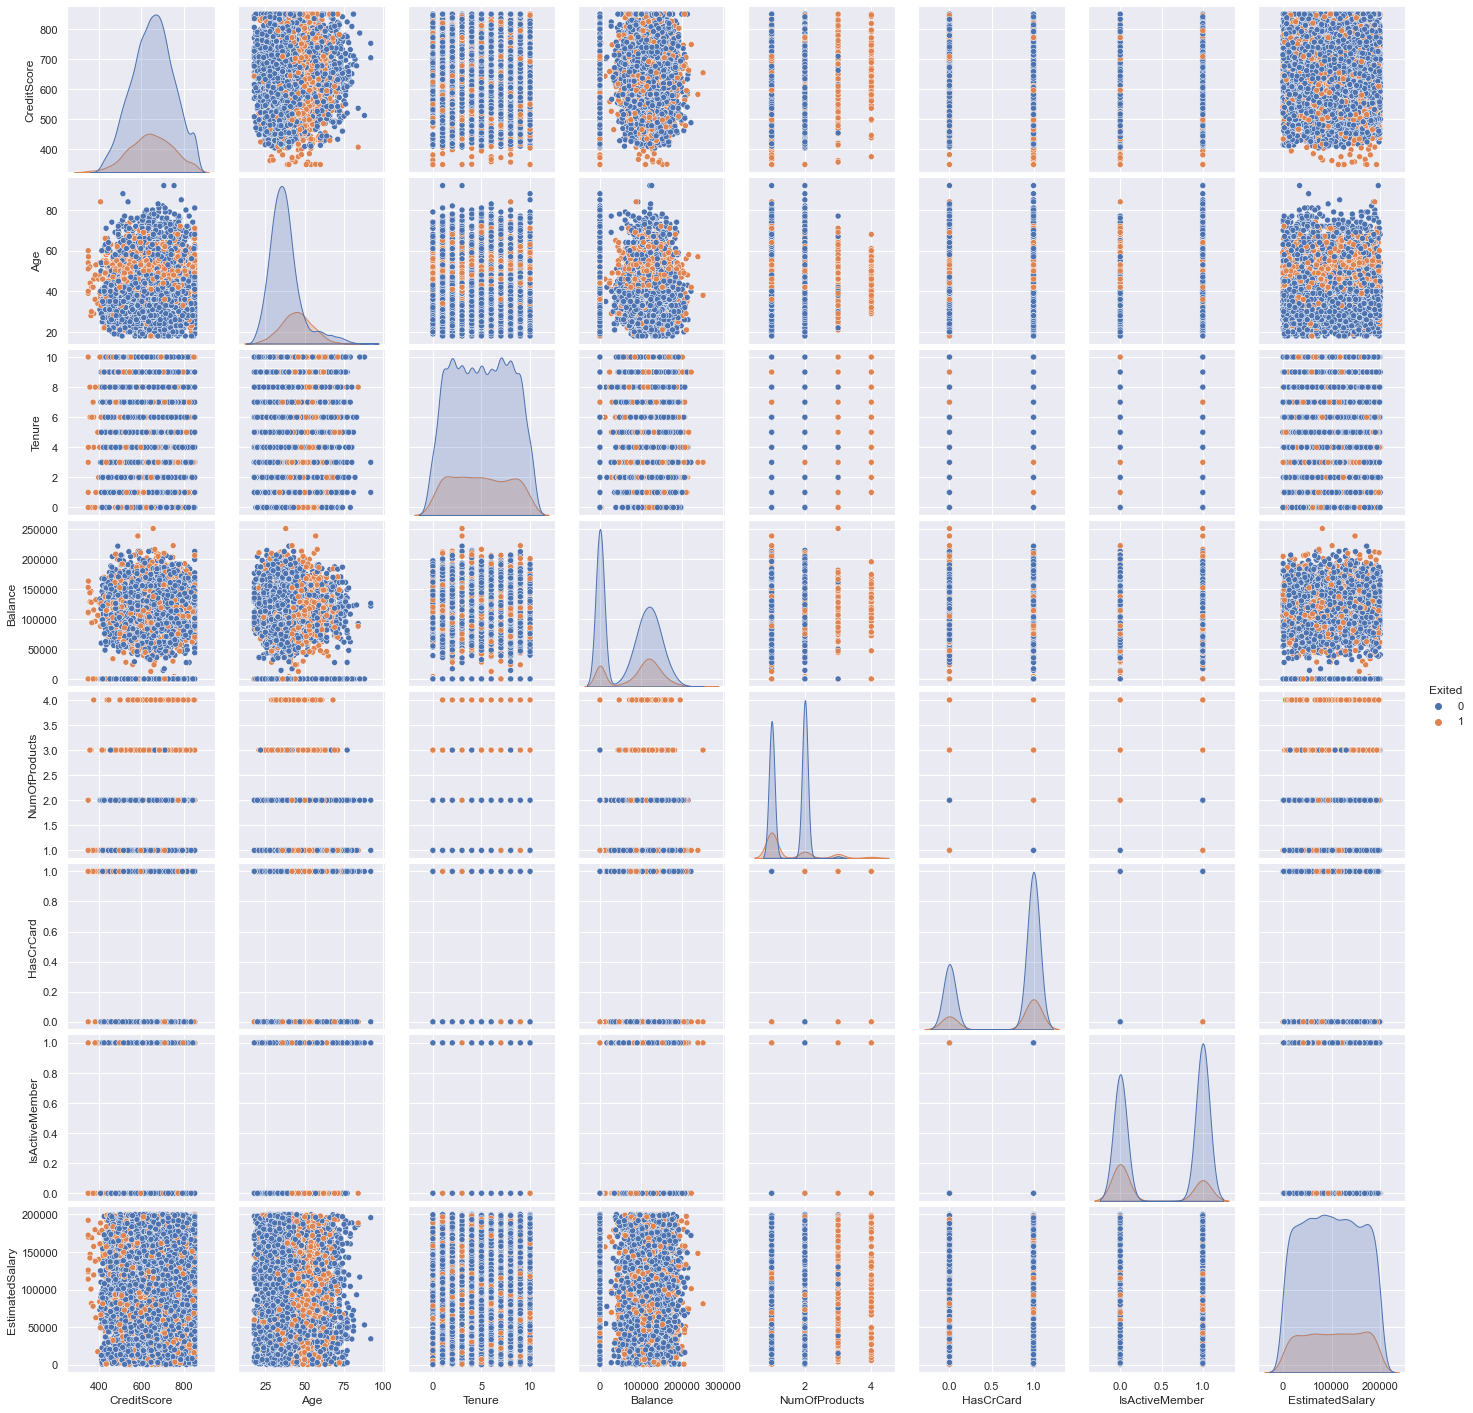

In [182]:
sns.pairplot(df, hue="Exited");

#### Observations
* In our correlation heat map we saw very low cross correlation scores. We can see above that there are no linear relationships between the variables. However, that does not mean that there are no patterns in the data. We can clearly see above that there *are* patterns in the data:
* Almost all of our low outliers in CreditScore have exited the bank. For this reason we will not treat the outliers in these data as we will remove an obvious pattern in the data by doing so.
* We can also see that for the 3.3% of customers who do have NumOfProducts = 3 or 4, a very high proportion of these customers have exited the bank. For this reason we will not treat these data.
* We can see there is a section of the Age range, from about 40-70 where the probability that a customer has exited the bank is much higher. We will look at this in more detail below.
* Customers with a zero balance are less likely to have exited the bank than customers with a non-zero balance.
* Customers who are active members (IsActiveMember = 1) are less like to have exited the bank.
* There does not appear to be a relationship between Tenure and the target variable.
* There does not appear to be a relationship between EstimatedSalary and the target variable.

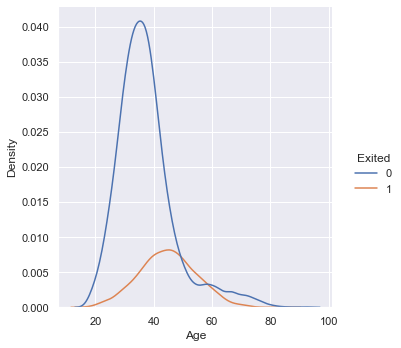

In [183]:
# Let's take a closer look at the relationship between Age and Exited
sns.displot(data=df, x='Age', hue='Exited', kind='kde');

* Above we can see that between the ages of about 50-60, there are more customers that have Exited then customers that have not. However, the mix is still about 50% exited, 50% not.

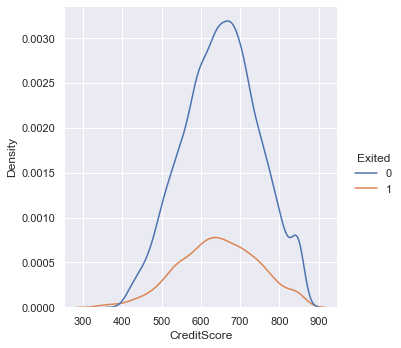

In [184]:
# Let's take a closer look at the relationship between CreditScore and Exited
sns.displot(data=df, x='CreditScore', hue='Exited', kind='kde');

In [328]:
# Let's get some numbers for customers with a low credit score.
temp = df[df['CreditScore']<400]
temp['Exited'].value_counts()

1    19
Name: Exited, dtype: int64

* Above we can see that, for the small proportion of customers with a credit score below 400 (19 customers total), all of them have exited the bank.

### Categorical Variables vs. Target Variable
Below we will investigate the relationship between our categorical variables and our target variable. We will include the obvious categorical variables: Gender and Geography. We will also include the variables where the range is small enough that we can treat the variables as categorical.

In [186]:
### Function to plot stacked bar charts for categorical columns
def stacked_plot(x):
    tab = pd.crosstab(x, df["Exited"], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(10, 5))
    plt.legend(loc="lower left", frameon=False)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()
    # Show numbers that feed the bar chart with percentages
    tab1 = pd.crosstab(x, df["Exited"], margins=True)
    tab1['Percent_Exited'] = round((tab1[1] / tab1['All'])*100, 2)
    tab1['Percent_Customer'] = round((tab1[0] / tab1['All'])*100, 2)
    return tab1

#### Relationship Between Gender and Target

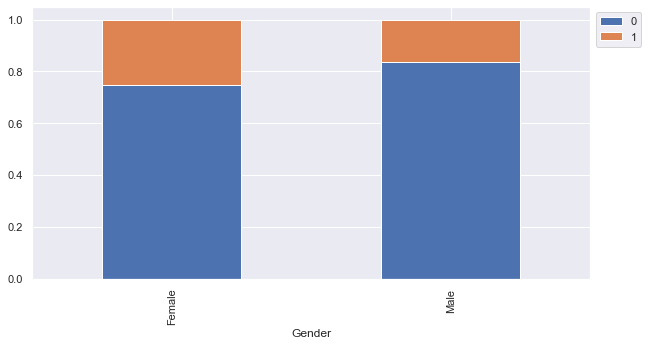

Exited,0,1,All,Percent_Exited,Percent_Customer
Gender,,,,,
Female,3404,1139,4543,25.07,74.93
Male,4559,898,5457,16.46,83.54
All,7963,2037,10000,20.37,79.63


In [187]:
stacked_plot(df['Gender'])

* It appears that females are slightly more like to have exited the bank than males.

#### Relationship Between Geography and Target

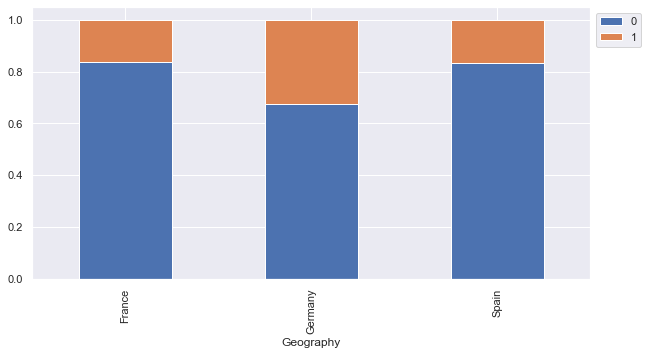

Exited,0,1,All,Percent_Exited,Percent_Customer
Geography,,,,,
France,4204,810,5014,16.15,83.85
Germany,1695,814,2509,32.44,67.56
Spain,2064,413,2477,16.67,83.33
All,7963,2037,10000,20.37,79.63


In [188]:
stacked_plot(df['Geography'])

* More customers from Germany have exited the bank than customers from France and Spain. 
* For 32% of customers from Germany have exited the bank, the percentage of exited customers in France and Spain is ~16%

#### Relationship Between Tenure and Target

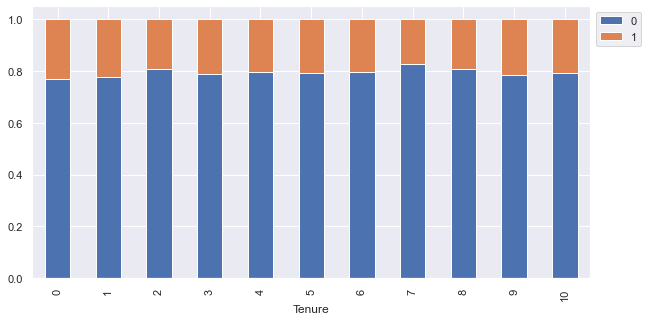

Exited,0,1,All,Percent_Exited,Percent_Customer
Tenure,,,,,
0,318,95,413,23.00,77.00
1,803,232,1035,22.42,77.58
2,847,201,1048,19.18,80.82
3,796,213,1009,21.11,78.89
4,786,203,989,20.53,79.47
5,803,209,1012,20.65,79.35
6,771,196,967,20.27,79.73
7,851,177,1028,17.22,82.78
8,828,197,1025,19.22,80.78


In [189]:
stacked_plot(df['Tenure'])

* As we saw in the pair plot, there is no relationship between Tenure and a customer exiting the bank. The percentage of customers who exited the bank is ~20% across the range. Which is our global average for percentage of exited customers.

#### Relationship Between NumOfProducts and Target

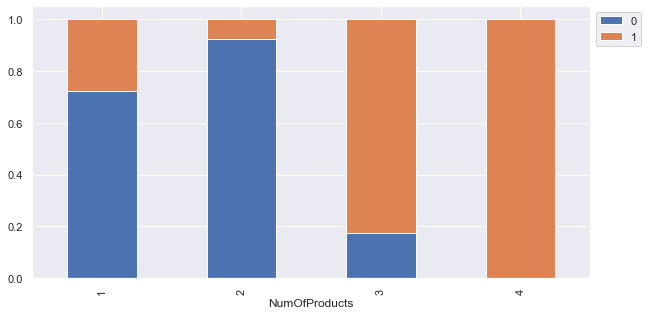

Exited,0,1,All,Percent_Exited,Percent_Customer
NumOfProducts,,,,,
1,3675,1409,5084,27.71,72.29
2,4242,348,4590,7.58,92.42
3,46,220,266,82.71,17.29
4,0,60,60,100.00,0.00
All,7963,2037,10000,20.37,79.63


In [190]:
stacked_plot(df['NumOfProducts'])

* As we saw in the pair plots, NumOfProducts is a strong predictor of the target class.
* The data here are counter-intuative, customers that have MORE products are more likely to leave. This could just be an anomaly, as only 3.3% of customers have 3 or 4 products.
* The bulk of customers fall into the 1-2 range. Of these, customers with 2 products are much less likely to exit the bank, only 8%, well below the global 20%.

#### Relationship Between HasCrCard and Target

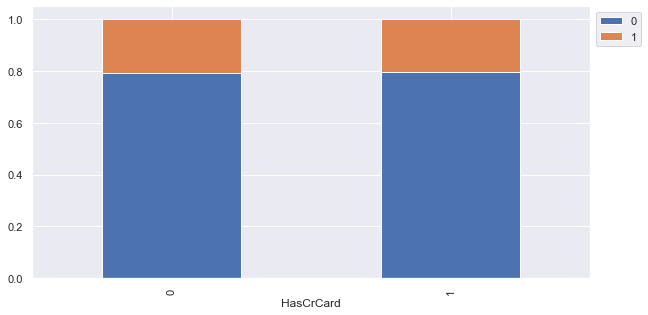

Exited,0,1,All,Percent_Exited,Percent_Customer
HasCrCard,,,,,
0,2332,613,2945,20.81,79.19
1,5631,1424,7055,20.18,79.82
All,7963,2037,10000,20.37,79.63


In [191]:
stacked_plot(df['HasCrCard'])

* There is no relationship between a customer having a credit card and a customer leaving the bank.

#### Relationship Between IsActiveMember and Target

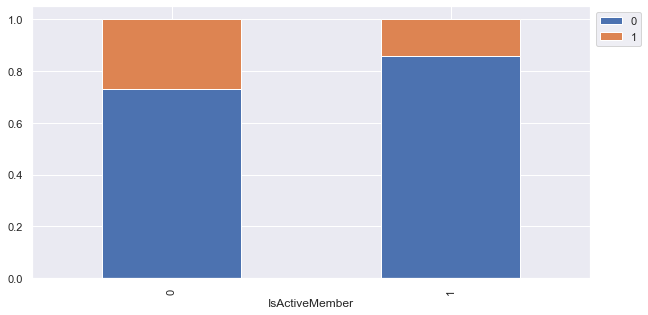

Exited,0,1,All,Percent_Exited,Percent_Customer
IsActiveMember,,,,,
0,3547,1302,4849,26.85,73.15
1,4416,735,5151,14.27,85.73
All,7963,2037,10000,20.37,79.63


In [192]:
stacked_plot(df['IsActiveMember'])

* Customers who are active are less likely to have exited the bank. Only 14% of average customers exited the bank (lower than the global average of 20%. 26% of Customers who are inactive exited the bank.

# Illustrate the insights based on EDA
*Key meaningful observations from Bivariate analysis*

* We have seen that the data are non-linear. The cross correlation between variables is close to zero for all variables. In our pair plots we don't observe any linear trends - all data cross plots look like clouds.
* However, there are patterns in the data that relate to our target variable, Exited. Over the entire data set, 20% of customers have exited. We will consider a variable significant when a segment of that variables range contains customers that deviate from the 20%.
    - 100% of customers with a CreditScore below 400 have exited the bank. However, only 19 of the 10,000 customers have a credit score this low.
    - There are 3.3% of customers who have NumOfProducts = 3 or 4. Of these, a very high proportion of these customers have exited the bank. 100% of customers with 4 products exited the bank, 82% of customers with 3 products exited the bank.
    - The bulk of customers (96.7%) have NumOfProducts = 2 or 3. Of these, customers with 2 products are much less likely to exit the bank, only 8%, well below the global 20%.
    - Females are more like to exit the bank, 25% vs. 16.5% for males.
    - Germans are more likely to exit the bank 32% vs. only 16-17% in both France and Spain.
    - For customers in Age range 40-70, the probability that a customer has exited the bank is much higher. 
    - Customers with a zero balance are less likely to have exited the bank than customers with a non-zero balance.
    - Customers who are active members (IsActiveMember = 1) are less like to have exited the bank (14% vs. 27% for non-active members).



# Data Pre-processing
*Split the target variable and predictors - Split the data into train and test - Rescale the data*


## Encode Categorical Variables

In [193]:
df_edit = df.copy() # we will create a copy of our data before we encode it

In [194]:
df = pd.get_dummies(df, drop_first=True) # We will one-hot-encode the Gender and Geography columns
df # display head and tail to check data after encoding

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


In [195]:
df.info() # Check data types in data frame after encoding

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


* After one-hot-encoding, our data now has 12 columns. All data types are numerical.

## Split Data into Test and Train Sets

In [196]:
# Separating target variable and other variables
X = df.drop(columns="Exited")
y = df["Exited"]

In [197]:
# Let's split the data into a train and test sets. 
# I will use the stratify parameter to maintain the ratio of classes in the dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [198]:
# Check the split of the data
print("{0:0.2f}% data is in training set".format((len(X_train)/len(df.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test)/len(df.index)) * 100))

70.00% data is in training set
30.00% data is in test set


In [199]:
# Check the stratification of the data
print("Original Exited 1 Values    : {0} ({1:0.2f}%)".format(len(df.loc[df['Exited'] == 1]), (len(df.loc[df['Exited'] == 1])/len(df.index)) * 100))
print("Original Exited 0 Values   : {0} ({1:0.2f}%)".format(len(df.loc[df['Exited'] == 0]), (len(df.loc[df['Exited'] == 0])/len(df.index)) * 100))
print("")
print("Training Exited 1 Values    : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train)) * 100))
print("Training Exited 0 Values   : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train)) * 100))
print("")
print("Test Exited 1 Values        : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test)) * 100))
print("Test Exited 0 Values       : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test)) * 100))

Original Exited 1 Values    : 2037 (20.37%)
Original Exited 0 Values   : 7963 (79.63%)

Training Exited 1 Values    : 1426 (20.37%)
Training Exited 0 Values   : 5574 (79.63%)

Test Exited 1 Values        : 611 (20.37%)
Test Exited 0 Values       : 2389 (79.63%)


In [200]:
X_train # Check our training data, not the random index.

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7635,516,29,2,104982.57,1,1,0,157378.50,0,0,0
5284,745,51,3,99183.90,1,1,1,28922.25,1,0,1
1457,850,66,4,0.00,2,0,1,64350.80,0,0,1
4785,510,22,3,156834.34,1,0,0,44374.44,0,0,0
9158,540,31,10,118158.74,1,1,1,158027.57,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5090,474,30,9,0.00,2,0,0,63158.22,0,0,0
9358,837,29,9,0.00,2,1,1,41866.26,0,0,0
813,421,28,8,122384.22,3,1,1,89017.38,1,0,1
451,850,40,9,0.00,2,0,1,119232.33,0,0,1


## Scale Train and Test Data

In [201]:
# Save the columns names as StandardScaler will strip them
X_cols = X_train.columns

# Initialize our Standard Scalar
ss = StandardScaler()

X_train = ss.fit_transform(X_train) # Fit scalar to training data and transform
X_test = ss.transform(X_test) # ONLY apply the transform to the test data

In [203]:
# Check to see the effects of the Standard Scaler on the training data
pd.DataFrame(X_train, columns=X_cols).describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,7000.0,-3.067070e-16,1.000071,-3.099859,-0.683204,0.008745,6.903653e-01,2.063934
Age,7000.0,2.421872e-16,1.000071,-1.979491,-0.655128,-0.182141,4.800413e-01,5.020717
Tenure,7000.0,1.429967e-16,1.000071,-1.729389,-1.035870,0.004409,6.979277e-01,1.738206
Balance,7000.0,-1.554312e-17,1.000071,-1.215278,-1.215278,0.330628,8.217812e-01,2.788969
NumOfProducts,7000.0,3.995851e-16,1.000071,-0.918448,-0.918448,-0.918448,7.887044e-01,4.203009
HasCrCard,7000.0,3.774758e-16,1.000071,-1.549099,-1.549099,0.645536,6.455364e-01,0.645536
IsActiveMember,7000.0,1.582861e-17,1.000071,-1.033120,-1.033120,0.967942,9.679422e-01,0.967942
EstimatedSalary,7000.0,1.816424e-16,1.000071,-1.741260,-0.842769,-0.009364,8.475445e-01,1.757709
Geography_Germany,7000.0,6.058646e-17,1.000071,-0.577350,-0.577350,-0.577350,-5.551115e-17,1.732051
Geography_Spain,7000.0,3.366196e-16,1.000071,-0.578230,-0.578230,-0.578230,1.729416e+00,1.729416


* After applying the standard scaler to the training data set, we can see that the mean for each column is zero (e-16 is close enough to zero for our purposes), and the standard deviation is one.

In [204]:
# Check to see the effects of the Standard Scaler on the test data
pd.DataFrame(X_test, columns=X_cols).describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,3000.0,0.012927,0.993912,-3.099859,-0.685786,0.039727,0.713602,2.063934
Age,3000.0,-0.001144,0.973476,-1.979491,-0.655128,-0.182141,0.480041,4.169341
Tenure,3000.0,0.029491,1.009298,-1.729389,-0.689110,0.004409,1.044687,1.738206
Balance,3000.0,0.018036,0.985950,-1.215278,-1.215278,0.349551,0.822568,2.332037
NumOfProducts,3000.0,-0.044386,0.975666,-0.918448,-0.918448,-0.918448,0.788704,4.203009
HasCrCard,3000.0,-0.002613,1.001343,-1.549099,-1.549099,0.645536,0.645536,0.645536
IsActiveMember,3000.0,-0.007909,1.000393,-1.033120,-1.033120,0.967942,0.967942,0.967942
EstimatedSalary,3000.0,0.032559,1.020270,-1.739309,-0.859770,0.052481,0.923844,1.756254
Geography_Germany,3000.0,0.006928,1.004135,-0.577350,-0.577350,-0.577350,1.732051,1.732051
Geography_Spain,3000.0,-0.022087,0.987122,-0.578230,-0.578230,-0.578230,-0.578230,1.729416


* The transform was fit on the training data. 
* After applying the transform to the test data, we can see that the mean is close to zero (to 2 decimal places) and the standard deviation is very close to one.
* We do not expect a perfect mean of zero and standard deviation of one as the transform was not fit on the test data. The results above are good for our purposes.

# -----------------------------------------------------------------------------------------------------

# Model building
*Build Neural Network*

Before we start building models, we need to get some prep work out of the way. First we will define the model evaluation criterion. We will then define some functions to help us evaluate our models.

## Model evaluation criterion

### Model can make wrong predictions as:
* Predicting a customer has exited when the customer has not exited (false positive)
* Predicting a customer has not exited when a customer has exited (false negative)

### Which case is more important? 
* We want to minimize false negatives. If we fail to predict customers who will exit, the bank will not be able to achieve its goal of reducing churn (customers exiting). If we can correctly predict customers who will exit the bank, the bank can take measures to retain those customers.

### How to reduce False Negatives?
* Company  would want `Recall` to be maximized, greater the Recall higher the chances of minimizing false Negatives. Hence, the focus should be on increasing Recall or minimizing the false Negative, or in other words, identifying the True Positives (i.e. Class 1) so that the Company can identify customers who will potentially exit/churn.

### Functions to help evaluate models
* As we will be evaluating a number of models, let's write functions to help us calculate metrics and display a confusion matrix. Our neural networks will have a sigmoid as the activation function in the output layer. This means that they will output probabilites. We can chose a probability threshold at which we delineate class 1 and class 2. We will set the default at 0.5 but leave ourselves free to adjust this.  
* We will then write a function to calculate the Receiver Operating Characteristic (ROC) curve. The area under the curve gives us another metric with which we can evaluate our model. We can also calculate an "optimum" threshold using the curve, where the  True Positive Rate is high and False Positive Rate is low.
* We will print metrics and the confusion matrix as the optimum threshold (given from the ROC curve) multiple times, we will write a function to calculate the optimum threshold.
* Finally, we will plot the training and validation vs. epoch, "history" plot many times, so we will write a function here to keep our code looking clean.

In [205]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,train,test,train_y,test_y,flag=True,threshold=0.5):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    # Getting predictions from the model. These will come in the form of probabilities
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    # We will need to convert the probabilities into classes using a threshold, default is 0.5
    
    for i in range(len(train_y)):
        if pred_train[i]>threshold:
            pred_train[i]=1 
        else:
            pred_train[i]=0
    
    for i in range(len(test_y)):
        if pred_test[i]>threshold:
            pred_test[i]=1 
        else:
            pred_test[i]=0
        
    # Now we can calculate metircs
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    train_f1 = f1_score(train_y,pred_train)
    test_f1 = f1_score(test_y,pred_test)
    
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1))
        
     # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Accuracy on test set : ",accuracy_score(pred_test,test_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Recall on test set : ",recall_score(test_y,pred_test))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("Precision on test set : ",precision_score(test_y,pred_test))
        print("F1 on training set : ",f1_score(train_y,pred_train))
        print("F1 on test set : ",f1_score(test_y,pred_test))
    
    #return score_list # returning the list with train and test scores

In [206]:
## This function is exactly the same as the last, only it will NOT use the test data
## There will be many times that we want to look at training metrics without looking at test metrics 
## This is to avoid tuning the model on the test data

##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_training_metrics(model,train,train_y,flag=True,threshold=0.5):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    # Getting predictions from the model. These will come in the form of probabilities
    
    pred_train = model.predict(train)
    
    # We will need to convert the probabilities into classes using a threshold, default is 0.5
    
    for i in range(len(train_y)):
        if pred_train[i]>threshold:
            pred_train[i]=1 
        else:
            pred_train[i]=0
          
    # Now we can calculate metircs
    
    train_acc = accuracy_score(pred_train,train_y)
    train_recall = recall_score(train_y,pred_train)
    train_precision = precision_score(train_y,pred_train)
    train_f1 = f1_score(train_y,pred_train)
   
    score_list.extend((train_acc,train_recall,train_precision,train_f1))
        
     # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("F1 on training set : ",f1_score(train_y,pred_train))

In [207]:
def make_confusion_matrix(model,test_X,y_actual,labels=[1, 0],threshold=0.5):
    '''
    model : classifier to predict values of X
    y_actual : ground truth
    threshold : value used to convert probabilites to classes. Range = 0-1
    
    '''
    # Our model will output probabilities we will convert these to classes using a threshold (dafault is 0.5)
    y_predict = model.predict(test_X)
    
    for i in range(len(y_actual)):
        if y_predict[i]>threshold:
            y_predict[i]=1 
        else:
            y_predict[i]=0
    
    # We can now plot the confusion matrix    
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [208]:
def make_ROC(model):
    # Calculate the False Postive Rate, True Positive Rate, ROC curve and area under ROC curve
    y_probs = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
    roc_auc = metrics.auc(fpr, tpr)

    # Now plot the information calculated above
    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Now print the optimal threshold
    # The optimal cut off would be where tpr is high and fpr is low
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print('The optimal threshold is:', optimal_threshold)

In [209]:
# This function returns the optimum output from the ROC curve given a model.
def get_optimal(model):
    y_probs = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

In [210]:
#This function will plot the training and validation loss vs. training epoch
def get_history_plot(n):
    N = n
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation loss on the dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("train_Loss/val_loss")
    plt.legend()
    plt.show()

## Build the Initial Model
The following will be true for all of our models:
* We will use tf.keras to build the models. 
* All of our models will be Sequential models.
* As we are performing binary classification we will chose:
    * A single neuron as our output layer with a sigmoid activation function
    * binary_crossentropy as our loss function

The other parameters we will tune to attempt to get the best prediction possible. For our first model we will have 2 hidden layers and an output layer. We will use SGD as our optimizer with a learning rate of 0.01

In [211]:
#Initialize sequenial model
# To start we will have 2 hidden layers and an output layer

model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

# Defining the optimizer. We will use SGD, which is a Gradient Decent optimizer
optimizer = tf.keras.optimizers.SGD(0.01)  

# Compile the model
model.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [212]:
# Write a summary of the initial model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 20)                240       
_________________________________________________________________
dense_16 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


### Fit the model

In [213]:
#Definign the number of epochs
EPOCHS = 100
#fitting the model
history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=2,)

Epoch 1/100
175/175 - 0s - loss: 0.6102 - accuracy: 0.6896 - val_loss: 0.5415 - val_accuracy: 0.7800
Epoch 2/100
175/175 - 0s - loss: 0.5041 - accuracy: 0.8000 - val_loss: 0.5093 - val_accuracy: 0.7807
Epoch 3/100
175/175 - 0s - loss: 0.4785 - accuracy: 0.8007 - val_loss: 0.4888 - val_accuracy: 0.7807
Epoch 4/100
175/175 - 0s - loss: 0.4615 - accuracy: 0.8011 - val_loss: 0.4730 - val_accuracy: 0.7821
Epoch 5/100
175/175 - 0s - loss: 0.4485 - accuracy: 0.8023 - val_loss: 0.4605 - val_accuracy: 0.7857
Epoch 6/100
175/175 - 0s - loss: 0.4381 - accuracy: 0.8071 - val_loss: 0.4518 - val_accuracy: 0.7929
Epoch 7/100
175/175 - 0s - loss: 0.4300 - accuracy: 0.8116 - val_loss: 0.4435 - val_accuracy: 0.8021
Epoch 8/100
175/175 - 0s - loss: 0.4232 - accuracy: 0.8148 - val_loss: 0.4367 - val_accuracy: 0.8143
Epoch 9/100
175/175 - 0s - loss: 0.4175 - accuracy: 0.8171 - val_loss: 0.4317 - val_accuracy: 0.8121
Epoch 10/100
175/175 - 0s - loss: 0.4123 - accuracy: 0.8205 - val_loss: 0.4265 - val_accura

Epoch 82/100
175/175 - 0s - loss: 0.3243 - accuracy: 0.8682 - val_loss: 0.3572 - val_accuracy: 0.8529
Epoch 83/100
175/175 - 0s - loss: 0.3240 - accuracy: 0.8687 - val_loss: 0.3581 - val_accuracy: 0.8514
Epoch 84/100
175/175 - 0s - loss: 0.3237 - accuracy: 0.8684 - val_loss: 0.3592 - val_accuracy: 0.8514
Epoch 85/100
175/175 - 0s - loss: 0.3237 - accuracy: 0.8675 - val_loss: 0.3581 - val_accuracy: 0.8507
Epoch 86/100
175/175 - 0s - loss: 0.3236 - accuracy: 0.8671 - val_loss: 0.3578 - val_accuracy: 0.8521
Epoch 87/100
175/175 - 0s - loss: 0.3236 - accuracy: 0.8682 - val_loss: 0.3574 - val_accuracy: 0.8529
Epoch 88/100
175/175 - 0s - loss: 0.3233 - accuracy: 0.8693 - val_loss: 0.3576 - val_accuracy: 0.8521
Epoch 89/100
175/175 - 0s - loss: 0.3233 - accuracy: 0.8691 - val_loss: 0.3588 - val_accuracy: 0.8521
Epoch 90/100
175/175 - 0s - loss: 0.3231 - accuracy: 0.8679 - val_loss: 0.3576 - val_accuracy: 0.8521
Epoch 91/100
175/175 - 0s - loss: 0.3228 - accuracy: 0.8679 - val_loss: 0.3590 - v

* We can see the loss on the test and validation data slowly dropping as we progress through the epochs
* We can see the accuracy increase with the epochs, the training and validation accuracy appear to be similar, it does not appear that our model is overfitting.

Let's plot the training and validaiton loss vs. epochs for our initial model:

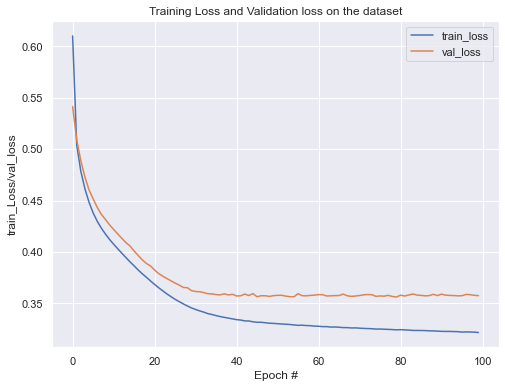

In [214]:
get_history_plot(100)

* Both the training and validation loss decrease as the number of epochs increase. However after about 60 epochs the validation loss ceases to decrease.
* For this we could conclude that the model starts to overfit after 60 epochs. However, our training and validation accuracy is not too far apart so the overfitting is not too bad.

### Evaluate Initial Model Performance on Test Data (Default Threshold)

In [215]:
get_metrics_score(model,X_train,X_test,y_train,y_test,threshold=0.5)

Accuracy on training set :  0.8655714285714285
Accuracy on test set :  0.8556666666666667
Recall on training set :  0.5028050490883591
Recall on test set :  0.469721767594108
Precision on training set :  0.7555321390937829
Precision on test set :  0.7247474747474747
F1 on training set :  0.6037894736842105
F1 on test set :  0.5700099304865939


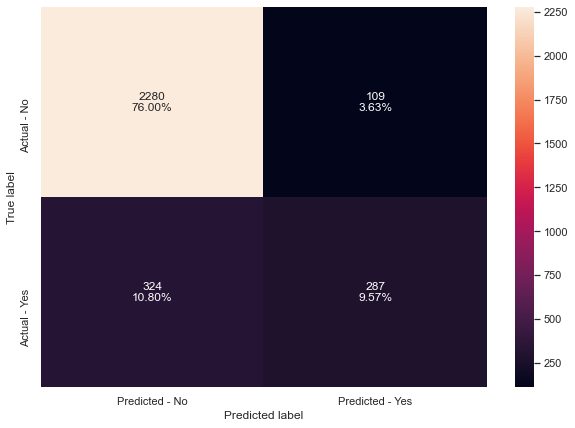

In [216]:
make_confusion_matrix(model,X_test,y_test,threshold=0.5)

* Our initial model has an accuracy of 86% on test data. Given that ~80% of our customers are class 0, a simple model that predicts all customers as class 0 would achieve an accuracy of 80%. Our model is not doing much better than that!
* The test recall is only ~46%, again this is not good.
* There is definitely room for improvement here. Let's see if we can improve our scores by chosing a different probability threshold. We will make use of an ROC curve using the test data, this will give us another metric to evaluate our model (area under curve) and hopefully give us a threshold that works better.

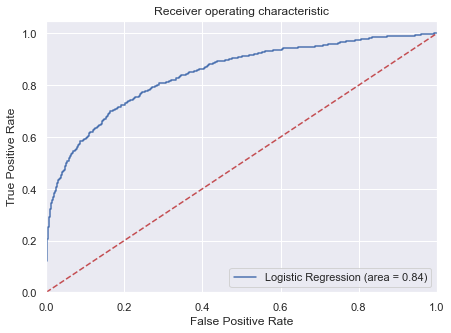

The optimal threshold is: 0.24906006


In [217]:
make_ROC(model)

In [218]:
optimal = get_optimal(model)
get_metrics_score(model,X_train,X_test,y_train,y_test,threshold=optimal)

Accuracy on training set :  0.82
Accuracy on test set :  0.8073333333333333
Recall on training set :  0.7433380084151473
Recall on test set :  0.6972176759410802
Precision on training set :  0.5424769703172978
Precision on test set :  0.5201465201465202
F1 on training set :  0.6272189349112426
F1 on test set :  0.5958041958041959


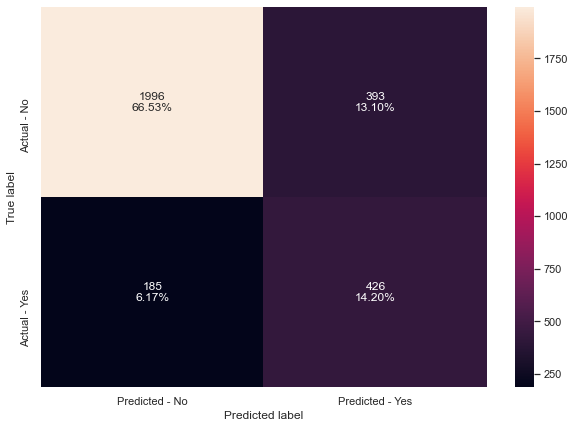

In [219]:
make_confusion_matrix(model,X_test,y_test,threshold=optimal)

* The metrics change slightly with each run through, so the numbers below are appoximate:
    * Decreased Test Accuracy by ~6%
    * Increased Test Recall by ~20%
    * Decreased Test Precision by ~20%
    * Increased Test F1 Score by ~2%
* So essentially we have traded a loss of precision for a boost in recall. There are now a lot more customers predicted to exit the bank who did not exit. However, there are now less customers who exited the bank and were not predicted to exit. Given that we want to maximize recall (as the price of a false negative is much higher than a false positive), this is a fair trade.
* Our model is still misclassifying a lot of customers and could likely be improved. So let's get to work!

# Model Performance Improvement
*Comment on which metric is right for model performance evaluation and why? - Find the optimal threshold using ROC-AUC curves - Comment on model performance - Can model performance be improved? check and comment - Build another model to implement these improvements - Include all the model which were trained to reach at the final one*

We have already mentioned that we have chosen recall as our metric to optimize and our justifications for this. Furthermore we have evaluated our initial model and attempted to optimize the threshold using the ROC-AUC curves. Finally we mentioned that our initial model could likely be improved.  
In this section we will trial a number of ideas, attempting to improve the model results. We will tune the hyperparameters using training data and will not evaluate the model on the test data again until we have a model that we are happy with. This way we will avoid the temptation to tune the model to the test data.

### Model 2 - Increase nodes
Our initial model didn't appear to suffer too much from overfitting. For this reason, we will attempt a much more complicated model and see if we can get better metrics. We will 5x the number of nodes and see what happens.

In [220]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

# Defining the optimizer. We will use SGD, which is a Gradient Decent optimizer
optimizer = tf.keras.optimizers.SGD(0.01)  

# Compile the model
model2.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [221]:
EPOCHS = 100 # define epochs
history = model2.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2,) # fit model


Epoch 1/100
175/175 - 0s - loss: 0.5569 - accuracy: 0.7570 - val_loss: 0.5140 - val_accuracy: 0.7807
Epoch 2/100
175/175 - 0s - loss: 0.4729 - accuracy: 0.8004 - val_loss: 0.4843 - val_accuracy: 0.7836
Epoch 3/100
175/175 - 0s - loss: 0.4474 - accuracy: 0.8023 - val_loss: 0.4647 - val_accuracy: 0.7914
Epoch 4/100
175/175 - 0s - loss: 0.4312 - accuracy: 0.8109 - val_loss: 0.4523 - val_accuracy: 0.8043
Epoch 5/100
175/175 - 0s - loss: 0.4205 - accuracy: 0.8163 - val_loss: 0.4443 - val_accuracy: 0.8086
Epoch 6/100
175/175 - 0s - loss: 0.4129 - accuracy: 0.8205 - val_loss: 0.4377 - val_accuracy: 0.8143
Epoch 7/100
175/175 - 0s - loss: 0.4068 - accuracy: 0.8232 - val_loss: 0.4329 - val_accuracy: 0.8164
Epoch 8/100
175/175 - 0s - loss: 0.4014 - accuracy: 0.8273 - val_loss: 0.4284 - val_accuracy: 0.8193
Epoch 9/100
175/175 - 0s - loss: 0.3964 - accuracy: 0.8327 - val_loss: 0.4228 - val_accuracy: 0.8229
Epoch 10/100
175/175 - 0s - loss: 0.3915 - accuracy: 0.8354 - val_loss: 0.4175 - val_accura

Epoch 82/100
175/175 - 0s - loss: 0.3015 - accuracy: 0.8763 - val_loss: 0.3580 - val_accuracy: 0.8536
Epoch 83/100
175/175 - 0s - loss: 0.3008 - accuracy: 0.8746 - val_loss: 0.3607 - val_accuracy: 0.8521
Epoch 84/100
175/175 - 0s - loss: 0.3006 - accuracy: 0.8745 - val_loss: 0.3581 - val_accuracy: 0.8543
Epoch 85/100
175/175 - 0s - loss: 0.3003 - accuracy: 0.8755 - val_loss: 0.3566 - val_accuracy: 0.8493
Epoch 86/100
175/175 - 0s - loss: 0.2994 - accuracy: 0.8768 - val_loss: 0.3567 - val_accuracy: 0.8521
Epoch 87/100
175/175 - 0s - loss: 0.2994 - accuracy: 0.8759 - val_loss: 0.3571 - val_accuracy: 0.8529
Epoch 88/100
175/175 - 0s - loss: 0.2989 - accuracy: 0.8777 - val_loss: 0.3594 - val_accuracy: 0.8521
Epoch 89/100
175/175 - 0s - loss: 0.2987 - accuracy: 0.8755 - val_loss: 0.3571 - val_accuracy: 0.8521
Epoch 90/100
175/175 - 0s - loss: 0.2978 - accuracy: 0.8775 - val_loss: 0.3595 - val_accuracy: 0.8529
Epoch 91/100
175/175 - 0s - loss: 0.2976 - accuracy: 0.8788 - val_loss: 0.3590 - v

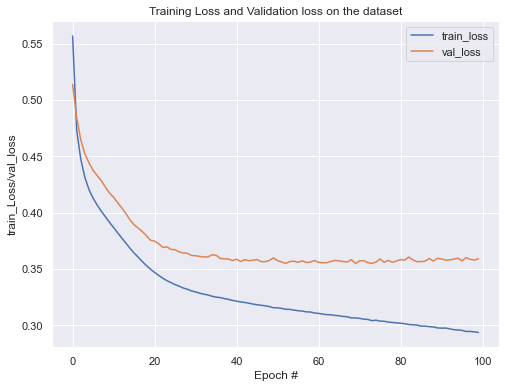

Accuracy on training set :  0.8748571428571429
Recall on training set :  0.5182328190743338
Precision on training set :  0.7963362068965517
F1 on training set :  0.6278674596431606


In [222]:
get_history_plot(100)
get_training_metrics(model2, X_train, y_train)

* We see a slight improvement in training data accuracy, however the validation accuracy does not increase.
* We can see that the model is overfitting the training data.

It is clear that, after increasing the number of nodes, the model is not generalizing well. It doesn't even do a good job of fitting the training data! Let's make another attempt at increasing complexity. This time we will increase the number of hidden nodes.

### Model 3 - Increase hidden layers

In [223]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

# Defining the optimizer. We will use SGD, which is a Gradient Decent optimizer
optimizer = tf.keras.optimizers.SGD(0.01)  

# Compile the model
model3.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [224]:
EPOCHS = 100 # define epochs
history = model3.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2,) # fit model


Epoch 1/100
175/175 - 0s - loss: 0.5578 - accuracy: 0.7882 - val_loss: 0.5226 - val_accuracy: 0.7807
Epoch 2/100
175/175 - 0s - loss: 0.4867 - accuracy: 0.8002 - val_loss: 0.5023 - val_accuracy: 0.7807
Epoch 3/100
175/175 - 0s - loss: 0.4657 - accuracy: 0.8002 - val_loss: 0.4830 - val_accuracy: 0.7807
Epoch 4/100
175/175 - 0s - loss: 0.4468 - accuracy: 0.8002 - val_loss: 0.4654 - val_accuracy: 0.7807
Epoch 5/100
175/175 - 0s - loss: 0.4307 - accuracy: 0.8002 - val_loss: 0.4520 - val_accuracy: 0.7807
Epoch 6/100
175/175 - 0s - loss: 0.4180 - accuracy: 0.8009 - val_loss: 0.4414 - val_accuracy: 0.7843
Epoch 7/100
175/175 - 0s - loss: 0.4080 - accuracy: 0.8100 - val_loss: 0.4331 - val_accuracy: 0.7971
Epoch 8/100
175/175 - 0s - loss: 0.3996 - accuracy: 0.8225 - val_loss: 0.4255 - val_accuracy: 0.8129
Epoch 9/100
175/175 - 0s - loss: 0.3915 - accuracy: 0.8314 - val_loss: 0.4183 - val_accuracy: 0.8193
Epoch 10/100
175/175 - 0s - loss: 0.3839 - accuracy: 0.8366 - val_loss: 0.4091 - val_accura

Epoch 82/100
175/175 - 0s - loss: 0.2381 - accuracy: 0.9004 - val_loss: 0.4187 - val_accuracy: 0.8321
Epoch 83/100
175/175 - 0s - loss: 0.2355 - accuracy: 0.9029 - val_loss: 0.4251 - val_accuracy: 0.8314
Epoch 84/100
175/175 - 0s - loss: 0.2336 - accuracy: 0.9005 - val_loss: 0.4109 - val_accuracy: 0.8321
Epoch 85/100
175/175 - 0s - loss: 0.2341 - accuracy: 0.9036 - val_loss: 0.4152 - val_accuracy: 0.8336
Epoch 86/100
175/175 - 0s - loss: 0.2310 - accuracy: 0.9004 - val_loss: 0.4167 - val_accuracy: 0.8307
Epoch 87/100
175/175 - 0s - loss: 0.2306 - accuracy: 0.8993 - val_loss: 0.4261 - val_accuracy: 0.8293
Epoch 88/100
175/175 - 0s - loss: 0.2274 - accuracy: 0.9023 - val_loss: 0.4216 - val_accuracy: 0.8300
Epoch 89/100
175/175 - 0s - loss: 0.2253 - accuracy: 0.9079 - val_loss: 0.4550 - val_accuracy: 0.8314
Epoch 90/100
175/175 - 0s - loss: 0.2261 - accuracy: 0.9064 - val_loss: 0.4352 - val_accuracy: 0.8271
Epoch 91/100
175/175 - 0s - loss: 0.2226 - accuracy: 0.9077 - val_loss: 0.4257 - v

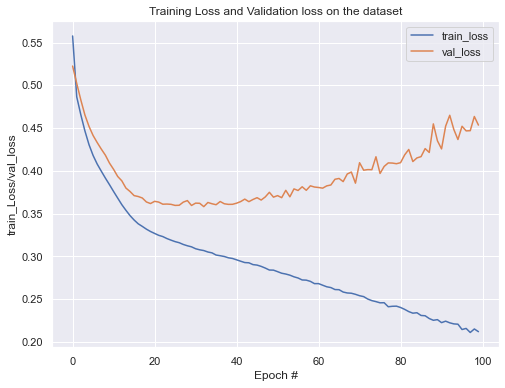

Accuracy on training set :  0.902
Recall on training set :  0.6423562412342216
Precision on training set :  0.8388278388278388
F1 on training set :  0.7275615567911041


In [225]:
get_history_plot(100)
get_training_metrics(model3, X_train, y_train)

* We can see here that the training and validation loss quickly diverge and the validation loss starts to increase. The training data is fit very well, but the validation accuracy is not improving. 
* Let's try some strategies to reduce overfitting. The first thing that we will try is adding dropout.

### Model 4 Add drop out

In [226]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

# Defining the optimizer. We will use SGD, which is a Gradient Decent optimizer
optimizer = tf.keras.optimizers.SGD(0.01)  

# Compile the model
model4.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [227]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 100)               1200      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 25)               

In [228]:
EPOCHS = 100 # define epochs
history = model4.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2,) # fit model

Epoch 1/100
175/175 - 0s - loss: 0.5948 - accuracy: 0.7212 - val_loss: 0.5382 - val_accuracy: 0.7807
Epoch 2/100
175/175 - 0s - loss: 0.5262 - accuracy: 0.7986 - val_loss: 0.5235 - val_accuracy: 0.7807
Epoch 3/100
175/175 - 0s - loss: 0.5156 - accuracy: 0.8002 - val_loss: 0.5154 - val_accuracy: 0.7807
Epoch 4/100
175/175 - 0s - loss: 0.5070 - accuracy: 0.8000 - val_loss: 0.5098 - val_accuracy: 0.7807
Epoch 5/100
175/175 - 0s - loss: 0.4981 - accuracy: 0.8004 - val_loss: 0.5047 - val_accuracy: 0.7807
Epoch 6/100
175/175 - 0s - loss: 0.4953 - accuracy: 0.8005 - val_loss: 0.5001 - val_accuracy: 0.7807
Epoch 7/100
175/175 - 0s - loss: 0.4946 - accuracy: 0.8000 - val_loss: 0.4975 - val_accuracy: 0.7807
Epoch 8/100
175/175 - 0s - loss: 0.4900 - accuracy: 0.8009 - val_loss: 0.4922 - val_accuracy: 0.7807
Epoch 9/100
175/175 - 0s - loss: 0.4877 - accuracy: 0.8002 - val_loss: 0.4893 - val_accuracy: 0.7807
Epoch 10/100
175/175 - 0s - loss: 0.4824 - accuracy: 0.7998 - val_loss: 0.4851 - val_accura

Epoch 82/100
175/175 - 0s - loss: 0.3850 - accuracy: 0.8327 - val_loss: 0.3835 - val_accuracy: 0.8450
Epoch 83/100
175/175 - 0s - loss: 0.3779 - accuracy: 0.8343 - val_loss: 0.3823 - val_accuracy: 0.8471
Epoch 84/100
175/175 - 0s - loss: 0.3900 - accuracy: 0.8307 - val_loss: 0.3823 - val_accuracy: 0.8450
Epoch 85/100
175/175 - 0s - loss: 0.3831 - accuracy: 0.8318 - val_loss: 0.3816 - val_accuracy: 0.8450
Epoch 86/100
175/175 - 0s - loss: 0.3782 - accuracy: 0.8346 - val_loss: 0.3807 - val_accuracy: 0.8471
Epoch 87/100
175/175 - 0s - loss: 0.3857 - accuracy: 0.8357 - val_loss: 0.3810 - val_accuracy: 0.8457
Epoch 88/100
175/175 - 0s - loss: 0.3809 - accuracy: 0.8329 - val_loss: 0.3810 - val_accuracy: 0.8450
Epoch 89/100
175/175 - 0s - loss: 0.3834 - accuracy: 0.8302 - val_loss: 0.3800 - val_accuracy: 0.8471
Epoch 90/100
175/175 - 0s - loss: 0.3763 - accuracy: 0.8345 - val_loss: 0.3785 - val_accuracy: 0.8471
Epoch 91/100
175/175 - 0s - loss: 0.3860 - accuracy: 0.8329 - val_loss: 0.3786 - v

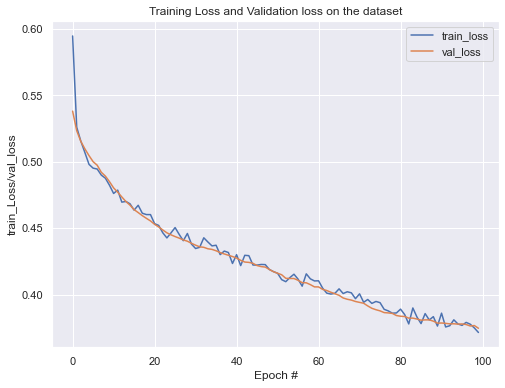

Accuracy on training set :  0.852
Recall on training set :  0.3394109396914446
Precision on training set :  0.8373702422145328
F1 on training set :  0.48303393213572854


In [229]:
get_history_plot(100)
get_training_metrics(model4, X_train, y_train)

* Adding dropout seems to have fixed the overfitting problem.
* It now appears that 100 epochs is not enough, as the training and validation loss are still falling when we finish the training. Let's attempt first to increase the learning rate. If that doesn't work we will increase the number of epochs.

### Model 5 - Increase learning rate

In [230]:
model5 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

# Defining the optimizer. We will use SGD, which is a Gradient Decent optimizer
optimizer = tf.keras.optimizers.SGD(0.05)  

# Compile the model
model5.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [231]:
EPOCHS = 100 # define epochs
history = model5.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2,) # fit model

Epoch 1/100
175/175 - 1s - loss: 0.5387 - accuracy: 0.7821 - val_loss: 0.5243 - val_accuracy: 0.7807
Epoch 2/100
175/175 - 0s - loss: 0.4956 - accuracy: 0.8002 - val_loss: 0.5006 - val_accuracy: 0.7807
Epoch 3/100
175/175 - 0s - loss: 0.4850 - accuracy: 0.8002 - val_loss: 0.4830 - val_accuracy: 0.7807
Epoch 4/100
175/175 - 0s - loss: 0.4679 - accuracy: 0.8012 - val_loss: 0.4657 - val_accuracy: 0.7807
Epoch 5/100
175/175 - 0s - loss: 0.4644 - accuracy: 0.7987 - val_loss: 0.4571 - val_accuracy: 0.7807
Epoch 6/100
175/175 - 0s - loss: 0.4529 - accuracy: 0.8021 - val_loss: 0.4451 - val_accuracy: 0.7821
Epoch 7/100
175/175 - 0s - loss: 0.4434 - accuracy: 0.8023 - val_loss: 0.4411 - val_accuracy: 0.7836
Epoch 8/100
175/175 - 0s - loss: 0.4450 - accuracy: 0.8027 - val_loss: 0.4360 - val_accuracy: 0.7921
Epoch 9/100
175/175 - 0s - loss: 0.4339 - accuracy: 0.8087 - val_loss: 0.4314 - val_accuracy: 0.7971
Epoch 10/100
175/175 - 0s - loss: 0.4305 - accuracy: 0.8079 - val_loss: 0.4250 - val_accura

Epoch 82/100
175/175 - 0s - loss: 0.3345 - accuracy: 0.8604 - val_loss: 0.3569 - val_accuracy: 0.8529
Epoch 83/100
175/175 - 0s - loss: 0.3308 - accuracy: 0.8662 - val_loss: 0.3565 - val_accuracy: 0.8521
Epoch 84/100
175/175 - 0s - loss: 0.3306 - accuracy: 0.8673 - val_loss: 0.3559 - val_accuracy: 0.8521
Epoch 85/100
175/175 - 0s - loss: 0.3377 - accuracy: 0.8577 - val_loss: 0.3592 - val_accuracy: 0.8493
Epoch 86/100
175/175 - 0s - loss: 0.3311 - accuracy: 0.8645 - val_loss: 0.3586 - val_accuracy: 0.8507
Epoch 87/100
175/175 - 0s - loss: 0.3337 - accuracy: 0.8616 - val_loss: 0.3572 - val_accuracy: 0.8543
Epoch 88/100
175/175 - 0s - loss: 0.3366 - accuracy: 0.8607 - val_loss: 0.3606 - val_accuracy: 0.8521
Epoch 89/100
175/175 - 0s - loss: 0.3301 - accuracy: 0.8625 - val_loss: 0.3577 - val_accuracy: 0.8493
Epoch 90/100
175/175 - 0s - loss: 0.3376 - accuracy: 0.8595 - val_loss: 0.3584 - val_accuracy: 0.8543
Epoch 91/100
175/175 - 0s - loss: 0.3350 - accuracy: 0.8657 - val_loss: 0.3595 - v

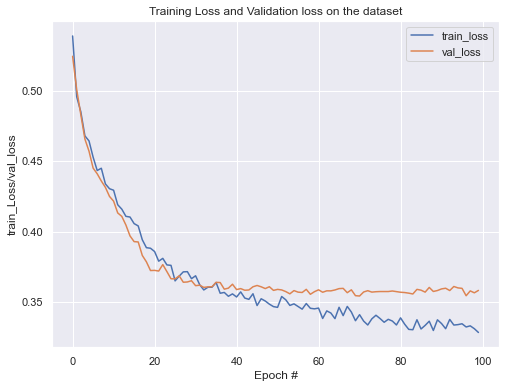

Accuracy on training set :  0.8718571428571429
Recall on training set :  0.5042075736325385
Precision on training set :  0.7909790979097909
F1 on training set :  0.6158458244111349


In [232]:
get_history_plot(100)
get_training_metrics(model5, X_train, y_train)

* Increasing the learning rate does not appear to have worked. We get the problem of overfitting again. We will reduce the learning rate again and attempt to increase the number of epochs.

### Model 6 - Increase number of epochs

In [233]:
model6 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

# Defining the optimizer. We will use SGD, which is a Gradient Decent optimizer
optimizer = tf.keras.optimizers.SGD(0.01)  

# Compile the model
model6.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [234]:
EPOCHS = 500 # define epochs
history = model6.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2,) # fit model

Epoch 1/500
175/175 - 0s - loss: 0.5610 - accuracy: 0.7798 - val_loss: 0.5455 - val_accuracy: 0.7807
Epoch 2/500
175/175 - 0s - loss: 0.5186 - accuracy: 0.8000 - val_loss: 0.5260 - val_accuracy: 0.7807
Epoch 3/500
175/175 - 0s - loss: 0.5168 - accuracy: 0.7998 - val_loss: 0.5159 - val_accuracy: 0.7807
Epoch 4/500
175/175 - 0s - loss: 0.5006 - accuracy: 0.8000 - val_loss: 0.5074 - val_accuracy: 0.7807
Epoch 5/500
175/175 - 0s - loss: 0.4965 - accuracy: 0.8002 - val_loss: 0.5019 - val_accuracy: 0.7807
Epoch 6/500
175/175 - 0s - loss: 0.4936 - accuracy: 0.8000 - val_loss: 0.4960 - val_accuracy: 0.7807
Epoch 7/500
175/175 - 0s - loss: 0.4919 - accuracy: 0.8002 - val_loss: 0.4925 - val_accuracy: 0.7807
Epoch 8/500
175/175 - 0s - loss: 0.4866 - accuracy: 0.8004 - val_loss: 0.4884 - val_accuracy: 0.7807
Epoch 9/500
175/175 - 0s - loss: 0.4821 - accuracy: 0.8000 - val_loss: 0.4832 - val_accuracy: 0.7807
Epoch 10/500
175/175 - 0s - loss: 0.4819 - accuracy: 0.8002 - val_loss: 0.4791 - val_accura

Epoch 82/500
175/175 - 0s - loss: 0.3945 - accuracy: 0.8318 - val_loss: 0.3928 - val_accuracy: 0.8514
Epoch 83/500
175/175 - 0s - loss: 0.3934 - accuracy: 0.8273 - val_loss: 0.3921 - val_accuracy: 0.8500
Epoch 84/500
175/175 - 0s - loss: 0.3963 - accuracy: 0.8243 - val_loss: 0.3915 - val_accuracy: 0.8514
Epoch 85/500
175/175 - 0s - loss: 0.3891 - accuracy: 0.8339 - val_loss: 0.3903 - val_accuracy: 0.8521
Epoch 86/500
175/175 - 0s - loss: 0.3934 - accuracy: 0.8275 - val_loss: 0.3892 - val_accuracy: 0.8529
Epoch 87/500
175/175 - 0s - loss: 0.3946 - accuracy: 0.8284 - val_loss: 0.3885 - val_accuracy: 0.8521
Epoch 88/500
175/175 - 0s - loss: 0.3967 - accuracy: 0.8284 - val_loss: 0.3877 - val_accuracy: 0.8521
Epoch 89/500
175/175 - 0s - loss: 0.3937 - accuracy: 0.8280 - val_loss: 0.3876 - val_accuracy: 0.8514
Epoch 90/500
175/175 - 0s - loss: 0.3986 - accuracy: 0.8221 - val_loss: 0.3870 - val_accuracy: 0.8521
Epoch 91/500
175/175 - 0s - loss: 0.3950 - accuracy: 0.8236 - val_loss: 0.3861 - v

Epoch 162/500
175/175 - 0s - loss: 0.3559 - accuracy: 0.8548 - val_loss: 0.3638 - val_accuracy: 0.8600
Epoch 163/500
175/175 - 0s - loss: 0.3602 - accuracy: 0.8479 - val_loss: 0.3635 - val_accuracy: 0.8614
Epoch 164/500
175/175 - 0s - loss: 0.3584 - accuracy: 0.8471 - val_loss: 0.3639 - val_accuracy: 0.8600
Epoch 165/500
175/175 - 0s - loss: 0.3571 - accuracy: 0.8525 - val_loss: 0.3641 - val_accuracy: 0.8579
Epoch 166/500
175/175 - 0s - loss: 0.3520 - accuracy: 0.8496 - val_loss: 0.3636 - val_accuracy: 0.8579
Epoch 167/500
175/175 - 0s - loss: 0.3548 - accuracy: 0.8459 - val_loss: 0.3631 - val_accuracy: 0.8593
Epoch 168/500
175/175 - 0s - loss: 0.3519 - accuracy: 0.8530 - val_loss: 0.3628 - val_accuracy: 0.8586
Epoch 169/500
175/175 - 0s - loss: 0.3587 - accuracy: 0.8502 - val_loss: 0.3629 - val_accuracy: 0.8571
Epoch 170/500
175/175 - 0s - loss: 0.3558 - accuracy: 0.8536 - val_loss: 0.3631 - val_accuracy: 0.8586
Epoch 171/500
175/175 - 0s - loss: 0.3543 - accuracy: 0.8504 - val_loss: 

Epoch 242/500
175/175 - 0s - loss: 0.3408 - accuracy: 0.8562 - val_loss: 0.3593 - val_accuracy: 0.8579
Epoch 243/500
175/175 - 0s - loss: 0.3461 - accuracy: 0.8548 - val_loss: 0.3593 - val_accuracy: 0.8564
Epoch 244/500
175/175 - 0s - loss: 0.3473 - accuracy: 0.8562 - val_loss: 0.3592 - val_accuracy: 0.8571
Epoch 245/500
175/175 - 0s - loss: 0.3410 - accuracy: 0.8580 - val_loss: 0.3591 - val_accuracy: 0.8571
Epoch 246/500
175/175 - 0s - loss: 0.3452 - accuracy: 0.8577 - val_loss: 0.3595 - val_accuracy: 0.8564
Epoch 247/500
175/175 - 0s - loss: 0.3410 - accuracy: 0.8584 - val_loss: 0.3584 - val_accuracy: 0.8529
Epoch 248/500
175/175 - 0s - loss: 0.3428 - accuracy: 0.8525 - val_loss: 0.3586 - val_accuracy: 0.8543
Epoch 249/500
175/175 - 0s - loss: 0.3382 - accuracy: 0.8621 - val_loss: 0.3582 - val_accuracy: 0.8557
Epoch 250/500
175/175 - 0s - loss: 0.3436 - accuracy: 0.8541 - val_loss: 0.3582 - val_accuracy: 0.8529
Epoch 251/500
175/175 - 0s - loss: 0.3431 - accuracy: 0.8612 - val_loss: 

Epoch 322/500
175/175 - 0s - loss: 0.3332 - accuracy: 0.8632 - val_loss: 0.3564 - val_accuracy: 0.8543
Epoch 323/500
175/175 - 0s - loss: 0.3368 - accuracy: 0.8602 - val_loss: 0.3572 - val_accuracy: 0.8536
Epoch 324/500
175/175 - 0s - loss: 0.3326 - accuracy: 0.8662 - val_loss: 0.3571 - val_accuracy: 0.8521
Epoch 325/500
175/175 - 0s - loss: 0.3324 - accuracy: 0.8657 - val_loss: 0.3571 - val_accuracy: 0.8543
Epoch 326/500
175/175 - 0s - loss: 0.3360 - accuracy: 0.8611 - val_loss: 0.3572 - val_accuracy: 0.8550
Epoch 327/500
175/175 - 0s - loss: 0.3370 - accuracy: 0.8612 - val_loss: 0.3572 - val_accuracy: 0.8557
Epoch 328/500
175/175 - 0s - loss: 0.3332 - accuracy: 0.8621 - val_loss: 0.3572 - val_accuracy: 0.8536
Epoch 329/500
175/175 - 0s - loss: 0.3351 - accuracy: 0.8666 - val_loss: 0.3570 - val_accuracy: 0.8543
Epoch 330/500
175/175 - 0s - loss: 0.3365 - accuracy: 0.8618 - val_loss: 0.3573 - val_accuracy: 0.8536
Epoch 331/500
175/175 - 0s - loss: 0.3349 - accuracy: 0.8655 - val_loss: 

Epoch 402/500
175/175 - 0s - loss: 0.3333 - accuracy: 0.8605 - val_loss: 0.3573 - val_accuracy: 0.8493
Epoch 403/500
175/175 - 0s - loss: 0.3273 - accuracy: 0.8641 - val_loss: 0.3575 - val_accuracy: 0.8500
Epoch 404/500
175/175 - 0s - loss: 0.3283 - accuracy: 0.8659 - val_loss: 0.3574 - val_accuracy: 0.8507
Epoch 405/500
175/175 - 0s - loss: 0.3260 - accuracy: 0.8677 - val_loss: 0.3570 - val_accuracy: 0.8507
Epoch 406/500
175/175 - 0s - loss: 0.3281 - accuracy: 0.8625 - val_loss: 0.3572 - val_accuracy: 0.8521
Epoch 407/500
175/175 - 0s - loss: 0.3266 - accuracy: 0.8684 - val_loss: 0.3569 - val_accuracy: 0.8507
Epoch 408/500
175/175 - 0s - loss: 0.3323 - accuracy: 0.8620 - val_loss: 0.3564 - val_accuracy: 0.8507
Epoch 409/500
175/175 - 0s - loss: 0.3242 - accuracy: 0.8680 - val_loss: 0.3566 - val_accuracy: 0.8529
Epoch 410/500
175/175 - 0s - loss: 0.3270 - accuracy: 0.8636 - val_loss: 0.3571 - val_accuracy: 0.8536
Epoch 411/500
175/175 - 0s - loss: 0.3252 - accuracy: 0.8648 - val_loss: 

Epoch 482/500
175/175 - 0s - loss: 0.3244 - accuracy: 0.8695 - val_loss: 0.3574 - val_accuracy: 0.8536
Epoch 483/500
175/175 - 0s - loss: 0.3233 - accuracy: 0.8659 - val_loss: 0.3569 - val_accuracy: 0.8529
Epoch 484/500
175/175 - 0s - loss: 0.3255 - accuracy: 0.8695 - val_loss: 0.3574 - val_accuracy: 0.8514
Epoch 485/500
175/175 - 0s - loss: 0.3227 - accuracy: 0.8662 - val_loss: 0.3577 - val_accuracy: 0.8550
Epoch 486/500
175/175 - 0s - loss: 0.3216 - accuracy: 0.8709 - val_loss: 0.3573 - val_accuracy: 0.8543
Epoch 487/500
175/175 - 0s - loss: 0.3226 - accuracy: 0.8659 - val_loss: 0.3575 - val_accuracy: 0.8521
Epoch 488/500
175/175 - 0s - loss: 0.3214 - accuracy: 0.8636 - val_loss: 0.3575 - val_accuracy: 0.8514
Epoch 489/500
175/175 - 0s - loss: 0.3287 - accuracy: 0.8639 - val_loss: 0.3576 - val_accuracy: 0.8514
Epoch 490/500
175/175 - 0s - loss: 0.3211 - accuracy: 0.8693 - val_loss: 0.3571 - val_accuracy: 0.8536
Epoch 491/500
175/175 - 0s - loss: 0.3205 - accuracy: 0.8700 - val_loss: 

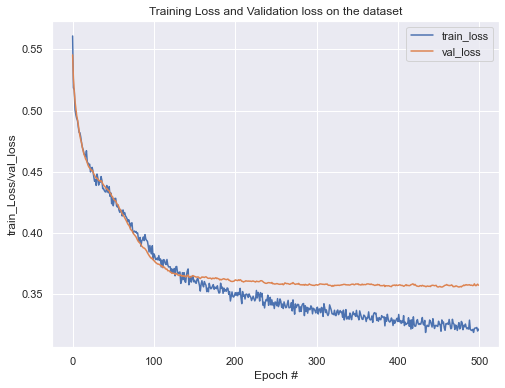

Accuracy on training set :  0.8724285714285714
Recall on training set :  0.5252454417952315
Precision on training set :  0.7761658031088083
F1 on training set :  0.6265161020493517


In [235]:
get_history_plot(500)
get_training_metrics(model6, X_train, y_train)

* It appears that, just after 100 epochs, the training and validation loss start to diverge.
* Given, the process has random starting weights, I've run it multiple times and gotten different results. However, on most the divergence starts at about 100.
* Furthermore after 500 epochs, we are still not getting a perfect fit to our training data. This model does not do better than our much simpler starting model. So let's reduce the complexity of the model again and try a single dropout to reduce overfitting.

### Model 7 - Reduce complexity with dropout

In [236]:
model7 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

# Defining the optimizer. We will use SGD, which is a Gradient Decent optimizer
optimizer = tf.keras.optimizers.SGD(0.01)  

# Compile the model
model7.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [237]:
EPOCHS = 100 # define epochs
history = model7.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2,) # fit model

Epoch 1/100
175/175 - 0s - loss: 0.5424 - accuracy: 0.7713 - val_loss: 0.5043 - val_accuracy: 0.7807
Epoch 2/100
175/175 - 0s - loss: 0.4948 - accuracy: 0.7987 - val_loss: 0.4862 - val_accuracy: 0.7807
Epoch 3/100
175/175 - 0s - loss: 0.4855 - accuracy: 0.8011 - val_loss: 0.4759 - val_accuracy: 0.7807
Epoch 4/100
175/175 - 0s - loss: 0.4750 - accuracy: 0.7984 - val_loss: 0.4682 - val_accuracy: 0.7807
Epoch 5/100
175/175 - 0s - loss: 0.4678 - accuracy: 0.8025 - val_loss: 0.4625 - val_accuracy: 0.7843
Epoch 6/100
175/175 - 0s - loss: 0.4673 - accuracy: 0.8014 - val_loss: 0.4587 - val_accuracy: 0.7864
Epoch 7/100
175/175 - 0s - loss: 0.4633 - accuracy: 0.8011 - val_loss: 0.4554 - val_accuracy: 0.7893
Epoch 8/100
175/175 - 0s - loss: 0.4556 - accuracy: 0.8041 - val_loss: 0.4521 - val_accuracy: 0.7907
Epoch 9/100
175/175 - 0s - loss: 0.4522 - accuracy: 0.8046 - val_loss: 0.4495 - val_accuracy: 0.7936
Epoch 10/100
175/175 - 0s - loss: 0.4522 - accuracy: 0.8012 - val_loss: 0.4470 - val_accura

Epoch 82/100
175/175 - 0s - loss: 0.3744 - accuracy: 0.8432 - val_loss: 0.3689 - val_accuracy: 0.8500
Epoch 83/100
175/175 - 0s - loss: 0.3750 - accuracy: 0.8396 - val_loss: 0.3682 - val_accuracy: 0.8500
Epoch 84/100
175/175 - 0s - loss: 0.3718 - accuracy: 0.8373 - val_loss: 0.3677 - val_accuracy: 0.8500
Epoch 85/100
175/175 - 0s - loss: 0.3747 - accuracy: 0.8373 - val_loss: 0.3676 - val_accuracy: 0.8500
Epoch 86/100
175/175 - 0s - loss: 0.3666 - accuracy: 0.8430 - val_loss: 0.3669 - val_accuracy: 0.8493
Epoch 87/100
175/175 - 0s - loss: 0.3682 - accuracy: 0.8434 - val_loss: 0.3663 - val_accuracy: 0.8521
Epoch 88/100
175/175 - 0s - loss: 0.3643 - accuracy: 0.8434 - val_loss: 0.3660 - val_accuracy: 0.8529
Epoch 89/100
175/175 - 0s - loss: 0.3622 - accuracy: 0.8466 - val_loss: 0.3663 - val_accuracy: 0.8507
Epoch 90/100
175/175 - 0s - loss: 0.3715 - accuracy: 0.8423 - val_loss: 0.3665 - val_accuracy: 0.8486
Epoch 91/100
175/175 - 0s - loss: 0.3701 - accuracy: 0.8434 - val_loss: 0.3662 - v

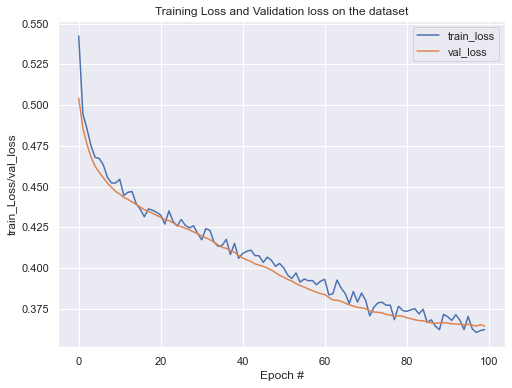

Accuracy on training set :  0.858
Recall on training set :  0.39691444600280507
Precision on training set :  0.8085714285714286
F1 on training set :  0.5324553151458138


In [238]:
get_history_plot(100)
get_training_metrics(model7, X_train, y_train)

* With a much simplier model, we are still getting about the same accuracy as with the complex models. It appears that loss is still falling as we reach 100 epochs, so let's try adding more epochs.

### Model 8 - Repeat Model 7, just with more epochs

In [239]:
model8 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

# Defining the optimizer. We will use SGD, which is a Gradient Decent optimizer
optimizer = tf.keras.optimizers.SGD(0.01)  

# Compile the model
model8.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [240]:
EPOCHS = 500 # define epochs
history = model8.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2,) # fit model

Epoch 1/500
175/175 - 0s - loss: 0.5887 - accuracy: 0.7336 - val_loss: 0.5253 - val_accuracy: 0.7807
Epoch 2/500
175/175 - 0s - loss: 0.5241 - accuracy: 0.7939 - val_loss: 0.5041 - val_accuracy: 0.7807
Epoch 3/500
175/175 - 0s - loss: 0.5073 - accuracy: 0.7934 - val_loss: 0.4915 - val_accuracy: 0.7807
Epoch 4/500
175/175 - 0s - loss: 0.4888 - accuracy: 0.7982 - val_loss: 0.4829 - val_accuracy: 0.7800
Epoch 5/500
175/175 - 0s - loss: 0.4834 - accuracy: 0.7968 - val_loss: 0.4773 - val_accuracy: 0.7800
Epoch 6/500
175/175 - 0s - loss: 0.4820 - accuracy: 0.7998 - val_loss: 0.4714 - val_accuracy: 0.7814
Epoch 7/500
175/175 - 0s - loss: 0.4772 - accuracy: 0.7970 - val_loss: 0.4672 - val_accuracy: 0.7814
Epoch 8/500
175/175 - 0s - loss: 0.4688 - accuracy: 0.8027 - val_loss: 0.4635 - val_accuracy: 0.7821
Epoch 9/500
175/175 - 0s - loss: 0.4617 - accuracy: 0.8036 - val_loss: 0.4609 - val_accuracy: 0.7857
Epoch 10/500
175/175 - 0s - loss: 0.4595 - accuracy: 0.8005 - val_loss: 0.4579 - val_accura

Epoch 82/500
175/175 - 0s - loss: 0.3819 - accuracy: 0.8364 - val_loss: 0.3765 - val_accuracy: 0.8436
Epoch 83/500
175/175 - 0s - loss: 0.3799 - accuracy: 0.8336 - val_loss: 0.3755 - val_accuracy: 0.8450
Epoch 84/500
175/175 - 0s - loss: 0.3765 - accuracy: 0.8357 - val_loss: 0.3753 - val_accuracy: 0.8450
Epoch 85/500
175/175 - 0s - loss: 0.3800 - accuracy: 0.8379 - val_loss: 0.3753 - val_accuracy: 0.8443
Epoch 86/500
175/175 - 0s - loss: 0.3817 - accuracy: 0.8380 - val_loss: 0.3754 - val_accuracy: 0.8429
Epoch 87/500
175/175 - 0s - loss: 0.3773 - accuracy: 0.8407 - val_loss: 0.3739 - val_accuracy: 0.8450
Epoch 88/500
175/175 - 0s - loss: 0.3685 - accuracy: 0.8416 - val_loss: 0.3726 - val_accuracy: 0.8443
Epoch 89/500
175/175 - 0s - loss: 0.3738 - accuracy: 0.8414 - val_loss: 0.3724 - val_accuracy: 0.8450
Epoch 90/500
175/175 - 0s - loss: 0.3738 - accuracy: 0.8409 - val_loss: 0.3726 - val_accuracy: 0.8443
Epoch 91/500
175/175 - 0s - loss: 0.3676 - accuracy: 0.8396 - val_loss: 0.3723 - v

Epoch 162/500
175/175 - 0s - loss: 0.3527 - accuracy: 0.8523 - val_loss: 0.3635 - val_accuracy: 0.8479
Epoch 163/500
175/175 - 0s - loss: 0.3559 - accuracy: 0.8486 - val_loss: 0.3645 - val_accuracy: 0.8479
Epoch 164/500
175/175 - 0s - loss: 0.3591 - accuracy: 0.8486 - val_loss: 0.3644 - val_accuracy: 0.8507
Epoch 165/500
175/175 - 0s - loss: 0.3580 - accuracy: 0.8507 - val_loss: 0.3641 - val_accuracy: 0.8500
Epoch 166/500
175/175 - 0s - loss: 0.3502 - accuracy: 0.8495 - val_loss: 0.3633 - val_accuracy: 0.8500
Epoch 167/500
175/175 - 0s - loss: 0.3530 - accuracy: 0.8512 - val_loss: 0.3625 - val_accuracy: 0.8500
Epoch 168/500
175/175 - 0s - loss: 0.3558 - accuracy: 0.8539 - val_loss: 0.3629 - val_accuracy: 0.8493
Epoch 169/500
175/175 - 0s - loss: 0.3471 - accuracy: 0.8512 - val_loss: 0.3632 - val_accuracy: 0.8507
Epoch 170/500
175/175 - 0s - loss: 0.3493 - accuracy: 0.8546 - val_loss: 0.3629 - val_accuracy: 0.8500
Epoch 171/500
175/175 - 0s - loss: 0.3521 - accuracy: 0.8532 - val_loss: 

Epoch 242/500
175/175 - 0s - loss: 0.3464 - accuracy: 0.8548 - val_loss: 0.3618 - val_accuracy: 0.8543
Epoch 243/500
175/175 - 0s - loss: 0.3487 - accuracy: 0.8562 - val_loss: 0.3618 - val_accuracy: 0.8543
Epoch 244/500
175/175 - 0s - loss: 0.3412 - accuracy: 0.8593 - val_loss: 0.3617 - val_accuracy: 0.8557
Epoch 245/500
175/175 - 0s - loss: 0.3417 - accuracy: 0.8587 - val_loss: 0.3613 - val_accuracy: 0.8557
Epoch 246/500
175/175 - 0s - loss: 0.3380 - accuracy: 0.8584 - val_loss: 0.3622 - val_accuracy: 0.8543
Epoch 247/500
175/175 - 0s - loss: 0.3481 - accuracy: 0.8561 - val_loss: 0.3611 - val_accuracy: 0.8564
Epoch 248/500
175/175 - 0s - loss: 0.3436 - accuracy: 0.8596 - val_loss: 0.3613 - val_accuracy: 0.8557
Epoch 249/500
175/175 - 0s - loss: 0.3402 - accuracy: 0.8591 - val_loss: 0.3611 - val_accuracy: 0.8543
Epoch 250/500
175/175 - 0s - loss: 0.3417 - accuracy: 0.8566 - val_loss: 0.3616 - val_accuracy: 0.8564
Epoch 251/500
175/175 - 0s - loss: 0.3394 - accuracy: 0.8566 - val_loss: 

Epoch 322/500
175/175 - 0s - loss: 0.3352 - accuracy: 0.8652 - val_loss: 0.3598 - val_accuracy: 0.8514
Epoch 323/500
175/175 - 0s - loss: 0.3366 - accuracy: 0.8586 - val_loss: 0.3607 - val_accuracy: 0.8514
Epoch 324/500
175/175 - 0s - loss: 0.3407 - accuracy: 0.8591 - val_loss: 0.3605 - val_accuracy: 0.8514
Epoch 325/500
175/175 - 0s - loss: 0.3388 - accuracy: 0.8587 - val_loss: 0.3604 - val_accuracy: 0.8529
Epoch 326/500
175/175 - 0s - loss: 0.3386 - accuracy: 0.8612 - val_loss: 0.3613 - val_accuracy: 0.8521
Epoch 327/500
175/175 - 0s - loss: 0.3407 - accuracy: 0.8591 - val_loss: 0.3609 - val_accuracy: 0.8536
Epoch 328/500
175/175 - 0s - loss: 0.3371 - accuracy: 0.8577 - val_loss: 0.3607 - val_accuracy: 0.8543
Epoch 329/500
175/175 - 0s - loss: 0.3398 - accuracy: 0.8571 - val_loss: 0.3609 - val_accuracy: 0.8529
Epoch 330/500
175/175 - 0s - loss: 0.3356 - accuracy: 0.8652 - val_loss: 0.3613 - val_accuracy: 0.8521
Epoch 331/500
175/175 - 0s - loss: 0.3356 - accuracy: 0.8648 - val_loss: 

Epoch 402/500
175/175 - 0s - loss: 0.3331 - accuracy: 0.8620 - val_loss: 0.3593 - val_accuracy: 0.8529
Epoch 403/500
175/175 - 0s - loss: 0.3326 - accuracy: 0.8596 - val_loss: 0.3603 - val_accuracy: 0.8536
Epoch 404/500
175/175 - 0s - loss: 0.3318 - accuracy: 0.8643 - val_loss: 0.3594 - val_accuracy: 0.8529
Epoch 405/500
175/175 - 0s - loss: 0.3341 - accuracy: 0.8598 - val_loss: 0.3593 - val_accuracy: 0.8521
Epoch 406/500
175/175 - 0s - loss: 0.3321 - accuracy: 0.8654 - val_loss: 0.3590 - val_accuracy: 0.8521
Epoch 407/500
175/175 - 0s - loss: 0.3286 - accuracy: 0.8636 - val_loss: 0.3588 - val_accuracy: 0.8536
Epoch 408/500
175/175 - 0s - loss: 0.3287 - accuracy: 0.8657 - val_loss: 0.3587 - val_accuracy: 0.8521
Epoch 409/500
175/175 - 0s - loss: 0.3319 - accuracy: 0.8627 - val_loss: 0.3591 - val_accuracy: 0.8536
Epoch 410/500
175/175 - 0s - loss: 0.3297 - accuracy: 0.8664 - val_loss: 0.3597 - val_accuracy: 0.8536
Epoch 411/500
175/175 - 0s - loss: 0.3289 - accuracy: 0.8645 - val_loss: 

Epoch 482/500
175/175 - 0s - loss: 0.3233 - accuracy: 0.8659 - val_loss: 0.3583 - val_accuracy: 0.8529
Epoch 483/500
175/175 - 0s - loss: 0.3301 - accuracy: 0.8680 - val_loss: 0.3582 - val_accuracy: 0.8543
Epoch 484/500
175/175 - 0s - loss: 0.3271 - accuracy: 0.8641 - val_loss: 0.3588 - val_accuracy: 0.8529
Epoch 485/500
175/175 - 0s - loss: 0.3256 - accuracy: 0.8646 - val_loss: 0.3583 - val_accuracy: 0.8536
Epoch 486/500
175/175 - 0s - loss: 0.3253 - accuracy: 0.8621 - val_loss: 0.3594 - val_accuracy: 0.8521
Epoch 487/500
175/175 - 0s - loss: 0.3302 - accuracy: 0.8605 - val_loss: 0.3602 - val_accuracy: 0.8550
Epoch 488/500
175/175 - 0s - loss: 0.3292 - accuracy: 0.8605 - val_loss: 0.3602 - val_accuracy: 0.8557
Epoch 489/500
175/175 - 0s - loss: 0.3260 - accuracy: 0.8654 - val_loss: 0.3597 - val_accuracy: 0.8536
Epoch 490/500
175/175 - 0s - loss: 0.3252 - accuracy: 0.8670 - val_loss: 0.3588 - val_accuracy: 0.8543
Epoch 491/500
175/175 - 0s - loss: 0.3299 - accuracy: 0.8604 - val_loss: 

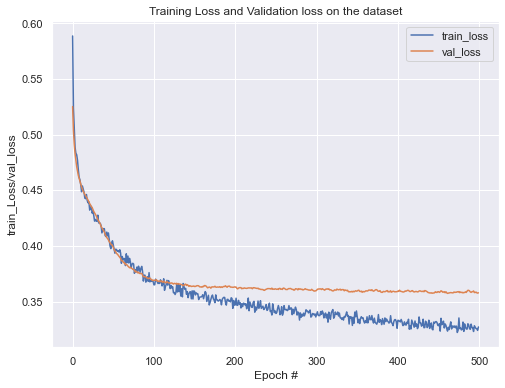

Accuracy on training set :  0.8717142857142857
Recall on training set :  0.4684431977559607
Precision on training set :  0.8267326732673267
F1 on training set :  0.5980304386750224


In [241]:
get_history_plot(500)
get_training_metrics(model8, X_train, y_train)

* Once again, the training and validation loss start to diverge somewhere between 100 and 200 epochs.
* We are still not getting a very good accuracy for our training and validation data.
* Obviously we need to change something. Let's try the optimization algorithm

### Model 9 - Adam optimization

In [242]:
model9 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

# Defining the optimizer.
optimizer = tf.keras.optimizers.Adam(0.01)  

# Compile the model
model9.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [243]:
EPOCHS = 100 # define epochs
history = model9.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2,) # fit model

Epoch 1/100
175/175 - 0s - loss: 0.4561 - accuracy: 0.8027 - val_loss: 0.4195 - val_accuracy: 0.8357
Epoch 2/100
175/175 - 0s - loss: 0.4008 - accuracy: 0.8320 - val_loss: 0.3878 - val_accuracy: 0.8157
Epoch 3/100
175/175 - 0s - loss: 0.3895 - accuracy: 0.8388 - val_loss: 0.3710 - val_accuracy: 0.8457
Epoch 4/100
175/175 - 0s - loss: 0.3787 - accuracy: 0.8436 - val_loss: 0.3927 - val_accuracy: 0.8221
Epoch 5/100
175/175 - 0s - loss: 0.3829 - accuracy: 0.8380 - val_loss: 0.3782 - val_accuracy: 0.8379
Epoch 6/100
175/175 - 0s - loss: 0.3759 - accuracy: 0.8389 - val_loss: 0.3715 - val_accuracy: 0.8436
Epoch 7/100
175/175 - 0s - loss: 0.3762 - accuracy: 0.8468 - val_loss: 0.3642 - val_accuracy: 0.8471
Epoch 8/100
175/175 - 0s - loss: 0.3736 - accuracy: 0.8443 - val_loss: 0.3566 - val_accuracy: 0.8521
Epoch 9/100
175/175 - 0s - loss: 0.3754 - accuracy: 0.8464 - val_loss: 0.3773 - val_accuracy: 0.8400
Epoch 10/100
175/175 - 0s - loss: 0.3727 - accuracy: 0.8434 - val_loss: 0.3739 - val_accura

Epoch 82/100
175/175 - 0s - loss: 0.3533 - accuracy: 0.8552 - val_loss: 0.3743 - val_accuracy: 0.8464
Epoch 83/100
175/175 - 0s - loss: 0.3456 - accuracy: 0.8541 - val_loss: 0.3800 - val_accuracy: 0.8429
Epoch 84/100
175/175 - 0s - loss: 0.3405 - accuracy: 0.8596 - val_loss: 0.3736 - val_accuracy: 0.8457
Epoch 85/100
175/175 - 0s - loss: 0.3434 - accuracy: 0.8570 - val_loss: 0.3699 - val_accuracy: 0.8486
Epoch 86/100
175/175 - 0s - loss: 0.3428 - accuracy: 0.8562 - val_loss: 0.3802 - val_accuracy: 0.8500
Epoch 87/100
175/175 - 0s - loss: 0.3447 - accuracy: 0.8566 - val_loss: 0.3807 - val_accuracy: 0.8507
Epoch 88/100
175/175 - 0s - loss: 0.3438 - accuracy: 0.8548 - val_loss: 0.3796 - val_accuracy: 0.8393
Epoch 89/100
175/175 - 0s - loss: 0.3534 - accuracy: 0.8529 - val_loss: 0.3795 - val_accuracy: 0.8443
Epoch 90/100
175/175 - 0s - loss: 0.3433 - accuracy: 0.8582 - val_loss: 0.3789 - val_accuracy: 0.8450
Epoch 91/100
175/175 - 0s - loss: 0.3476 - accuracy: 0.8543 - val_loss: 0.3760 - v

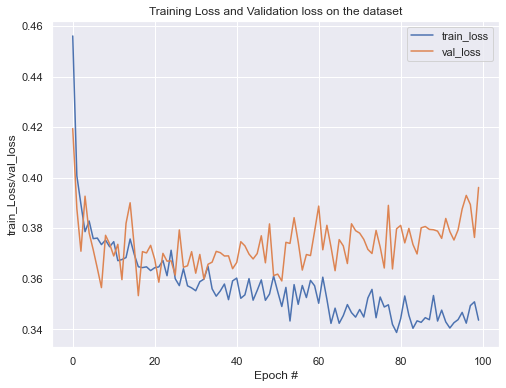

Accuracy on training set :  0.8628571428571429
Recall on training set :  0.3688639551192146
Precision on training set :  0.8976109215017065
F1 on training set :  0.5228628230616302


In [244]:
get_history_plot(100)
get_training_metrics(model9, X_train, y_train)

* It's pretty obvious that this optimizer is not the one for us.

### Model 10 - Adadelta optimization
I will be honest, I tried this a number of times... I've increased the learning rate and the number of epochs

In [245]:
model10 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

# Defining the optimizer.
optimizer = tf.keras.optimizers.Adadelta(0.05)  

# Compile the model
model10.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [246]:
EPOCHS = 500 # define epochs
history = model10.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2,) # fit model

Epoch 1/500
175/175 - 0s - loss: 0.5988 - accuracy: 0.7236 - val_loss: 0.5752 - val_accuracy: 0.7807
Epoch 2/500
175/175 - 0s - loss: 0.5650 - accuracy: 0.7714 - val_loss: 0.5450 - val_accuracy: 0.7807
Epoch 3/500
175/175 - 0s - loss: 0.5404 - accuracy: 0.7830 - val_loss: 0.5272 - val_accuracy: 0.7807
Epoch 4/500
175/175 - 0s - loss: 0.5265 - accuracy: 0.7932 - val_loss: 0.5156 - val_accuracy: 0.7807
Epoch 5/500
175/175 - 0s - loss: 0.5186 - accuracy: 0.7970 - val_loss: 0.5068 - val_accuracy: 0.7807
Epoch 6/500
175/175 - 0s - loss: 0.5148 - accuracy: 0.7973 - val_loss: 0.4995 - val_accuracy: 0.7807
Epoch 7/500
175/175 - 0s - loss: 0.4986 - accuracy: 0.7973 - val_loss: 0.4935 - val_accuracy: 0.7807
Epoch 8/500
175/175 - 0s - loss: 0.5003 - accuracy: 0.7993 - val_loss: 0.4885 - val_accuracy: 0.7807
Epoch 9/500
175/175 - 0s - loss: 0.4948 - accuracy: 0.7989 - val_loss: 0.4841 - val_accuracy: 0.7807
Epoch 10/500
175/175 - 0s - loss: 0.4870 - accuracy: 0.8000 - val_loss: 0.4803 - val_accura

Epoch 82/500
175/175 - 0s - loss: 0.4172 - accuracy: 0.8225 - val_loss: 0.4198 - val_accuracy: 0.8314
Epoch 83/500
175/175 - 0s - loss: 0.4202 - accuracy: 0.8243 - val_loss: 0.4193 - val_accuracy: 0.8314
Epoch 84/500
175/175 - 0s - loss: 0.4193 - accuracy: 0.8230 - val_loss: 0.4188 - val_accuracy: 0.8329
Epoch 85/500
175/175 - 0s - loss: 0.4086 - accuracy: 0.8223 - val_loss: 0.4185 - val_accuracy: 0.8329
Epoch 86/500
175/175 - 0s - loss: 0.4111 - accuracy: 0.8243 - val_loss: 0.4181 - val_accuracy: 0.8329
Epoch 87/500
175/175 - 0s - loss: 0.4211 - accuracy: 0.8196 - val_loss: 0.4176 - val_accuracy: 0.8336
Epoch 88/500
175/175 - 0s - loss: 0.4150 - accuracy: 0.8220 - val_loss: 0.4172 - val_accuracy: 0.8336
Epoch 89/500
175/175 - 0s - loss: 0.4132 - accuracy: 0.8218 - val_loss: 0.4168 - val_accuracy: 0.8343
Epoch 90/500
175/175 - 0s - loss: 0.4163 - accuracy: 0.8263 - val_loss: 0.4163 - val_accuracy: 0.8343
Epoch 91/500
175/175 - 0s - loss: 0.4168 - accuracy: 0.8220 - val_loss: 0.4160 - v

Epoch 162/500
175/175 - 0s - loss: 0.3944 - accuracy: 0.8314 - val_loss: 0.3881 - val_accuracy: 0.8529
Epoch 163/500
175/175 - 0s - loss: 0.3930 - accuracy: 0.8388 - val_loss: 0.3879 - val_accuracy: 0.8529
Epoch 164/500
175/175 - 0s - loss: 0.3827 - accuracy: 0.8386 - val_loss: 0.3877 - val_accuracy: 0.8529
Epoch 165/500
175/175 - 0s - loss: 0.3861 - accuracy: 0.8341 - val_loss: 0.3876 - val_accuracy: 0.8543
Epoch 166/500
175/175 - 0s - loss: 0.3915 - accuracy: 0.8345 - val_loss: 0.3873 - val_accuracy: 0.8543
Epoch 167/500
175/175 - 0s - loss: 0.3874 - accuracy: 0.8375 - val_loss: 0.3870 - val_accuracy: 0.8543
Epoch 168/500
175/175 - 0s - loss: 0.3874 - accuracy: 0.8363 - val_loss: 0.3866 - val_accuracy: 0.8557
Epoch 169/500
175/175 - 0s - loss: 0.3876 - accuracy: 0.8380 - val_loss: 0.3863 - val_accuracy: 0.8557
Epoch 170/500
175/175 - 0s - loss: 0.3839 - accuracy: 0.8425 - val_loss: 0.3859 - val_accuracy: 0.8550
Epoch 171/500
175/175 - 0s - loss: 0.3830 - accuracy: 0.8380 - val_loss: 

Epoch 242/500
175/175 - 0s - loss: 0.3633 - accuracy: 0.8511 - val_loss: 0.3698 - val_accuracy: 0.8536
Epoch 243/500
175/175 - 0s - loss: 0.3633 - accuracy: 0.8427 - val_loss: 0.3697 - val_accuracy: 0.8536
Epoch 244/500
175/175 - 0s - loss: 0.3725 - accuracy: 0.8452 - val_loss: 0.3695 - val_accuracy: 0.8536
Epoch 245/500
175/175 - 0s - loss: 0.3698 - accuracy: 0.8470 - val_loss: 0.3693 - val_accuracy: 0.8550
Epoch 246/500
175/175 - 0s - loss: 0.3684 - accuracy: 0.8423 - val_loss: 0.3692 - val_accuracy: 0.8536
Epoch 247/500
175/175 - 0s - loss: 0.3645 - accuracy: 0.8491 - val_loss: 0.3691 - val_accuracy: 0.8536
Epoch 248/500
175/175 - 0s - loss: 0.3667 - accuracy: 0.8487 - val_loss: 0.3688 - val_accuracy: 0.8543
Epoch 249/500
175/175 - 0s - loss: 0.3644 - accuracy: 0.8475 - val_loss: 0.3687 - val_accuracy: 0.8550
Epoch 250/500
175/175 - 0s - loss: 0.3676 - accuracy: 0.8473 - val_loss: 0.3687 - val_accuracy: 0.8543
Epoch 251/500
175/175 - 0s - loss: 0.3660 - accuracy: 0.8462 - val_loss: 

Epoch 322/500
175/175 - 0s - loss: 0.3652 - accuracy: 0.8557 - val_loss: 0.3637 - val_accuracy: 0.8550
Epoch 323/500
175/175 - 0s - loss: 0.3542 - accuracy: 0.8511 - val_loss: 0.3638 - val_accuracy: 0.8550
Epoch 324/500
175/175 - 0s - loss: 0.3607 - accuracy: 0.8545 - val_loss: 0.3636 - val_accuracy: 0.8550
Epoch 325/500
175/175 - 0s - loss: 0.3593 - accuracy: 0.8489 - val_loss: 0.3636 - val_accuracy: 0.8550
Epoch 326/500
175/175 - 0s - loss: 0.3572 - accuracy: 0.8527 - val_loss: 0.3636 - val_accuracy: 0.8543
Epoch 327/500
175/175 - 0s - loss: 0.3590 - accuracy: 0.8496 - val_loss: 0.3636 - val_accuracy: 0.8543
Epoch 328/500
175/175 - 0s - loss: 0.3598 - accuracy: 0.8477 - val_loss: 0.3635 - val_accuracy: 0.8543
Epoch 329/500
175/175 - 0s - loss: 0.3508 - accuracy: 0.8541 - val_loss: 0.3633 - val_accuracy: 0.8543
Epoch 330/500
175/175 - 0s - loss: 0.3577 - accuracy: 0.8537 - val_loss: 0.3634 - val_accuracy: 0.8550
Epoch 331/500
175/175 - 0s - loss: 0.3542 - accuracy: 0.8570 - val_loss: 

Epoch 402/500
175/175 - 0s - loss: 0.3520 - accuracy: 0.8564 - val_loss: 0.3624 - val_accuracy: 0.8543
Epoch 403/500
175/175 - 0s - loss: 0.3531 - accuracy: 0.8559 - val_loss: 0.3624 - val_accuracy: 0.8536
Epoch 404/500
175/175 - 0s - loss: 0.3527 - accuracy: 0.8543 - val_loss: 0.3623 - val_accuracy: 0.8529
Epoch 405/500
175/175 - 0s - loss: 0.3466 - accuracy: 0.8561 - val_loss: 0.3621 - val_accuracy: 0.8536
Epoch 406/500
175/175 - 0s - loss: 0.3534 - accuracy: 0.8505 - val_loss: 0.3621 - val_accuracy: 0.8543
Epoch 407/500
175/175 - 0s - loss: 0.3499 - accuracy: 0.8589 - val_loss: 0.3622 - val_accuracy: 0.8543
Epoch 408/500
175/175 - 0s - loss: 0.3521 - accuracy: 0.8571 - val_loss: 0.3620 - val_accuracy: 0.8543
Epoch 409/500
175/175 - 0s - loss: 0.3515 - accuracy: 0.8593 - val_loss: 0.3620 - val_accuracy: 0.8536
Epoch 410/500
175/175 - 0s - loss: 0.3505 - accuracy: 0.8552 - val_loss: 0.3621 - val_accuracy: 0.8550
Epoch 411/500
175/175 - 0s - loss: 0.3495 - accuracy: 0.8579 - val_loss: 

Epoch 482/500
175/175 - 0s - loss: 0.3471 - accuracy: 0.8596 - val_loss: 0.3610 - val_accuracy: 0.8564
Epoch 483/500
175/175 - 0s - loss: 0.3482 - accuracy: 0.8598 - val_loss: 0.3610 - val_accuracy: 0.8571
Epoch 484/500
175/175 - 0s - loss: 0.3495 - accuracy: 0.8566 - val_loss: 0.3609 - val_accuracy: 0.8571
Epoch 485/500
175/175 - 0s - loss: 0.3532 - accuracy: 0.8539 - val_loss: 0.3611 - val_accuracy: 0.8571
Epoch 486/500
175/175 - 0s - loss: 0.3505 - accuracy: 0.8598 - val_loss: 0.3610 - val_accuracy: 0.8571
Epoch 487/500
175/175 - 0s - loss: 0.3452 - accuracy: 0.8587 - val_loss: 0.3610 - val_accuracy: 0.8571
Epoch 488/500
175/175 - 0s - loss: 0.3472 - accuracy: 0.8595 - val_loss: 0.3611 - val_accuracy: 0.8571
Epoch 489/500
175/175 - 0s - loss: 0.3459 - accuracy: 0.8580 - val_loss: 0.3611 - val_accuracy: 0.8571
Epoch 490/500
175/175 - 0s - loss: 0.3426 - accuracy: 0.8593 - val_loss: 0.3611 - val_accuracy: 0.8564
Epoch 491/500
175/175 - 0s - loss: 0.3482 - accuracy: 0.8584 - val_loss: 

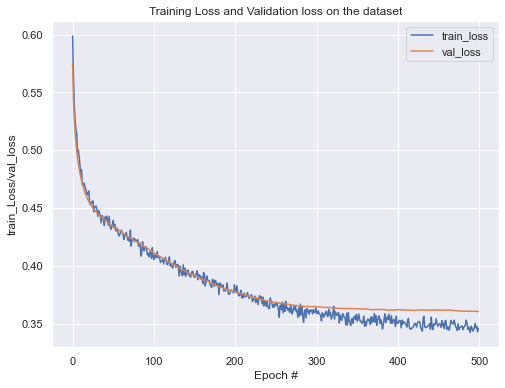

Accuracy on training set :  0.8655714285714285
Recall on training set :  0.42496493688639553
Precision on training set :  0.8335625859697386
F1 on training set :  0.5629354389224338


In [247]:
get_history_plot(500)
get_training_metrics(model10, X_train, y_train)

* After 500 ephochs we can see that the training loss has started to flatten. The validation loss flattens at about epoch 300.
* We don't suffer from overfitting here. However, our training and validation accuracy are still no better than our original model at ~0.85

### Model 11 - HeNormal Initializer
Note, I've run this a few times also, I've dropped the dropout fraction

In [248]:
model11 = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=(X_train.shape[1],), kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')
  ])

# Defining the optimizer. 
optimizer = tf.keras.optimizers.Adadelta(0.05)  

# Compile the model
model11.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [249]:
EPOCHS = 500 # define epochs
history = model11.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2,) # fit model

Epoch 1/500
175/175 - 0s - loss: 0.8581 - accuracy: 0.6398 - val_loss: 0.6519 - val_accuracy: 0.7186
Epoch 2/500
175/175 - 0s - loss: 0.7812 - accuracy: 0.6686 - val_loss: 0.6219 - val_accuracy: 0.7414
Epoch 3/500
175/175 - 0s - loss: 0.7360 - accuracy: 0.7013 - val_loss: 0.6022 - val_accuracy: 0.7636
Epoch 4/500
175/175 - 0s - loss: 0.6965 - accuracy: 0.7200 - val_loss: 0.5852 - val_accuracy: 0.7714
Epoch 5/500
175/175 - 0s - loss: 0.6652 - accuracy: 0.7295 - val_loss: 0.5706 - val_accuracy: 0.7729
Epoch 6/500
175/175 - 0s - loss: 0.6531 - accuracy: 0.7391 - val_loss: 0.5578 - val_accuracy: 0.7771
Epoch 7/500
175/175 - 0s - loss: 0.6294 - accuracy: 0.7423 - val_loss: 0.5461 - val_accuracy: 0.7793
Epoch 8/500
175/175 - 0s - loss: 0.5941 - accuracy: 0.7568 - val_loss: 0.5357 - val_accuracy: 0.7793
Epoch 9/500
175/175 - 0s - loss: 0.6085 - accuracy: 0.7459 - val_loss: 0.5269 - val_accuracy: 0.7807
Epoch 10/500
175/175 - 0s - loss: 0.5825 - accuracy: 0.7613 - val_loss: 0.5186 - val_accura

Epoch 82/500
175/175 - 0s - loss: 0.4317 - accuracy: 0.8121 - val_loss: 0.4276 - val_accuracy: 0.8100
Epoch 83/500
175/175 - 0s - loss: 0.4310 - accuracy: 0.8129 - val_loss: 0.4270 - val_accuracy: 0.8100
Epoch 84/500
175/175 - 0s - loss: 0.4279 - accuracy: 0.8130 - val_loss: 0.4266 - val_accuracy: 0.8100
Epoch 85/500
175/175 - 0s - loss: 0.4283 - accuracy: 0.8200 - val_loss: 0.4261 - val_accuracy: 0.8100
Epoch 86/500
175/175 - 0s - loss: 0.4387 - accuracy: 0.8071 - val_loss: 0.4259 - val_accuracy: 0.8107
Epoch 87/500
175/175 - 0s - loss: 0.4282 - accuracy: 0.8118 - val_loss: 0.4254 - val_accuracy: 0.8114
Epoch 88/500
175/175 - 0s - loss: 0.4269 - accuracy: 0.8171 - val_loss: 0.4250 - val_accuracy: 0.8114
Epoch 89/500
175/175 - 0s - loss: 0.4303 - accuracy: 0.8179 - val_loss: 0.4245 - val_accuracy: 0.8107
Epoch 90/500
175/175 - 0s - loss: 0.4304 - accuracy: 0.8161 - val_loss: 0.4241 - val_accuracy: 0.8114
Epoch 91/500
175/175 - 0s - loss: 0.4302 - accuracy: 0.8129 - val_loss: 0.4237 - v

Epoch 162/500
175/175 - 0s - loss: 0.4045 - accuracy: 0.8257 - val_loss: 0.3979 - val_accuracy: 0.8321
Epoch 163/500
175/175 - 0s - loss: 0.4069 - accuracy: 0.8243 - val_loss: 0.3976 - val_accuracy: 0.8321
Epoch 164/500
175/175 - 0s - loss: 0.4007 - accuracy: 0.8279 - val_loss: 0.3973 - val_accuracy: 0.8314
Epoch 165/500
175/175 - 0s - loss: 0.4070 - accuracy: 0.8213 - val_loss: 0.3972 - val_accuracy: 0.8321
Epoch 166/500
175/175 - 0s - loss: 0.4059 - accuracy: 0.8241 - val_loss: 0.3969 - val_accuracy: 0.8314
Epoch 167/500
175/175 - 0s - loss: 0.4032 - accuracy: 0.8318 - val_loss: 0.3966 - val_accuracy: 0.8321
Epoch 168/500
175/175 - 0s - loss: 0.4030 - accuracy: 0.8318 - val_loss: 0.3963 - val_accuracy: 0.8321
Epoch 169/500
175/175 - 0s - loss: 0.3988 - accuracy: 0.8277 - val_loss: 0.3961 - val_accuracy: 0.8321
Epoch 170/500
175/175 - 0s - loss: 0.3973 - accuracy: 0.8284 - val_loss: 0.3958 - val_accuracy: 0.8329
Epoch 171/500
175/175 - 0s - loss: 0.4011 - accuracy: 0.8296 - val_loss: 

Epoch 242/500
175/175 - 0s - loss: 0.3850 - accuracy: 0.8346 - val_loss: 0.3791 - val_accuracy: 0.8471
Epoch 243/500
175/175 - 0s - loss: 0.3846 - accuracy: 0.8413 - val_loss: 0.3789 - val_accuracy: 0.8479
Epoch 244/500
175/175 - 0s - loss: 0.3837 - accuracy: 0.8366 - val_loss: 0.3790 - val_accuracy: 0.8471
Epoch 245/500
175/175 - 0s - loss: 0.3835 - accuracy: 0.8343 - val_loss: 0.3789 - val_accuracy: 0.8471
Epoch 246/500
175/175 - 0s - loss: 0.3876 - accuracy: 0.8314 - val_loss: 0.3788 - val_accuracy: 0.8486
Epoch 247/500
175/175 - 0s - loss: 0.3860 - accuracy: 0.8354 - val_loss: 0.3786 - val_accuracy: 0.8486
Epoch 248/500
175/175 - 0s - loss: 0.3848 - accuracy: 0.8364 - val_loss: 0.3783 - val_accuracy: 0.8500
Epoch 249/500
175/175 - 0s - loss: 0.3817 - accuracy: 0.8405 - val_loss: 0.3781 - val_accuracy: 0.8500
Epoch 250/500
175/175 - 0s - loss: 0.3885 - accuracy: 0.8346 - val_loss: 0.3780 - val_accuracy: 0.8500
Epoch 251/500
175/175 - 0s - loss: 0.3895 - accuracy: 0.8332 - val_loss: 

Epoch 322/500
175/175 - 0s - loss: 0.3728 - accuracy: 0.8398 - val_loss: 0.3712 - val_accuracy: 0.8543
Epoch 323/500
175/175 - 0s - loss: 0.3766 - accuracy: 0.8427 - val_loss: 0.3710 - val_accuracy: 0.8543
Epoch 324/500
175/175 - 0s - loss: 0.3757 - accuracy: 0.8445 - val_loss: 0.3710 - val_accuracy: 0.8543
Epoch 325/500
175/175 - 0s - loss: 0.3734 - accuracy: 0.8389 - val_loss: 0.3709 - val_accuracy: 0.8550
Epoch 326/500
175/175 - 0s - loss: 0.3734 - accuracy: 0.8436 - val_loss: 0.3707 - val_accuracy: 0.8550
Epoch 327/500
175/175 - 0s - loss: 0.3746 - accuracy: 0.8413 - val_loss: 0.3707 - val_accuracy: 0.8557
Epoch 328/500
175/175 - 0s - loss: 0.3774 - accuracy: 0.8450 - val_loss: 0.3705 - val_accuracy: 0.8557
Epoch 329/500
175/175 - 0s - loss: 0.3746 - accuracy: 0.8411 - val_loss: 0.3704 - val_accuracy: 0.8564
Epoch 330/500
175/175 - 0s - loss: 0.3757 - accuracy: 0.8384 - val_loss: 0.3702 - val_accuracy: 0.8564
Epoch 331/500
175/175 - 0s - loss: 0.3683 - accuracy: 0.8446 - val_loss: 

Epoch 402/500
175/175 - 0s - loss: 0.3637 - accuracy: 0.8454 - val_loss: 0.3668 - val_accuracy: 0.8543
Epoch 403/500
175/175 - 0s - loss: 0.3626 - accuracy: 0.8505 - val_loss: 0.3666 - val_accuracy: 0.8536
Epoch 404/500
175/175 - 0s - loss: 0.3649 - accuracy: 0.8486 - val_loss: 0.3666 - val_accuracy: 0.8543
Epoch 405/500
175/175 - 0s - loss: 0.3663 - accuracy: 0.8441 - val_loss: 0.3666 - val_accuracy: 0.8543
Epoch 406/500
175/175 - 0s - loss: 0.3645 - accuracy: 0.8459 - val_loss: 0.3666 - val_accuracy: 0.8543
Epoch 407/500
175/175 - 0s - loss: 0.3635 - accuracy: 0.8454 - val_loss: 0.3666 - val_accuracy: 0.8543
Epoch 408/500
175/175 - 0s - loss: 0.3690 - accuracy: 0.8418 - val_loss: 0.3666 - val_accuracy: 0.8543
Epoch 409/500
175/175 - 0s - loss: 0.3661 - accuracy: 0.8459 - val_loss: 0.3668 - val_accuracy: 0.8536
Epoch 410/500
175/175 - 0s - loss: 0.3684 - accuracy: 0.8438 - val_loss: 0.3668 - val_accuracy: 0.8543
Epoch 411/500
175/175 - 0s - loss: 0.3656 - accuracy: 0.8443 - val_loss: 

Epoch 482/500
175/175 - 0s - loss: 0.3635 - accuracy: 0.8504 - val_loss: 0.3651 - val_accuracy: 0.8557
Epoch 483/500
175/175 - 0s - loss: 0.3635 - accuracy: 0.8484 - val_loss: 0.3650 - val_accuracy: 0.8557
Epoch 484/500
175/175 - 0s - loss: 0.3631 - accuracy: 0.8455 - val_loss: 0.3649 - val_accuracy: 0.8557
Epoch 485/500
175/175 - 0s - loss: 0.3638 - accuracy: 0.8491 - val_loss: 0.3649 - val_accuracy: 0.8557
Epoch 486/500
175/175 - 0s - loss: 0.3647 - accuracy: 0.8448 - val_loss: 0.3647 - val_accuracy: 0.8550
Epoch 487/500
175/175 - 0s - loss: 0.3570 - accuracy: 0.8539 - val_loss: 0.3647 - val_accuracy: 0.8550
Epoch 488/500
175/175 - 0s - loss: 0.3669 - accuracy: 0.8459 - val_loss: 0.3648 - val_accuracy: 0.8557
Epoch 489/500
175/175 - 0s - loss: 0.3651 - accuracy: 0.8441 - val_loss: 0.3648 - val_accuracy: 0.8564
Epoch 490/500
175/175 - 0s - loss: 0.3635 - accuracy: 0.8496 - val_loss: 0.3649 - val_accuracy: 0.8557
Epoch 491/500
175/175 - 0s - loss: 0.3581 - accuracy: 0.8527 - val_loss: 

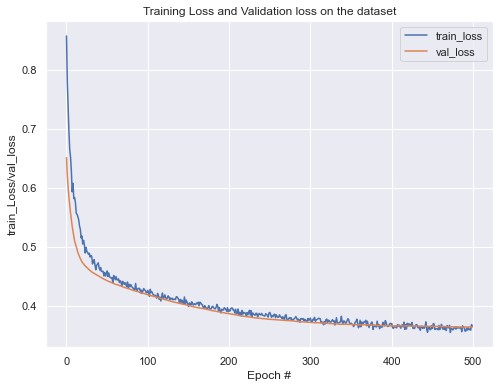

Accuracy on training set :  0.8588571428571429
Recall on training set :  0.3899018232819074
Precision on training set :  0.8249258160237388
F1 on training set :  0.5295238095238095


In [250]:
get_history_plot(500)
get_training_metrics(model11, X_train, y_train)

* After 500 epochs the loss on the validation data starts to flatten out. 
* We have solved the overfitting but at the end of the training, the accuracy is still no better for the training or validation data then our original model.

### Model 12 - Random Uniform Initializer

In [251]:
model12 = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=(X_train.shape[1],), kernel_initializer='random_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25, activation='relu', kernel_initializer='random_uniform'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='random_uniform')
  ])

# Defining the optimizer. 
optimizer = tf.keras.optimizers.Adadelta(0.05)  

# Compile the model
model12.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [252]:
EPOCHS = 500 # define epochs
history = model12.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2,) # fit model

Epoch 1/500
175/175 - 0s - loss: 0.6905 - accuracy: 0.7696 - val_loss: 0.6874 - val_accuracy: 0.7807
Epoch 2/500
175/175 - 0s - loss: 0.6805 - accuracy: 0.8002 - val_loss: 0.6715 - val_accuracy: 0.7807
Epoch 3/500
175/175 - 0s - loss: 0.6440 - accuracy: 0.8002 - val_loss: 0.6112 - val_accuracy: 0.7807
Epoch 4/500
175/175 - 0s - loss: 0.5563 - accuracy: 0.8002 - val_loss: 0.5226 - val_accuracy: 0.7807
Epoch 5/500
175/175 - 0s - loss: 0.4945 - accuracy: 0.8002 - val_loss: 0.4914 - val_accuracy: 0.7807
Epoch 6/500
175/175 - 0s - loss: 0.4711 - accuracy: 0.8002 - val_loss: 0.4816 - val_accuracy: 0.7807
Epoch 7/500
175/175 - 0s - loss: 0.4620 - accuracy: 0.8002 - val_loss: 0.4759 - val_accuracy: 0.7807
Epoch 8/500
175/175 - 0s - loss: 0.4620 - accuracy: 0.8002 - val_loss: 0.4716 - val_accuracy: 0.7807
Epoch 9/500
175/175 - 0s - loss: 0.4551 - accuracy: 0.8002 - val_loss: 0.4682 - val_accuracy: 0.7807
Epoch 10/500
175/175 - 0s - loss: 0.4559 - accuracy: 0.8002 - val_loss: 0.4651 - val_accura

Epoch 82/500
175/175 - 0s - loss: 0.3891 - accuracy: 0.8371 - val_loss: 0.3951 - val_accuracy: 0.8464
Epoch 83/500
175/175 - 0s - loss: 0.3848 - accuracy: 0.8430 - val_loss: 0.3946 - val_accuracy: 0.8479
Epoch 84/500
175/175 - 0s - loss: 0.3903 - accuracy: 0.8400 - val_loss: 0.3939 - val_accuracy: 0.8486
Epoch 85/500
175/175 - 0s - loss: 0.3879 - accuracy: 0.8430 - val_loss: 0.3935 - val_accuracy: 0.8493
Epoch 86/500
175/175 - 0s - loss: 0.3838 - accuracy: 0.8402 - val_loss: 0.3928 - val_accuracy: 0.8486
Epoch 87/500
175/175 - 0s - loss: 0.3857 - accuracy: 0.8439 - val_loss: 0.3921 - val_accuracy: 0.8493
Epoch 88/500
175/175 - 0s - loss: 0.3852 - accuracy: 0.8461 - val_loss: 0.3915 - val_accuracy: 0.8493
Epoch 89/500
175/175 - 0s - loss: 0.3855 - accuracy: 0.8423 - val_loss: 0.3909 - val_accuracy: 0.8493
Epoch 90/500
175/175 - 0s - loss: 0.3861 - accuracy: 0.8439 - val_loss: 0.3902 - val_accuracy: 0.8471
Epoch 91/500
175/175 - 0s - loss: 0.3792 - accuracy: 0.8470 - val_loss: 0.3897 - v

Epoch 162/500
175/175 - 0s - loss: 0.3601 - accuracy: 0.8514 - val_loss: 0.3677 - val_accuracy: 0.8550
Epoch 163/500
175/175 - 0s - loss: 0.3597 - accuracy: 0.8516 - val_loss: 0.3674 - val_accuracy: 0.8550
Epoch 164/500
175/175 - 0s - loss: 0.3531 - accuracy: 0.8562 - val_loss: 0.3675 - val_accuracy: 0.8543
Epoch 165/500
175/175 - 0s - loss: 0.3568 - accuracy: 0.8555 - val_loss: 0.3672 - val_accuracy: 0.8550
Epoch 166/500
175/175 - 0s - loss: 0.3595 - accuracy: 0.8548 - val_loss: 0.3668 - val_accuracy: 0.8550
Epoch 167/500
175/175 - 0s - loss: 0.3606 - accuracy: 0.8557 - val_loss: 0.3665 - val_accuracy: 0.8550
Epoch 168/500
175/175 - 0s - loss: 0.3624 - accuracy: 0.8559 - val_loss: 0.3665 - val_accuracy: 0.8543
Epoch 169/500
175/175 - 0s - loss: 0.3637 - accuracy: 0.8520 - val_loss: 0.3665 - val_accuracy: 0.8550
Epoch 170/500
175/175 - 0s - loss: 0.3599 - accuracy: 0.8525 - val_loss: 0.3666 - val_accuracy: 0.8557
Epoch 171/500
175/175 - 0s - loss: 0.3559 - accuracy: 0.8543 - val_loss: 

Epoch 242/500
175/175 - 0s - loss: 0.3496 - accuracy: 0.8582 - val_loss: 0.3603 - val_accuracy: 0.8529
Epoch 243/500
175/175 - 0s - loss: 0.3500 - accuracy: 0.8605 - val_loss: 0.3600 - val_accuracy: 0.8536
Epoch 244/500
175/175 - 0s - loss: 0.3483 - accuracy: 0.8607 - val_loss: 0.3598 - val_accuracy: 0.8536
Epoch 245/500
175/175 - 0s - loss: 0.3480 - accuracy: 0.8609 - val_loss: 0.3597 - val_accuracy: 0.8536
Epoch 246/500
175/175 - 0s - loss: 0.3476 - accuracy: 0.8593 - val_loss: 0.3595 - val_accuracy: 0.8543
Epoch 247/500
175/175 - 0s - loss: 0.3463 - accuracy: 0.8607 - val_loss: 0.3598 - val_accuracy: 0.8543
Epoch 248/500
175/175 - 0s - loss: 0.3454 - accuracy: 0.8607 - val_loss: 0.3595 - val_accuracy: 0.8536
Epoch 249/500
175/175 - 0s - loss: 0.3499 - accuracy: 0.8584 - val_loss: 0.3595 - val_accuracy: 0.8529
Epoch 250/500
175/175 - 0s - loss: 0.3487 - accuracy: 0.8593 - val_loss: 0.3595 - val_accuracy: 0.8536
Epoch 251/500
175/175 - 0s - loss: 0.3467 - accuracy: 0.8579 - val_loss: 

Epoch 322/500
175/175 - 0s - loss: 0.3449 - accuracy: 0.8623 - val_loss: 0.3575 - val_accuracy: 0.8543
Epoch 323/500
175/175 - 0s - loss: 0.3425 - accuracy: 0.8591 - val_loss: 0.3575 - val_accuracy: 0.8543
Epoch 324/500
175/175 - 0s - loss: 0.3447 - accuracy: 0.8611 - val_loss: 0.3574 - val_accuracy: 0.8529
Epoch 325/500
175/175 - 0s - loss: 0.3476 - accuracy: 0.8605 - val_loss: 0.3573 - val_accuracy: 0.8529
Epoch 326/500
175/175 - 0s - loss: 0.3462 - accuracy: 0.8641 - val_loss: 0.3572 - val_accuracy: 0.8536
Epoch 327/500
175/175 - 0s - loss: 0.3442 - accuracy: 0.8620 - val_loss: 0.3574 - val_accuracy: 0.8529
Epoch 328/500
175/175 - 0s - loss: 0.3454 - accuracy: 0.8605 - val_loss: 0.3576 - val_accuracy: 0.8529
Epoch 329/500
175/175 - 0s - loss: 0.3386 - accuracy: 0.8645 - val_loss: 0.3577 - val_accuracy: 0.8529
Epoch 330/500
175/175 - 0s - loss: 0.3427 - accuracy: 0.8632 - val_loss: 0.3575 - val_accuracy: 0.8529
Epoch 331/500
175/175 - 0s - loss: 0.3439 - accuracy: 0.8621 - val_loss: 

Epoch 402/500
175/175 - 0s - loss: 0.3386 - accuracy: 0.8666 - val_loss: 0.3566 - val_accuracy: 0.8529
Epoch 403/500
175/175 - 0s - loss: 0.3409 - accuracy: 0.8604 - val_loss: 0.3567 - val_accuracy: 0.8529
Epoch 404/500
175/175 - 0s - loss: 0.3405 - accuracy: 0.8645 - val_loss: 0.3568 - val_accuracy: 0.8529
Epoch 405/500
175/175 - 0s - loss: 0.3431 - accuracy: 0.8652 - val_loss: 0.3568 - val_accuracy: 0.8529
Epoch 406/500
175/175 - 0s - loss: 0.3408 - accuracy: 0.8655 - val_loss: 0.3568 - val_accuracy: 0.8514
Epoch 407/500
175/175 - 0s - loss: 0.3421 - accuracy: 0.8643 - val_loss: 0.3567 - val_accuracy: 0.8521
Epoch 408/500
175/175 - 0s - loss: 0.3420 - accuracy: 0.8611 - val_loss: 0.3567 - val_accuracy: 0.8521
Epoch 409/500
175/175 - 0s - loss: 0.3421 - accuracy: 0.8620 - val_loss: 0.3567 - val_accuracy: 0.8521
Epoch 410/500
175/175 - 0s - loss: 0.3398 - accuracy: 0.8625 - val_loss: 0.3568 - val_accuracy: 0.8529
Epoch 411/500
175/175 - 0s - loss: 0.3343 - accuracy: 0.8661 - val_loss: 

Epoch 482/500
175/175 - 0s - loss: 0.3341 - accuracy: 0.8630 - val_loss: 0.3567 - val_accuracy: 0.8529
Epoch 483/500
175/175 - 0s - loss: 0.3436 - accuracy: 0.8611 - val_loss: 0.3567 - val_accuracy: 0.8529
Epoch 484/500
175/175 - 0s - loss: 0.3363 - accuracy: 0.8646 - val_loss: 0.3564 - val_accuracy: 0.8529
Epoch 485/500
175/175 - 0s - loss: 0.3392 - accuracy: 0.8629 - val_loss: 0.3566 - val_accuracy: 0.8514
Epoch 486/500
175/175 - 0s - loss: 0.3360 - accuracy: 0.8689 - val_loss: 0.3565 - val_accuracy: 0.8521
Epoch 487/500
175/175 - 0s - loss: 0.3376 - accuracy: 0.8654 - val_loss: 0.3566 - val_accuracy: 0.8529
Epoch 488/500
175/175 - 0s - loss: 0.3376 - accuracy: 0.8616 - val_loss: 0.3566 - val_accuracy: 0.8521
Epoch 489/500
175/175 - 0s - loss: 0.3297 - accuracy: 0.8677 - val_loss: 0.3570 - val_accuracy: 0.8529
Epoch 490/500
175/175 - 0s - loss: 0.3390 - accuracy: 0.8625 - val_loss: 0.3570 - val_accuracy: 0.8521
Epoch 491/500
175/175 - 0s - loss: 0.3356 - accuracy: 0.8677 - val_loss: 

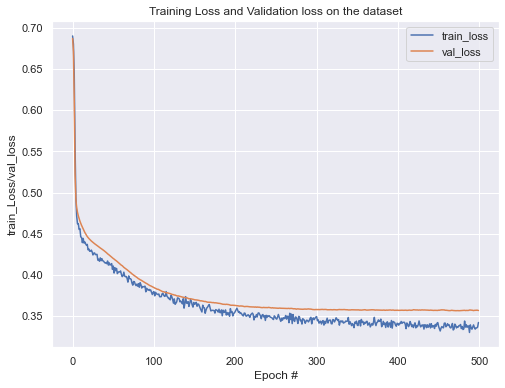

Accuracy on training set :  0.8682857142857143
Recall on training set :  0.4740532959326788
Precision on training set :  0.7971698113207547
F1 on training set :  0.594547053649956


In [253]:
get_history_plot(500)
get_training_metrics(model12, X_train, y_train)

* This initializer did not improve the results. We still see accuracy results that are similar to every test we have run so far.
* It is clear that changes to the architecture of the ANN are not having a great effect on the resutls. For this reason we will change our strategy. We will Up Sample the data so that the classes are balanced and then try to fit an ANN to the more balanced data.
* Before we do that, let's evalute the best model we have so far using the initial data

## Evalue Best Model Before Up Sampling
Model 11 has the lowest validation loss so far. Let's evaluate this model before we up sample the data

In [254]:
get_metrics_score(model11,X_train,X_test,y_train,y_test,threshold=0.5)

Accuracy on training set :  0.8588571428571429
Accuracy on test set :  0.855
Recall on training set :  0.3899018232819074
Recall on test set :  0.381342062193126
Precision on training set :  0.8249258160237388
Precision on test set :  0.803448275862069
F1 on training set :  0.5295238095238095
F1 on test set :  0.5172031076581577


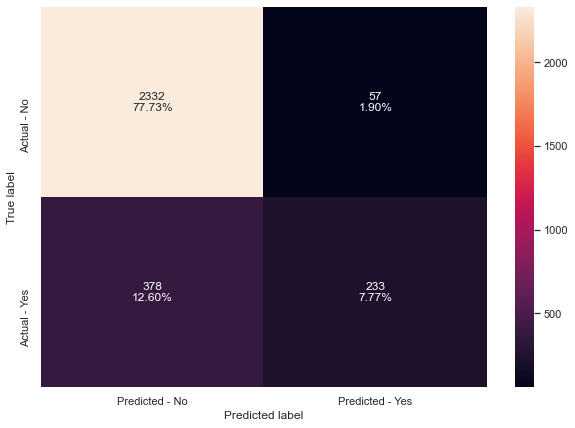

In [255]:
make_confusion_matrix(model11,X_test,y_test,threshold=0.5)

* Even though we improved the validation loss, we can see that we have not significantly changed the model recall compared to our initial model

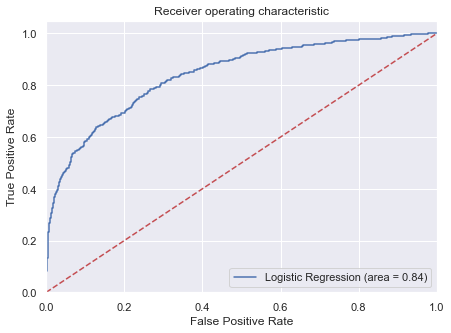

The optimal threshold is: 0.18688333


In [256]:
make_ROC(model11)

* The area under the curve is exactly the same as the original model. So we have failed to improve performance from our initial model.
* Let's evaluate the model using the optimum threshold above.

In [257]:
optimal = get_optimal(model11)
get_metrics_score(model11,X_train,X_test,y_train,y_test,threshold=optimal)

Accuracy on training set :  0.7514285714285714
Accuracy on test set :  0.7436666666666667
Recall on training set :  0.8155680224403927
Recall on test set :  0.7823240589198036
Precision on training set :  0.44053030303030305
Precision on test set :  0.42908438061041293
F1 on training set :  0.5720609936055091
F1 on test set :  0.5542028985507246


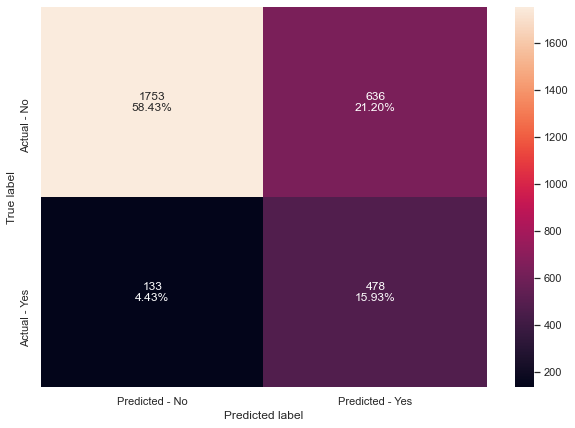

In [258]:
make_confusion_matrix(model11,X_test,y_test,threshold=optimal)

* The performance of the initial model and this model changes each time that I run the note book. Sometimes there is some improvement in model 11 over the inital model, sometimes there is not.
* This tells me that we have failed to significantly improve the model since the intial model.

## Up Sample Data
Currently our training and testing data are scaled using a standard scaler. We will split the data again, up scale and than apply the standard scaler.

In [259]:
# Let's split the data into a train and test sets. 
# I will use the stratify parameter to maintain the ratio of classes in the dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [260]:
print("Before UpSampling, counts of label 'Attrited': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label 'Existing': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After UpSampling, counts of label 'Attrited': {}".format(sum(y_train_over==1)))
print("After UpSampling, counts of label 'Existing': {} \n".format(sum(y_train_over==0)))


print('After UpSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_over.shape))

Before UpSampling, counts of label 'Attrited': 1426
Before UpSampling, counts of label 'Existing': 5574 

After UpSampling, counts of label 'Attrited': 5574
After UpSampling, counts of label 'Existing': 5574 

After UpSampling, the shape of train_X: (11148, 11)
After UpSampling, the shape of train_y: (11148,) 



* The classes are now balanced after using the SMOTE technique.
* We will now apply a scalar to the up sampled data.

In [261]:
ss = StandardScaler()

X_train = ss.fit_transform(X_train_over) # Fit scalar to training data and transform
X_test = ss.transform(X_test) # ONLY apply the transform to the test data
y_train = y_train_over

### Model 13 - Repeat Model 11 using up sampled data
Model 11 is the model with the lowest validation error so far, we will use the same architechture, this time we will input the upsampled data.

In [262]:
model13 = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=(X_train.shape[1],), kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')
  ])

# Defining the optimizer. 
optimizer = tf.keras.optimizers.Adadelta(0.05)  

# Compile the model
model13.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [263]:
EPOCHS = 500 # define epochs
history = model13.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2,) # fit model

Epoch 1/500
279/279 - 0s - loss: 1.1445 - accuracy: 0.4594 - val_loss: 0.5345 - val_accuracy: 0.7605
Epoch 2/500
279/279 - 0s - loss: 0.8692 - accuracy: 0.5335 - val_loss: 0.7242 - val_accuracy: 0.5287
Epoch 3/500
279/279 - 0s - loss: 0.7698 - accuracy: 0.5702 - val_loss: 0.8077 - val_accuracy: 0.4090
Epoch 4/500
279/279 - 0s - loss: 0.7101 - accuracy: 0.6051 - val_loss: 0.8263 - val_accuracy: 0.3915
Epoch 5/500
279/279 - 0s - loss: 0.6844 - accuracy: 0.6229 - val_loss: 0.8185 - val_accuracy: 0.4139
Epoch 6/500
279/279 - 0s - loss: 0.6632 - accuracy: 0.6415 - val_loss: 0.8016 - val_accuracy: 0.4583
Epoch 7/500
279/279 - 0s - loss: 0.6377 - accuracy: 0.6671 - val_loss: 0.7810 - val_accuracy: 0.5018
Epoch 8/500
279/279 - 0s - loss: 0.6177 - accuracy: 0.6717 - val_loss: 0.7611 - val_accuracy: 0.5291
Epoch 9/500
279/279 - 0s - loss: 0.6111 - accuracy: 0.6819 - val_loss: 0.7399 - val_accuracy: 0.5502
Epoch 10/500
279/279 - 0s - loss: 0.6004 - accuracy: 0.6915 - val_loss: 0.7220 - val_accura

Epoch 82/500
279/279 - 0s - loss: 0.4658 - accuracy: 0.7881 - val_loss: 0.4852 - val_accuracy: 0.7561
Epoch 83/500
279/279 - 0s - loss: 0.4721 - accuracy: 0.7865 - val_loss: 0.4860 - val_accuracy: 0.7556
Epoch 84/500
279/279 - 0s - loss: 0.4640 - accuracy: 0.7890 - val_loss: 0.4846 - val_accuracy: 0.7574
Epoch 85/500
279/279 - 0s - loss: 0.4696 - accuracy: 0.7871 - val_loss: 0.4831 - val_accuracy: 0.7578
Epoch 86/500
279/279 - 0s - loss: 0.4633 - accuracy: 0.7856 - val_loss: 0.4815 - val_accuracy: 0.7570
Epoch 87/500
279/279 - 0s - loss: 0.4678 - accuracy: 0.7912 - val_loss: 0.4787 - val_accuracy: 0.7587
Epoch 88/500
279/279 - 0s - loss: 0.4687 - accuracy: 0.7841 - val_loss: 0.4780 - val_accuracy: 0.7587
Epoch 89/500
279/279 - 0s - loss: 0.4669 - accuracy: 0.7899 - val_loss: 0.4806 - val_accuracy: 0.7570
Epoch 90/500
279/279 - 0s - loss: 0.4667 - accuracy: 0.7882 - val_loss: 0.4821 - val_accuracy: 0.7561
Epoch 91/500
279/279 - 0s - loss: 0.4691 - accuracy: 0.7853 - val_loss: 0.4817 - v

Epoch 162/500
279/279 - 0s - loss: 0.4424 - accuracy: 0.8050 - val_loss: 0.4632 - val_accuracy: 0.7668
Epoch 163/500
279/279 - 0s - loss: 0.4365 - accuracy: 0.8016 - val_loss: 0.4630 - val_accuracy: 0.7686
Epoch 164/500
279/279 - 0s - loss: 0.4360 - accuracy: 0.8042 - val_loss: 0.4608 - val_accuracy: 0.7695
Epoch 165/500
279/279 - 0s - loss: 0.4404 - accuracy: 0.8033 - val_loss: 0.4618 - val_accuracy: 0.7682
Epoch 166/500
279/279 - 0s - loss: 0.4434 - accuracy: 0.8031 - val_loss: 0.4599 - val_accuracy: 0.7691
Epoch 167/500
279/279 - 0s - loss: 0.4400 - accuracy: 0.7988 - val_loss: 0.4573 - val_accuracy: 0.7713
Epoch 168/500
279/279 - 0s - loss: 0.4417 - accuracy: 0.8049 - val_loss: 0.4595 - val_accuracy: 0.7700
Epoch 169/500
279/279 - 0s - loss: 0.4376 - accuracy: 0.8009 - val_loss: 0.4607 - val_accuracy: 0.7682
Epoch 170/500
279/279 - 0s - loss: 0.4387 - accuracy: 0.8035 - val_loss: 0.4605 - val_accuracy: 0.7686
Epoch 171/500
279/279 - 0s - loss: 0.4420 - accuracy: 0.7965 - val_loss: 

Epoch 242/500
279/279 - 0s - loss: 0.4259 - accuracy: 0.8081 - val_loss: 0.4534 - val_accuracy: 0.7686
Epoch 243/500
279/279 - 0s - loss: 0.4266 - accuracy: 0.8061 - val_loss: 0.4535 - val_accuracy: 0.7686
Epoch 244/500
279/279 - 0s - loss: 0.4249 - accuracy: 0.8061 - val_loss: 0.4566 - val_accuracy: 0.7677
Epoch 245/500
279/279 - 0s - loss: 0.4270 - accuracy: 0.8076 - val_loss: 0.4557 - val_accuracy: 0.7677
Epoch 246/500
279/279 - 0s - loss: 0.4284 - accuracy: 0.8099 - val_loss: 0.4540 - val_accuracy: 0.7677
Epoch 247/500
279/279 - 0s - loss: 0.4265 - accuracy: 0.8067 - val_loss: 0.4554 - val_accuracy: 0.7677
Epoch 248/500
279/279 - 0s - loss: 0.4283 - accuracy: 0.8100 - val_loss: 0.4551 - val_accuracy: 0.7677
Epoch 249/500
279/279 - 0s - loss: 0.4248 - accuracy: 0.8133 - val_loss: 0.4572 - val_accuracy: 0.7668
Epoch 250/500
279/279 - 0s - loss: 0.4262 - accuracy: 0.8107 - val_loss: 0.4545 - val_accuracy: 0.7677
Epoch 251/500
279/279 - 0s - loss: 0.4274 - accuracy: 0.8066 - val_loss: 

Epoch 322/500
279/279 - 0s - loss: 0.4216 - accuracy: 0.8153 - val_loss: 0.4526 - val_accuracy: 0.7695
Epoch 323/500
279/279 - 0s - loss: 0.4151 - accuracy: 0.8167 - val_loss: 0.4535 - val_accuracy: 0.7691
Epoch 324/500
279/279 - 0s - loss: 0.4257 - accuracy: 0.8114 - val_loss: 0.4518 - val_accuracy: 0.7704
Epoch 325/500
279/279 - 0s - loss: 0.4199 - accuracy: 0.8109 - val_loss: 0.4530 - val_accuracy: 0.7695
Epoch 326/500
279/279 - 0s - loss: 0.4205 - accuracy: 0.8122 - val_loss: 0.4523 - val_accuracy: 0.7700
Epoch 327/500
279/279 - 0s - loss: 0.4169 - accuracy: 0.8086 - val_loss: 0.4512 - val_accuracy: 0.7709
Epoch 328/500
279/279 - 0s - loss: 0.4206 - accuracy: 0.8157 - val_loss: 0.4522 - val_accuracy: 0.7704
Epoch 329/500
279/279 - 0s - loss: 0.4192 - accuracy: 0.8114 - val_loss: 0.4527 - val_accuracy: 0.7700
Epoch 330/500
279/279 - 0s - loss: 0.4170 - accuracy: 0.8103 - val_loss: 0.4536 - val_accuracy: 0.7700
Epoch 331/500
279/279 - 0s - loss: 0.4218 - accuracy: 0.8113 - val_loss: 

Epoch 402/500
279/279 - 0s - loss: 0.4135 - accuracy: 0.8155 - val_loss: 0.4495 - val_accuracy: 0.7695
Epoch 403/500
279/279 - 0s - loss: 0.4174 - accuracy: 0.8144 - val_loss: 0.4481 - val_accuracy: 0.7700
Epoch 404/500
279/279 - 0s - loss: 0.4148 - accuracy: 0.8158 - val_loss: 0.4489 - val_accuracy: 0.7695
Epoch 405/500
279/279 - 0s - loss: 0.4176 - accuracy: 0.8132 - val_loss: 0.4497 - val_accuracy: 0.7695
Epoch 406/500
279/279 - 0s - loss: 0.4149 - accuracy: 0.8136 - val_loss: 0.4492 - val_accuracy: 0.7700
Epoch 407/500
279/279 - 0s - loss: 0.4151 - accuracy: 0.8152 - val_loss: 0.4490 - val_accuracy: 0.7700
Epoch 408/500
279/279 - 0s - loss: 0.4138 - accuracy: 0.8190 - val_loss: 0.4515 - val_accuracy: 0.7682
Epoch 409/500
279/279 - 0s - loss: 0.4131 - accuracy: 0.8149 - val_loss: 0.4499 - val_accuracy: 0.7695
Epoch 410/500
279/279 - 0s - loss: 0.4154 - accuracy: 0.8112 - val_loss: 0.4519 - val_accuracy: 0.7682
Epoch 411/500
279/279 - 0s - loss: 0.4157 - accuracy: 0.8143 - val_loss: 

Epoch 482/500
279/279 - 0s - loss: 0.4087 - accuracy: 0.8168 - val_loss: 0.4531 - val_accuracy: 0.7664
Epoch 483/500
279/279 - 0s - loss: 0.4106 - accuracy: 0.8134 - val_loss: 0.4534 - val_accuracy: 0.7664
Epoch 484/500
279/279 - 0s - loss: 0.4092 - accuracy: 0.8170 - val_loss: 0.4533 - val_accuracy: 0.7659
Epoch 485/500
279/279 - 0s - loss: 0.4077 - accuracy: 0.8178 - val_loss: 0.4519 - val_accuracy: 0.7664
Epoch 486/500
279/279 - 0s - loss: 0.4132 - accuracy: 0.8142 - val_loss: 0.4529 - val_accuracy: 0.7659
Epoch 487/500
279/279 - 0s - loss: 0.4111 - accuracy: 0.8144 - val_loss: 0.4513 - val_accuracy: 0.7655
Epoch 488/500
279/279 - 0s - loss: 0.4143 - accuracy: 0.8163 - val_loss: 0.4519 - val_accuracy: 0.7646
Epoch 489/500
279/279 - 0s - loss: 0.4125 - accuracy: 0.8209 - val_loss: 0.4492 - val_accuracy: 0.7659
Epoch 490/500
279/279 - 0s - loss: 0.4106 - accuracy: 0.8176 - val_loss: 0.4486 - val_accuracy: 0.7668
Epoch 491/500
279/279 - 0s - loss: 0.4089 - accuracy: 0.8191 - val_loss: 

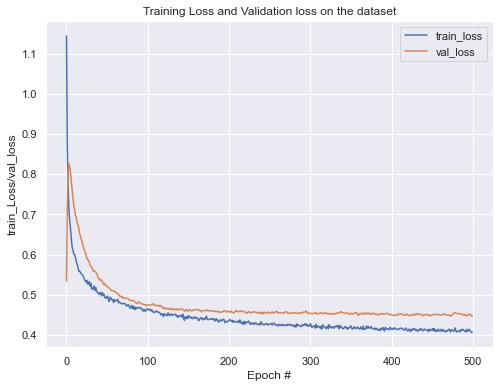

Accuracy on training set :  0.8186221743810549
Recall on training set :  0.7228202368137783
Precision on training set :  0.8941411451398136
F1 on training set :  0.799404761904762


In [264]:
get_history_plot(500)
get_training_metrics(model13, X_train, y_train)

* Our accuracy and loss statistics on the training and validation data are not better as a result of the oversampling. However, our RECALL has improved significantly.
* I'm going to break with my rule of not looking at the test data for a moment. I want to see if this increase in recall has translated to the test data 

In [265]:
get_metrics_score(model13,X_train,X_test,y_train,y_test,threshold=0.5)

Accuracy on training set :  0.8186221743810549
Accuracy on test set :  0.8336666666666667
Recall on training set :  0.7228202368137783
Recall on test set :  0.5417348608837971
Precision on training set :  0.8941411451398136
Precision on test set :  0.6018181818181818
F1 on training set :  0.799404761904762
F1 on test set :  0.570198105081826


* It appears that, when we train a model on upsampled data, the test recall slightly improves.
* Let's see the ROC curve and test the metrics at the optimum threshold

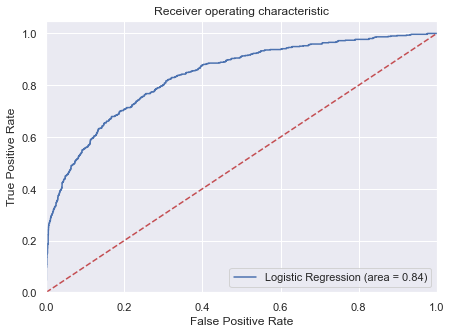

The optimal threshold is: 0.29212227


In [266]:
make_ROC(model13)

In [267]:
optimal = get_optimal(model16)
get_metrics_score(model16,X_train,X_test,y_train,y_test,threshold=optimal)

Accuracy on training set :  0.8314495873699318
Accuracy on test set :  0.7776666666666666
Recall on training set :  0.8661643344097596
Recall on test set :  0.7397708674304418
Precision on training set :  0.8099312195940278
Precision on test set :  0.4708333333333333
F1 on training set :  0.837104464672735
F1 on test set :  0.5754296626352642


* The area under the ROC curve is the same as before.
* The recall on the test data is about the same as when we used the optimum threshold on the initial model, i.e. it has not significantly improved.

### Model 14 - Change activation function
We haven't yet looked at changing activation functions, let's try that now.
**NOTE** I also tried tanh but that made no improvement, below is elu... which also makes no improvement.

In [268]:
model14 = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='elu', input_shape=(X_train.shape[1],), kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')
  ])

# Defining the optimizer. 
optimizer = tf.keras.optimizers.Adadelta(0.05)  

# Compile the model
model14.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [269]:
EPOCHS = 500 # define epochs
history = model14.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2) # fit model

Epoch 1/500
279/279 - 0s - loss: 1.1594 - accuracy: 0.4799 - val_loss: 0.7333 - val_accuracy: 0.5395
Epoch 2/500
279/279 - 0s - loss: 0.9090 - accuracy: 0.5585 - val_loss: 0.6425 - val_accuracy: 0.6049
Epoch 3/500
279/279 - 0s - loss: 0.7953 - accuracy: 0.6112 - val_loss: 0.5983 - val_accuracy: 0.6466
Epoch 4/500
279/279 - 0s - loss: 0.7229 - accuracy: 0.6402 - val_loss: 0.5756 - val_accuracy: 0.6861
Epoch 5/500
279/279 - 0s - loss: 0.6714 - accuracy: 0.6769 - val_loss: 0.5616 - val_accuracy: 0.7188
Epoch 6/500
279/279 - 0s - loss: 0.6550 - accuracy: 0.6907 - val_loss: 0.5481 - val_accuracy: 0.7395
Epoch 7/500
279/279 - 0s - loss: 0.6468 - accuracy: 0.6949 - val_loss: 0.5434 - val_accuracy: 0.7484
Epoch 8/500
279/279 - 0s - loss: 0.6248 - accuracy: 0.7039 - val_loss: 0.5322 - val_accuracy: 0.7520
Epoch 9/500
279/279 - 0s - loss: 0.6087 - accuracy: 0.7125 - val_loss: 0.5246 - val_accuracy: 0.7583
Epoch 10/500
279/279 - 0s - loss: 0.6057 - accuracy: 0.7179 - val_loss: 0.5181 - val_accura

Epoch 82/500
279/279 - 0s - loss: 0.4596 - accuracy: 0.7914 - val_loss: 0.4472 - val_accuracy: 0.7910
Epoch 83/500
279/279 - 0s - loss: 0.4591 - accuracy: 0.7864 - val_loss: 0.4490 - val_accuracy: 0.7897
Epoch 84/500
279/279 - 0s - loss: 0.4571 - accuracy: 0.7912 - val_loss: 0.4490 - val_accuracy: 0.7901
Epoch 85/500
279/279 - 0s - loss: 0.4568 - accuracy: 0.7902 - val_loss: 0.4494 - val_accuracy: 0.7892
Epoch 86/500
279/279 - 0s - loss: 0.4575 - accuracy: 0.7903 - val_loss: 0.4475 - val_accuracy: 0.7906
Epoch 87/500
279/279 - 0s - loss: 0.4588 - accuracy: 0.7838 - val_loss: 0.4479 - val_accuracy: 0.7906
Epoch 88/500
279/279 - 0s - loss: 0.4561 - accuracy: 0.7902 - val_loss: 0.4466 - val_accuracy: 0.7910
Epoch 89/500
279/279 - 0s - loss: 0.4574 - accuracy: 0.7902 - val_loss: 0.4468 - val_accuracy: 0.7915
Epoch 90/500
279/279 - 0s - loss: 0.4571 - accuracy: 0.7862 - val_loss: 0.4478 - val_accuracy: 0.7910
Epoch 91/500
279/279 - 0s - loss: 0.4524 - accuracy: 0.7926 - val_loss: 0.4476 - v

Epoch 162/500
279/279 - 0s - loss: 0.4349 - accuracy: 0.8023 - val_loss: 0.4390 - val_accuracy: 0.7991
Epoch 163/500
279/279 - 0s - loss: 0.4385 - accuracy: 0.8001 - val_loss: 0.4376 - val_accuracy: 0.8009
Epoch 164/500
279/279 - 0s - loss: 0.4369 - accuracy: 0.8001 - val_loss: 0.4366 - val_accuracy: 0.8009
Epoch 165/500
279/279 - 0s - loss: 0.4394 - accuracy: 0.8002 - val_loss: 0.4376 - val_accuracy: 0.8004
Epoch 166/500
279/279 - 0s - loss: 0.4369 - accuracy: 0.8049 - val_loss: 0.4368 - val_accuracy: 0.7996
Epoch 167/500
279/279 - 0s - loss: 0.4358 - accuracy: 0.8029 - val_loss: 0.4380 - val_accuracy: 0.7987
Epoch 168/500
279/279 - 0s - loss: 0.4283 - accuracy: 0.8041 - val_loss: 0.4369 - val_accuracy: 0.7982
Epoch 169/500
279/279 - 0s - loss: 0.4321 - accuracy: 0.8038 - val_loss: 0.4372 - val_accuracy: 0.7987
Epoch 170/500
279/279 - 0s - loss: 0.4380 - accuracy: 0.8012 - val_loss: 0.4380 - val_accuracy: 0.7987
Epoch 171/500
279/279 - 0s - loss: 0.4338 - accuracy: 0.8006 - val_loss: 

Epoch 242/500
279/279 - 0s - loss: 0.4272 - accuracy: 0.8081 - val_loss: 0.4349 - val_accuracy: 0.8018
Epoch 243/500
279/279 - 0s - loss: 0.4267 - accuracy: 0.8096 - val_loss: 0.4344 - val_accuracy: 0.8022
Epoch 244/500
279/279 - 0s - loss: 0.4267 - accuracy: 0.8037 - val_loss: 0.4336 - val_accuracy: 0.8027
Epoch 245/500
279/279 - 0s - loss: 0.4273 - accuracy: 0.8067 - val_loss: 0.4353 - val_accuracy: 0.8013
Epoch 246/500
279/279 - 0s - loss: 0.4244 - accuracy: 0.8120 - val_loss: 0.4361 - val_accuracy: 0.8013
Epoch 247/500
279/279 - 0s - loss: 0.4257 - accuracy: 0.8076 - val_loss: 0.4370 - val_accuracy: 0.8004
Epoch 248/500
279/279 - 0s - loss: 0.4272 - accuracy: 0.8047 - val_loss: 0.4349 - val_accuracy: 0.8022
Epoch 249/500
279/279 - 0s - loss: 0.4255 - accuracy: 0.8069 - val_loss: 0.4354 - val_accuracy: 0.8013
Epoch 250/500
279/279 - 0s - loss: 0.4248 - accuracy: 0.8117 - val_loss: 0.4346 - val_accuracy: 0.8018
Epoch 251/500
279/279 - 0s - loss: 0.4271 - accuracy: 0.8050 - val_loss: 

Epoch 322/500
279/279 - 0s - loss: 0.4226 - accuracy: 0.8121 - val_loss: 0.4366 - val_accuracy: 0.8031
Epoch 323/500
279/279 - 0s - loss: 0.4142 - accuracy: 0.8161 - val_loss: 0.4364 - val_accuracy: 0.8031
Epoch 324/500
279/279 - 0s - loss: 0.4206 - accuracy: 0.8112 - val_loss: 0.4376 - val_accuracy: 0.8036
Epoch 325/500
279/279 - 0s - loss: 0.4141 - accuracy: 0.8131 - val_loss: 0.4360 - val_accuracy: 0.8036
Epoch 326/500
279/279 - 0s - loss: 0.4221 - accuracy: 0.8094 - val_loss: 0.4351 - val_accuracy: 0.8036
Epoch 327/500
279/279 - 0s - loss: 0.4181 - accuracy: 0.8114 - val_loss: 0.4349 - val_accuracy: 0.8036
Epoch 328/500
279/279 - 0s - loss: 0.4169 - accuracy: 0.8105 - val_loss: 0.4356 - val_accuracy: 0.8036
Epoch 329/500
279/279 - 0s - loss: 0.4198 - accuracy: 0.8158 - val_loss: 0.4356 - val_accuracy: 0.8036
Epoch 330/500
279/279 - 0s - loss: 0.4219 - accuracy: 0.8111 - val_loss: 0.4376 - val_accuracy: 0.8022
Epoch 331/500
279/279 - 0s - loss: 0.4217 - accuracy: 0.8113 - val_loss: 

Epoch 402/500
279/279 - 0s - loss: 0.4142 - accuracy: 0.8151 - val_loss: 0.4343 - val_accuracy: 0.8049
Epoch 403/500
279/279 - 0s - loss: 0.4145 - accuracy: 0.8109 - val_loss: 0.4354 - val_accuracy: 0.8049
Epoch 404/500
279/279 - 0s - loss: 0.4170 - accuracy: 0.8158 - val_loss: 0.4370 - val_accuracy: 0.8040
Epoch 405/500
279/279 - 0s - loss: 0.4111 - accuracy: 0.8159 - val_loss: 0.4343 - val_accuracy: 0.8054
Epoch 406/500
279/279 - 0s - loss: 0.4149 - accuracy: 0.8115 - val_loss: 0.4357 - val_accuracy: 0.8049
Epoch 407/500
279/279 - 0s - loss: 0.4168 - accuracy: 0.8137 - val_loss: 0.4343 - val_accuracy: 0.8045
Epoch 408/500
279/279 - 0s - loss: 0.4138 - accuracy: 0.8154 - val_loss: 0.4347 - val_accuracy: 0.8049
Epoch 409/500
279/279 - 0s - loss: 0.4135 - accuracy: 0.8140 - val_loss: 0.4356 - val_accuracy: 0.8045
Epoch 410/500
279/279 - 0s - loss: 0.4133 - accuracy: 0.8149 - val_loss: 0.4360 - val_accuracy: 0.8045
Epoch 411/500
279/279 - 0s - loss: 0.4136 - accuracy: 0.8122 - val_loss: 

Epoch 482/500
279/279 - 0s - loss: 0.4116 - accuracy: 0.8157 - val_loss: 0.4359 - val_accuracy: 0.8027
Epoch 483/500
279/279 - 0s - loss: 0.4120 - accuracy: 0.8148 - val_loss: 0.4363 - val_accuracy: 0.8022
Epoch 484/500
279/279 - 0s - loss: 0.4100 - accuracy: 0.8178 - val_loss: 0.4354 - val_accuracy: 0.8027
Epoch 485/500
279/279 - 0s - loss: 0.4110 - accuracy: 0.8136 - val_loss: 0.4350 - val_accuracy: 0.8036
Epoch 486/500
279/279 - 0s - loss: 0.4093 - accuracy: 0.8166 - val_loss: 0.4349 - val_accuracy: 0.8040
Epoch 487/500
279/279 - 0s - loss: 0.4079 - accuracy: 0.8126 - val_loss: 0.4345 - val_accuracy: 0.8045
Epoch 488/500
279/279 - 0s - loss: 0.4086 - accuracy: 0.8166 - val_loss: 0.4351 - val_accuracy: 0.8036
Epoch 489/500
279/279 - 0s - loss: 0.4093 - accuracy: 0.8163 - val_loss: 0.4342 - val_accuracy: 0.8054
Epoch 490/500
279/279 - 0s - loss: 0.4088 - accuracy: 0.8171 - val_loss: 0.4342 - val_accuracy: 0.8049
Epoch 491/500
279/279 - 0s - loss: 0.4105 - accuracy: 0.8194 - val_loss: 

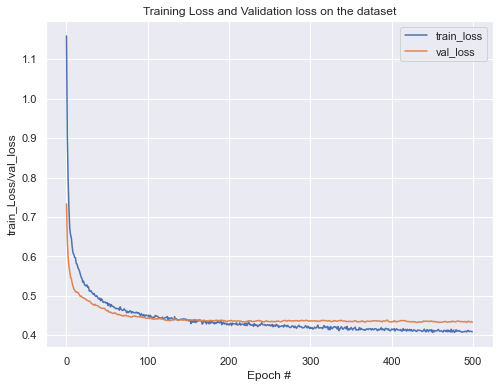

Accuracy on training set :  0.8226587728740581
Recall on training set :  0.7526013634732688
Precision on training set :  0.8752347172960567
F1 on training set :  0.8092987363750361


In [270]:
get_history_plot(500)
get_training_metrics(model14, X_train, y_train)

* The performance of this model is about the same as the previous one with the ReLU activation.


### A slight change of tactic.
* So far, we haven't managed to fit the training data very well. Our closest model was Model 3, but this overfit the training data and we had poor results on out validation data. We then attempted to add dropout in Model 4, after we did this, we have failed to reach an accuracy on the training data above about 86%.
* Perhaps we have added too much dropout to our model? We will try to reduce the amount of dropout that we have in the model, or reduce the number of nodes, we can find a model that fits the training data well, and also generalizes to the validation data.

### Model 15 Decrease dropout and number of nodes
**NOTE** I tried multiple permutations below, changing activation, number of nodes, amount of dropout etc. NOTHING seems to work. Below is a single model but many were attempted.

In [271]:
model15 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

# Defining the optimizer.
optimizer = tf.keras.optimizers.Adadelta(0.01)  

# Compile the model
model15.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [272]:
EPOCHS = 300 # define epochs
history = model15.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2,) # fit model

Epoch 1/300
279/279 - 1s - loss: 0.7067 - accuracy: 0.4390 - val_loss: 0.6980 - val_accuracy: 0.4744
Epoch 2/300
279/279 - 0s - loss: 0.6869 - accuracy: 0.5379 - val_loss: 0.7028 - val_accuracy: 0.4498
Epoch 3/300
279/279 - 0s - loss: 0.6718 - accuracy: 0.6242 - val_loss: 0.7102 - val_accuracy: 0.4511
Epoch 4/300
279/279 - 0s - loss: 0.6523 - accuracy: 0.6767 - val_loss: 0.7225 - val_accuracy: 0.4413
Epoch 5/300
279/279 - 0s - loss: 0.6296 - accuracy: 0.7044 - val_loss: 0.7374 - val_accuracy: 0.4426
Epoch 6/300
279/279 - 0s - loss: 0.6068 - accuracy: 0.7207 - val_loss: 0.7497 - val_accuracy: 0.4534
Epoch 7/300
279/279 - 0s - loss: 0.5859 - accuracy: 0.7325 - val_loss: 0.7530 - val_accuracy: 0.4798
Epoch 8/300
279/279 - 0s - loss: 0.5676 - accuracy: 0.7406 - val_loss: 0.7470 - val_accuracy: 0.5220
Epoch 9/300
279/279 - 0s - loss: 0.5537 - accuracy: 0.7466 - val_loss: 0.7350 - val_accuracy: 0.5628
Epoch 10/300
279/279 - 0s - loss: 0.5409 - accuracy: 0.7588 - val_loss: 0.7192 - val_accura

Epoch 82/300
279/279 - 0s - loss: 0.4137 - accuracy: 0.8152 - val_loss: 0.4372 - val_accuracy: 0.8036
Epoch 83/300
279/279 - 0s - loss: 0.4126 - accuracy: 0.8144 - val_loss: 0.4354 - val_accuracy: 0.8045
Epoch 84/300
279/279 - 0s - loss: 0.4138 - accuracy: 0.8172 - val_loss: 0.4346 - val_accuracy: 0.8040
Epoch 85/300
279/279 - 0s - loss: 0.4112 - accuracy: 0.8174 - val_loss: 0.4366 - val_accuracy: 0.8031
Epoch 86/300
279/279 - 0s - loss: 0.4113 - accuracy: 0.8160 - val_loss: 0.4282 - val_accuracy: 0.8072
Epoch 87/300
279/279 - 0s - loss: 0.4114 - accuracy: 0.8176 - val_loss: 0.4297 - val_accuracy: 0.8067
Epoch 88/300
279/279 - 0s - loss: 0.4108 - accuracy: 0.8148 - val_loss: 0.4275 - val_accuracy: 0.8072
Epoch 89/300
279/279 - 0s - loss: 0.4089 - accuracy: 0.8203 - val_loss: 0.4311 - val_accuracy: 0.8058
Epoch 90/300
279/279 - 0s - loss: 0.4103 - accuracy: 0.8185 - val_loss: 0.4312 - val_accuracy: 0.8058
Epoch 91/300
279/279 - 0s - loss: 0.4072 - accuracy: 0.8176 - val_loss: 0.4336 - v

Epoch 162/300
279/279 - 0s - loss: 0.3934 - accuracy: 0.8251 - val_loss: 0.4286 - val_accuracy: 0.8085
Epoch 163/300
279/279 - 0s - loss: 0.3911 - accuracy: 0.8271 - val_loss: 0.4308 - val_accuracy: 0.8081
Epoch 164/300
279/279 - 0s - loss: 0.3922 - accuracy: 0.8242 - val_loss: 0.4280 - val_accuracy: 0.8090
Epoch 165/300
279/279 - 0s - loss: 0.3911 - accuracy: 0.8260 - val_loss: 0.4213 - val_accuracy: 0.8143
Epoch 166/300
279/279 - 0s - loss: 0.3908 - accuracy: 0.8289 - val_loss: 0.4251 - val_accuracy: 0.8108
Epoch 167/300
279/279 - 0s - loss: 0.3899 - accuracy: 0.8279 - val_loss: 0.4295 - val_accuracy: 0.8090
Epoch 168/300
279/279 - 0s - loss: 0.3887 - accuracy: 0.8297 - val_loss: 0.4278 - val_accuracy: 0.8103
Epoch 169/300
279/279 - 0s - loss: 0.3903 - accuracy: 0.8282 - val_loss: 0.4210 - val_accuracy: 0.8143
Epoch 170/300
279/279 - 0s - loss: 0.3903 - accuracy: 0.8271 - val_loss: 0.4269 - val_accuracy: 0.8108
Epoch 171/300
279/279 - 0s - loss: 0.3889 - accuracy: 0.8269 - val_loss: 

Epoch 242/300
279/279 - 0s - loss: 0.3848 - accuracy: 0.8308 - val_loss: 0.4212 - val_accuracy: 0.8121
Epoch 243/300
279/279 - 0s - loss: 0.3840 - accuracy: 0.8274 - val_loss: 0.4232 - val_accuracy: 0.8117
Epoch 244/300
279/279 - 0s - loss: 0.3822 - accuracy: 0.8309 - val_loss: 0.4262 - val_accuracy: 0.8108
Epoch 245/300
279/279 - 0s - loss: 0.3818 - accuracy: 0.8312 - val_loss: 0.4232 - val_accuracy: 0.8121
Epoch 246/300
279/279 - 0s - loss: 0.3826 - accuracy: 0.8298 - val_loss: 0.4220 - val_accuracy: 0.8121
Epoch 247/300
279/279 - 0s - loss: 0.3833 - accuracy: 0.8315 - val_loss: 0.4225 - val_accuracy: 0.8121
Epoch 248/300
279/279 - 0s - loss: 0.3835 - accuracy: 0.8307 - val_loss: 0.4209 - val_accuracy: 0.8130
Epoch 249/300
279/279 - 0s - loss: 0.3828 - accuracy: 0.8290 - val_loss: 0.4207 - val_accuracy: 0.8130
Epoch 250/300
279/279 - 0s - loss: 0.3821 - accuracy: 0.8301 - val_loss: 0.4200 - val_accuracy: 0.8148
Epoch 251/300
279/279 - 0s - loss: 0.3826 - accuracy: 0.8310 - val_loss: 

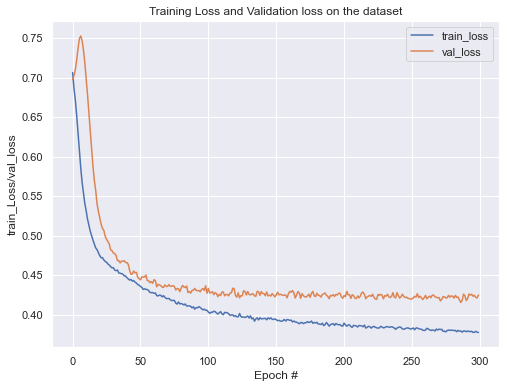

Accuracy on training set :  0.829476139217797
Recall on training set :  0.7642626480086114
Precision on training set :  0.8788941613369095
F1 on training set :  0.8175798867671049


In [273]:
get_history_plot(300)
get_training_metrics(model15, X_train, y_train)

* Above is just one output, I tried many different permutations of nodes and dropout. If I decrease the number of nodes the accuracy of both the training and validation goes down.
* I can get a good fit to the training data if I increase nodes, but this starts to overfit. If I increase the dropout, the overfitting stops, but I the accuracy caps around 80-85%.

### A complete reset.
Let's take a look at our very first model again, this time trained on the up sampled data.

### Model 16 - Our Initial model achitecture, trained on up sampled data

In [274]:
model16 = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

# Defining the optimizer. We will use SGD, which is a Gradient Decent optimizer
optimizer = tf.keras.optimizers.SGD(0.01)  

# Compile the model
model16.compile(loss='binary_crossentropy', # Using this loss function as we are doing classification with 2 classes 
                optimizer=optimizer,
                metrics=['accuracy'])

In [275]:
EPOCHS = 100 # define epochs
history = model16.fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=2,) # fit model

Epoch 1/100
279/279 - 0s - loss: 0.6118 - accuracy: 0.6555 - val_loss: 0.7947 - val_accuracy: 0.3861
Epoch 2/100
279/279 - 0s - loss: 0.5412 - accuracy: 0.7298 - val_loss: 0.6633 - val_accuracy: 0.6538
Epoch 3/100
279/279 - 0s - loss: 0.5148 - accuracy: 0.7569 - val_loss: 0.5972 - val_accuracy: 0.7265
Epoch 4/100
279/279 - 0s - loss: 0.5019 - accuracy: 0.7645 - val_loss: 0.5699 - val_accuracy: 0.7435
Epoch 5/100
279/279 - 0s - loss: 0.4931 - accuracy: 0.7690 - val_loss: 0.5534 - val_accuracy: 0.7529
Epoch 6/100
279/279 - 0s - loss: 0.4856 - accuracy: 0.7732 - val_loss: 0.5455 - val_accuracy: 0.7543
Epoch 7/100
279/279 - 0s - loss: 0.4789 - accuracy: 0.7789 - val_loss: 0.5157 - val_accuracy: 0.7695
Epoch 8/100
279/279 - 0s - loss: 0.4732 - accuracy: 0.7828 - val_loss: 0.5174 - val_accuracy: 0.7614
Epoch 9/100
279/279 - 0s - loss: 0.4677 - accuracy: 0.7858 - val_loss: 0.5187 - val_accuracy: 0.7520
Epoch 10/100
279/279 - 0s - loss: 0.4627 - accuracy: 0.7868 - val_loss: 0.4831 - val_accura

Epoch 82/100
279/279 - 0s - loss: 0.3756 - accuracy: 0.8331 - val_loss: 0.4359 - val_accuracy: 0.8022
Epoch 83/100
279/279 - 0s - loss: 0.3755 - accuracy: 0.8320 - val_loss: 0.4338 - val_accuracy: 0.7982
Epoch 84/100
279/279 - 0s - loss: 0.3755 - accuracy: 0.8309 - val_loss: 0.4458 - val_accuracy: 0.7960
Epoch 85/100
279/279 - 0s - loss: 0.3753 - accuracy: 0.8316 - val_loss: 0.4629 - val_accuracy: 0.7825
Epoch 86/100
279/279 - 0s - loss: 0.3751 - accuracy: 0.8336 - val_loss: 0.3914 - val_accuracy: 0.8251
Epoch 87/100
279/279 - 0s - loss: 0.3751 - accuracy: 0.8329 - val_loss: 0.4143 - val_accuracy: 0.8143
Epoch 88/100
279/279 - 0s - loss: 0.3751 - accuracy: 0.8346 - val_loss: 0.4528 - val_accuracy: 0.7892
Epoch 89/100
279/279 - 0s - loss: 0.3745 - accuracy: 0.8327 - val_loss: 0.4050 - val_accuracy: 0.8251
Epoch 90/100
279/279 - 0s - loss: 0.3744 - accuracy: 0.8335 - val_loss: 0.4387 - val_accuracy: 0.7996
Epoch 91/100
279/279 - 0s - loss: 0.3744 - accuracy: 0.8316 - val_loss: 0.3789 - v

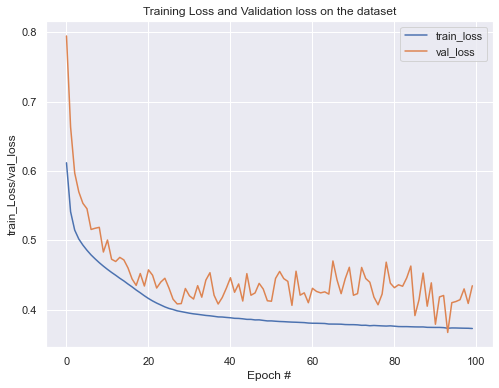

Accuracy on training set :  0.8288482238966631
Recall on training set :  0.7631862217438106
Precision on training set :  0.8785625774473358
F1 on training set :  0.8168202764976958


In [276]:
get_history_plot(100)
get_training_metrics(model16, X_train, y_train)

* The accuracy is lower than our initial model (trained on the intial data), however the RECALL is much better.
* It appears that the model is overfitting here.
* Let's break the rule (again) and take a look at the test data. This will let us know if the up sampling has actually worked.

In [277]:
get_metrics_score(model16,X_train,X_test,y_train,y_test,threshold=0.5)

Accuracy on training set :  0.8288482238966631
Accuracy on test set :  0.828
Recall on training set :  0.7631862217438106
Recall on test set :  0.6039279869067103
Precision on training set :  0.8785625774473358
Precision on test set :  0.5738724727838258
F1 on training set :  0.8168202764976958
F1 on test set :  0.5885167464114832


* The recall on our test data actually has improved as a result of training the ANN on the up sampled data.
* While we are "cheating" by looking at the test data. Let's also look at the ROC curve

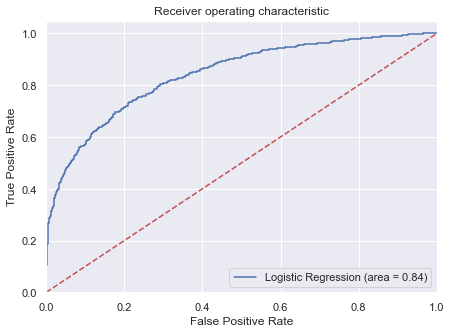

The optimal threshold is: 0.32339007


In [278]:
make_ROC(model16)

* The area under the curve is about the same ~0.85.
* If we evaluate the model using the optimum threshold we get:

In [279]:
optimal = get_optimal(model16)
get_metrics_score(model16,X_train,X_test,y_train,y_test,threshold=optimal)

Accuracy on training set :  0.8314495873699318
Accuracy on test set :  0.776
Recall on training set :  0.8679583781844277
Recall on test set :  0.7332242225859247
Precision on training set :  0.8088948336398596
Precision on test set :  0.46812957157784746
F1 on training set :  0.8373864128083081
F1 on test set :  0.5714285714285714


* Our test recall at optimum threshold has not significantly improved due to the upsampling of the data.
* Furthermore, this model appears overfit as the test metrics are significantly lower than the training metrics.

# Keras Tuner
In the above section, we attempted to improve the model results by trial and error. Nothing appeared to improve the validation accuracy. In this section we will attempt to hypertune the parameters using Keras Tuner. Our first attempt will be to tune the number of nodes in a single hidden layer. We will also tune the learning rate.

### Model 17 - hypertune a single hidden layer model

In [280]:
# Here is the function that will build our model
def model_builder(hp):
    model = tf.keras.Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  

    # Defining the optimizer. We will use SGD, which is a Gradient Decent optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate) 
    
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [281]:
# We will attempt hyperband tuning. We will attempt to maximize the validation accuracy
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt',
                     overwrite=True,
                     seed=1)

In [282]:
# We now add a call back to stop the training early if nothing is improving
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [283]:
# Run the hyperband search
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 02s]
val_accuracy: 0.781614363193512

Best val_accuracy So Far: 0.7852017879486084
Total elapsed time: 00h 00m 34s
INFO:tensorflow:Oracle triggered exit


* The search says that it was able to get a validation accuracy high score of ~0.8 (everytime I run this note book it will be different, however, it appears that this model is no better than the ones that came before).
* Let's now build a model using the best parameters.

In [284]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.0001.



In [285]:
model17 = tuner.hypermodel.build(best_hps)
model17.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 480)               5760      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 481       
Total params: 6,241
Trainable params: 6,241
Non-trainable params: 0
_________________________________________________________________


* Everytime I run the code the number of optimal nodes is different. Given the random nature of the inital weights this makes some sense. However, over 100 epochs, one would hope that things would stabilize and the the starting weights wouldn't make such a difference.
* The next bit of code will try to find the optimum epoch to stop the training using the model above.

In [286]:
history = model17.fit(X_train, y_train, epochs=500, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/500
279/279 [==============================] - 0s 880us/step - loss: 0.6682 - accuracy: 0.6347 - val_loss: 0.7291 - val_accuracy: 0.3422
Epoch 2/500
279/279 [==============================] - 0s 648us/step - loss: 0.6641 - accuracy: 0.6424 - val_loss: 0.7318 - val_accuracy: 0.3354
Epoch 3/500
279/279 [==============================] - 0s 648us/step - loss: 0.6603 - accuracy: 0.6484 - val_loss: 0.7344 - val_accuracy: 0.3269
Epoch 4/500
279/279 [==============================] - 0s 639us/step - loss: 0.6566 - accuracy: 0.6526 - val_loss: 0.7367 - val_accuracy: 0.3238
Epoch 5/500
279/279 [==============================] - 0s 641us/step - loss: 0.6531 - accuracy: 0.6573 - val_loss: 0.7389 - val_accuracy: 0.3184
Epoch 6/500
279/279 [==============================] - 0s 641us/step - loss: 0.6497 - accuracy: 0.6617 - val_loss: 0.7408 - val_accuracy: 0.3135
Epoch 7/500
279/279 [==============================] - 0s 655us/step - loss: 0.6464 - accuracy: 0.6664 - val_loss: 0.7426 - val_ac

279/279 [==============================] - 0s 635us/step - loss: 0.5613 - accuracy: 0.7432 - val_loss: 0.7116 - val_accuracy: 0.5507
Epoch 58/500
279/279 [==============================] - 0s 646us/step - loss: 0.5603 - accuracy: 0.7438 - val_loss: 0.7101 - val_accuracy: 0.5543
Epoch 59/500
279/279 [==============================] - 0s 635us/step - loss: 0.5594 - accuracy: 0.7456 - val_loss: 0.7085 - val_accuracy: 0.5578
Epoch 60/500
279/279 [==============================] - 0s 637us/step - loss: 0.5584 - accuracy: 0.7467 - val_loss: 0.7070 - val_accuracy: 0.5614
Epoch 61/500
279/279 [==============================] - 0s 641us/step - loss: 0.5575 - accuracy: 0.7473 - val_loss: 0.7055 - val_accuracy: 0.5659
Epoch 62/500
279/279 [==============================] - 0s 644us/step - loss: 0.5565 - accuracy: 0.7478 - val_loss: 0.7039 - val_accuracy: 0.5677
Epoch 63/500
279/279 [==============================] - 0s 637us/step - loss: 0.5556 - accuracy: 0.7485 - val_loss: 0.7024 - val_accuracy

279/279 [==============================] - 0s 650us/step - loss: 0.5218 - accuracy: 0.7632 - val_loss: 0.6318 - val_accuracy: 0.6682
Epoch 114/500
279/279 [==============================] - 0s 650us/step - loss: 0.5213 - accuracy: 0.7630 - val_loss: 0.6306 - val_accuracy: 0.6700
Epoch 115/500
279/279 [==============================] - 0s 646us/step - loss: 0.5208 - accuracy: 0.7631 - val_loss: 0.6294 - val_accuracy: 0.6713
Epoch 116/500
279/279 [==============================] - 0s 652us/step - loss: 0.5203 - accuracy: 0.7634 - val_loss: 0.6282 - val_accuracy: 0.6726
Epoch 117/500
279/279 [==============================] - 0s 648us/step - loss: 0.5198 - accuracy: 0.7635 - val_loss: 0.6270 - val_accuracy: 0.6735
Epoch 118/500
279/279 [==============================] - 0s 650us/step - loss: 0.5194 - accuracy: 0.7637 - val_loss: 0.6259 - val_accuracy: 0.6740
Epoch 119/500
279/279 [==============================] - 0s 652us/step - loss: 0.5189 - accuracy: 0.7643 - val_loss: 0.6247 - val_ac

Epoch 169/500
279/279 [==============================] - 0s 644us/step - loss: 0.5009 - accuracy: 0.7704 - val_loss: 0.5779 - val_accuracy: 0.7072
Epoch 170/500
279/279 [==============================] - 0s 644us/step - loss: 0.5007 - accuracy: 0.7708 - val_loss: 0.5772 - val_accuracy: 0.7081
Epoch 171/500
279/279 [==============================] - 0s 643us/step - loss: 0.5004 - accuracy: 0.7709 - val_loss: 0.5764 - val_accuracy: 0.7081
Epoch 172/500
279/279 [==============================] - 0s 643us/step - loss: 0.5001 - accuracy: 0.7712 - val_loss: 0.5757 - val_accuracy: 0.7085
Epoch 173/500
279/279 [==============================] - 0s 641us/step - loss: 0.4999 - accuracy: 0.7714 - val_loss: 0.5750 - val_accuracy: 0.7090
Epoch 174/500
279/279 [==============================] - 0s 644us/step - loss: 0.4996 - accuracy: 0.7714 - val_loss: 0.5742 - val_accuracy: 0.7094
Epoch 175/500
279/279 [==============================] - 0s 662us/step - loss: 0.4993 - accuracy: 0.7714 - val_loss: 0

Epoch 225/500
279/279 [==============================] - 0s 659us/step - loss: 0.4887 - accuracy: 0.7746 - val_loss: 0.5444 - val_accuracy: 0.7341
Epoch 226/500
279/279 [==============================] - 0s 664us/step - loss: 0.4885 - accuracy: 0.7745 - val_loss: 0.5439 - val_accuracy: 0.7354
Epoch 227/500
279/279 [==============================] - 0s 657us/step - loss: 0.4884 - accuracy: 0.7744 - val_loss: 0.5435 - val_accuracy: 0.7354
Epoch 228/500
279/279 [==============================] - 0s 668us/step - loss: 0.4882 - accuracy: 0.7746 - val_loss: 0.5430 - val_accuracy: 0.7359
Epoch 229/500
279/279 [==============================] - 0s 657us/step - loss: 0.4880 - accuracy: 0.7746 - val_loss: 0.5426 - val_accuracy: 0.7363
Epoch 230/500
279/279 [==============================] - 0s 666us/step - loss: 0.4879 - accuracy: 0.7743 - val_loss: 0.5421 - val_accuracy: 0.7368
Epoch 231/500
279/279 [==============================] - 0s 659us/step - loss: 0.4877 - accuracy: 0.7745 - val_loss: 0

Epoch 281/500
279/279 [==============================] - 0s 657us/step - loss: 0.4807 - accuracy: 0.7762 - val_loss: 0.5229 - val_accuracy: 0.7480
Epoch 282/500
279/279 [==============================] - 0s 655us/step - loss: 0.4806 - accuracy: 0.7763 - val_loss: 0.5226 - val_accuracy: 0.7480
Epoch 283/500
279/279 [==============================] - 0s 653us/step - loss: 0.4804 - accuracy: 0.7763 - val_loss: 0.5223 - val_accuracy: 0.7484
Epoch 284/500
279/279 [==============================] - 0s 666us/step - loss: 0.4803 - accuracy: 0.7765 - val_loss: 0.5220 - val_accuracy: 0.7493
Epoch 285/500
279/279 [==============================] - 0s 657us/step - loss: 0.4802 - accuracy: 0.7766 - val_loss: 0.5217 - val_accuracy: 0.7493
Epoch 286/500
279/279 [==============================] - 0s 662us/step - loss: 0.4801 - accuracy: 0.7766 - val_loss: 0.5214 - val_accuracy: 0.7493
Epoch 287/500
279/279 [==============================] - 0s 652us/step - loss: 0.4800 - accuracy: 0.7767 - val_loss: 0

Epoch 337/500
279/279 [==============================] - 0s 659us/step - loss: 0.4748 - accuracy: 0.7795 - val_loss: 0.5085 - val_accuracy: 0.7565
Epoch 338/500
279/279 [==============================] - 0s 659us/step - loss: 0.4747 - accuracy: 0.7797 - val_loss: 0.5083 - val_accuracy: 0.7565
Epoch 339/500
279/279 [==============================] - 0s 648us/step - loss: 0.4746 - accuracy: 0.7799 - val_loss: 0.5080 - val_accuracy: 0.7570
Epoch 340/500
279/279 [==============================] - 0s 659us/step - loss: 0.4745 - accuracy: 0.7799 - val_loss: 0.5078 - val_accuracy: 0.7570
Epoch 341/500
279/279 [==============================] - 0s 653us/step - loss: 0.4744 - accuracy: 0.7798 - val_loss: 0.5076 - val_accuracy: 0.7570
Epoch 342/500
279/279 [==============================] - 0s 657us/step - loss: 0.4743 - accuracy: 0.7798 - val_loss: 0.5074 - val_accuracy: 0.7570
Epoch 343/500
279/279 [==============================] - 0s 657us/step - loss: 0.4742 - accuracy: 0.7798 - val_loss: 0

Epoch 393/500
279/279 [==============================] - 0s 641us/step - loss: 0.4700 - accuracy: 0.7822 - val_loss: 0.4982 - val_accuracy: 0.7614
Epoch 394/500
279/279 [==============================] - 0s 644us/step - loss: 0.4699 - accuracy: 0.7824 - val_loss: 0.4980 - val_accuracy: 0.7614
Epoch 395/500
279/279 [==============================] - 0s 643us/step - loss: 0.4698 - accuracy: 0.7825 - val_loss: 0.4979 - val_accuracy: 0.7614
Epoch 396/500
279/279 [==============================] - 0s 648us/step - loss: 0.4697 - accuracy: 0.7825 - val_loss: 0.4977 - val_accuracy: 0.7614
Epoch 397/500
279/279 [==============================] - 0s 643us/step - loss: 0.4697 - accuracy: 0.7826 - val_loss: 0.4976 - val_accuracy: 0.7614
Epoch 398/500
279/279 [==============================] - 0s 646us/step - loss: 0.4696 - accuracy: 0.7826 - val_loss: 0.4974 - val_accuracy: 0.7614
Epoch 399/500
279/279 [==============================] - 0s 650us/step - loss: 0.4695 - accuracy: 0.7827 - val_loss: 0

Epoch 449/500
279/279 [==============================] - 0s 659us/step - loss: 0.4658 - accuracy: 0.7839 - val_loss: 0.4905 - val_accuracy: 0.7628
Epoch 450/500
279/279 [==============================] - 0s 707us/step - loss: 0.4657 - accuracy: 0.7839 - val_loss: 0.4903 - val_accuracy: 0.7628
Epoch 451/500
279/279 [==============================] - 0s 695us/step - loss: 0.4657 - accuracy: 0.7839 - val_loss: 0.4902 - val_accuracy: 0.7628
Epoch 452/500
279/279 [==============================] - 0s 659us/step - loss: 0.4656 - accuracy: 0.7840 - val_loss: 0.4901 - val_accuracy: 0.7628
Epoch 453/500
279/279 [==============================] - 0s 650us/step - loss: 0.4655 - accuracy: 0.7841 - val_loss: 0.4900 - val_accuracy: 0.7628
Epoch 454/500
279/279 [==============================] - 0s 648us/step - loss: 0.4655 - accuracy: 0.7840 - val_loss: 0.4898 - val_accuracy: 0.7628
Epoch 455/500
279/279 [==============================] - 0s 680us/step - loss: 0.4654 - accuracy: 0.7840 - val_loss: 0

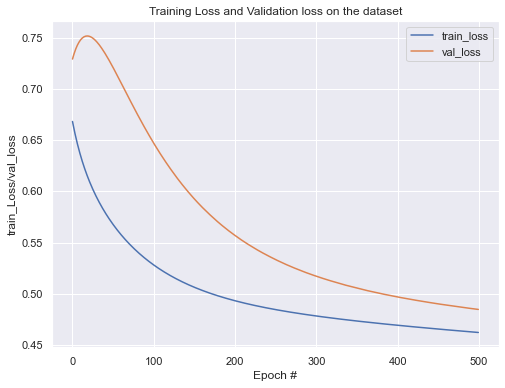

Accuracy on training set :  0.7822030857552924
Recall on training set :  0.6942949407965554
Precision on training set :  0.8424031345232913
F1 on training set :  0.7612116443745083


In [287]:
get_history_plot(500)
get_training_metrics(model17, X_train, y_train)

* When we train the model using the best hyperparameters, we fail to get the validation accuracy high score that was found during the search, which is disapointing. It appears that each time the model is fit a different result comes out.
* It does appear that we could train this model for longer and get a better result... but given that there is so much separation between the training and validation scores AND the best validaiton score found in the hyperband search did not indicate that we would see much improvement, we will just move on to a more complex model.
* Let's again use the ROC_AUC to see if our model is better than our intial model

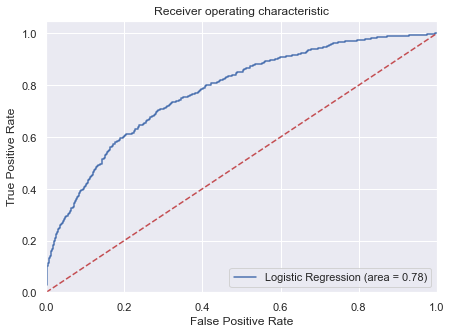

The optimal threshold is: 0.3246652


In [288]:
make_ROC(model17)

* The area under the curve is lower than our initial model. So the hyperparameter tuning has not improved the model.

### Model 18 - Hypertune both the number of layers and the number of neurons
In our previous model, there was only a single layer. In this attempt to hypertune the parameter, we will run a loop which *should* hypertune both the number of neurons AND the number of layers.

In [289]:
# Here we build the model
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(11, input_shape=(X_train.shape[1],))) #our first layer is just a passthrough to set input shape
    for i in range(hp.Int("num_layers", 2, 20)):
        model.add(
            tf.keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=tf.keras.optimizers.SGD(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [290]:
# Here we create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
    seed=1
)

In [291]:
# Now we make to tuner do its search
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

Trial 5 Complete [00h 00m 14s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.8464125692844391
Total elapsed time: 00h 01m 16s
INFO:tensorflow:Oracle triggered exit


In [292]:
# We will now build a model from the best hyperparameters found during the search.
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model18 = tuner.hypermodel.build(best_hps)

In [293]:
model18.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 11)                132       
_________________________________________________________________
dense_1 (Dense)              (None, 416)               4992      
_________________________________________________________________
dense_2 (Dense)              (None, 192)               80064     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               49408     
_________________________________________________________________
dense_4 (Dense)              (None, 320)               82240     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                10272     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1

* We can see that the output when we attempt to tune both the layers and number of neurons is a complex ANN. We can also see that the BEST validation accuracy is NOT better than we saw in our very first model
* It is highly likely that this model is overfitting the training data. Let's plot the history to make sure.

In [294]:
history = model18.fit(X_train, y_train, epochs=100, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
279/279 [==============================] - 1s 2ms/step - loss: 0.6682 - accuracy: 0.6250 - val_loss: 0.9281 - val_accuracy: 0.0000e+00
Epoch 2/100
279/279 [==============================] - 1s 2ms/step - loss: 0.6582 - accuracy: 0.6250 - val_loss: 0.9710 - val_accuracy: 0.0000e+00
Epoch 3/100
279/279 [==============================] - 1s 2ms/step - loss: 0.6499 - accuracy: 0.6250 - val_loss: 0.9483 - val_accuracy: 0.0000e+00
Epoch 4/100
279/279 [==============================] - 1s 2ms/step - loss: 0.6110 - accuracy: 0.6250 - val_loss: 0.9084 - val_accuracy: 0.0000e+00
Epoch 5/100
279/279 [==============================] - 1s 2ms/step - loss: 0.5439 - accuracy: 0.7237 - val_loss: 0.7403 - val_accuracy: 0.7561
Epoch 6/100
279/279 [==============================] - 1s 2ms/step - loss: 0.5130 - accuracy: 0.7674 - val_loss: 0.6453 - val_accuracy: 0.7942
Epoch 7/100
279/279 [==============================] - 1s 2ms/step - loss: 0.4914 - accuracy: 0.7788 - val_loss: 0.6051 - val_

Epoch 58/100
279/279 [==============================] - 1s 2ms/step - loss: 0.2567 - accuracy: 0.8970 - val_loss: 0.2808 - val_accuracy: 0.8969
Epoch 59/100
279/279 [==============================] - 1s 2ms/step - loss: 0.2540 - accuracy: 0.8926 - val_loss: 0.2099 - val_accuracy: 0.9224
Epoch 60/100
279/279 [==============================] - 1s 2ms/step - loss: 0.2422 - accuracy: 0.9001 - val_loss: 0.0931 - val_accuracy: 0.9677
Epoch 61/100
279/279 [==============================] - 1s 2ms/step - loss: 0.2468 - accuracy: 0.8994 - val_loss: 0.4522 - val_accuracy: 0.8197
Epoch 62/100
279/279 [==============================] - 1s 2ms/step - loss: 0.2395 - accuracy: 0.9029 - val_loss: 0.3810 - val_accuracy: 0.8543
Epoch 63/100
279/279 [==============================] - 1s 2ms/step - loss: 0.2397 - accuracy: 0.9012 - val_loss: 0.6486 - val_accuracy: 0.7484
Epoch 64/100
279/279 [==============================] - 1s 2ms/step - loss: 0.2338 - accuracy: 0.9031 - val_loss: 0.1783 - val_accuracy:

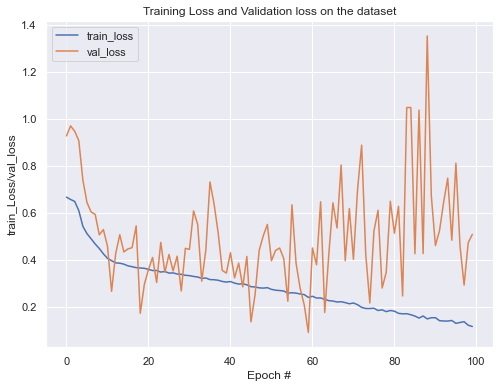

Accuracy on training set :  0.942859705776821
Recall on training set :  0.9113742375313958
Precision on training set :  0.9726210989852575
F1 on training set :  0.9410021302213577


In [295]:
get_history_plot(100)
get_training_metrics(model18, X_train, y_train)

* We can see see here that the metrics on the training data are very good - the best that we have seen so far... however the model is completley overfit to the training data, it's performance on the validation data is pretty random.
* In the output above it gives us the "best" epoch to stop the training. Again this is somewhat random, the model overfits and the validation accuracy occilates, and that occilation gets worse as the number of epochs increases.
* What this means is, even if we could pick an epoch to stop the training that worked well for the validation data, it would be a complete fluke. This model would not generalize well onto the test data. The model is simply too complex.
* There are some things that we can keep "constant" by parameterizing a random seed in the tuner, however we can't specify a random seed for the ANN, for this reason the outputs are different each time we run the note book. So the "best" epoch is different each time.
* The model above appears to give the best results when the epoch is *around* 20, hopefully if we restirct the amount of training the model can undergo, we can mitigate the amount of overfitting that occurs.

### Model 19 - Model 18 but terminate learning after 20 epochs

In [296]:
model19 = tuner.hypermodel.build(best_hps)
history = model19.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
279/279 [==============================] - 1s 2ms/step - loss: 0.6704 - accuracy: 0.6250 - val_loss: 0.9287 - val_accuracy: 0.0000e+00
Epoch 2/20
279/279 [==============================] - 1s 2ms/step - loss: 0.6601 - accuracy: 0.6250 - val_loss: 0.9514 - val_accuracy: 0.0000e+00
Epoch 3/20
279/279 [==============================] - 1s 2ms/step - loss: 0.6518 - accuracy: 0.6250 - val_loss: 0.9343 - val_accuracy: 0.0000e+00
Epoch 4/20
279/279 [==============================] - 1s 2ms/step - loss: 0.6166 - accuracy: 0.6285 - val_loss: 0.8432 - val_accuracy: 0.2659
Epoch 5/20
279/279 [==============================] - 1s 2ms/step - loss: 0.5392 - accuracy: 0.7567 - val_loss: 0.6551 - val_accuracy: 0.7318
Epoch 6/20
279/279 [==============================] - 1s 2ms/step - loss: 0.4756 - accuracy: 0.7889 - val_loss: 0.8955 - val_accuracy: 0.5013
Epoch 7/20
279/279 [==============================] - 1s 2ms/step - loss: 0.4330 - accuracy: 0.8069 - val_loss: 0.5130 - val_accuracy: 0

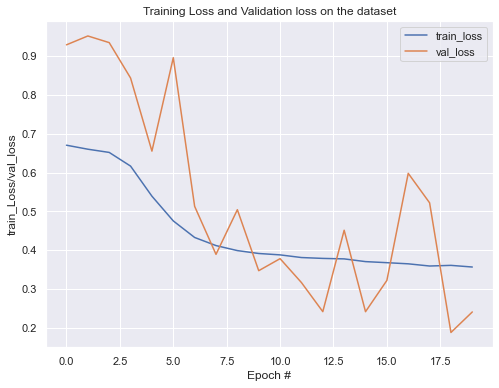

Accuracy on training set :  0.942859705776821
Recall on training set :  0.9113742375313958
Precision on training set :  0.9726210989852575
F1 on training set :  0.9410021302213577


In [297]:
get_history_plot(20)
get_training_metrics(model18, X_train, y_train)

* We can see that the validation data is already starting to fluctuate. Hopefully we have stopped the training before the model has had a chance to *really* overfit the data.
* Let's evaluate the model and see:

In [298]:
get_metrics_score(model19,X_train,X_test,y_train,y_test,threshold=0.5)

Accuracy on training set :  0.8487621097954791
Accuracy on test set :  0.7613333333333333
Recall on training set :  0.8907427341227125
Recall on test set :  0.7168576104746317
Precision on training set :  0.8217477656405164
Precision on test set :  0.44648318042813456
F1 on training set :  0.8548553719008264
F1 on test set :  0.550251256281407


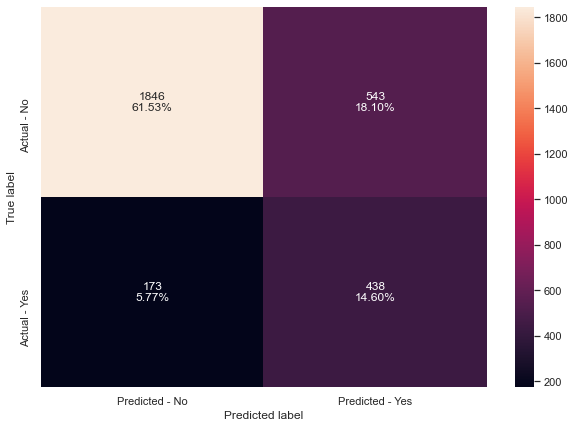

In [299]:
make_confusion_matrix(model19,X_test,y_test,threshold=0.5)

* There is a large amount of variance in the recall, precision and F1 scores between training and test data.
* This tells us that this model is overfit to the training data - which makes sense given that the model is very complex with no regularization.

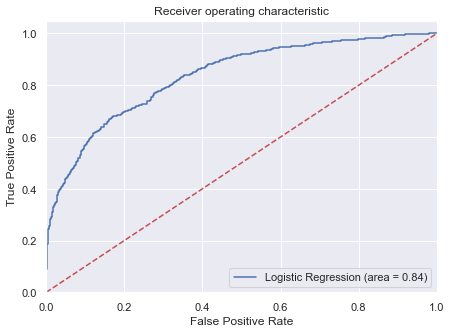

The optimal threshold is: 0.59074914


In [300]:
make_ROC(model19)

* The ROC curve has not changed, despite the complexity of the model, we have failed to improve upon our original model

In [301]:
optimal = get_optimal(model19)
get_metrics_score(model19,X_train,X_test,y_train,y_test,threshold=optimal)

Accuracy on training set :  0.8513634732687477
Accuracy on test set :  0.7983333333333333
Recall on training set :  0.8545030498744169
Recall on test set :  0.6808510638297872
Precision on training set :  0.849170975218399
Precision on test set :  0.5036319612590799
F1 on training set :  0.8518286685147098
F1 on test set :  0.5789839944328462


* Changing the threshold from the default to the optimal actually reduces the test recall (at least during the run of the notebook that I see while writing this).

# Model Performance Evaluation
*Evaluate the model on different performance metrics and comment on the performance and scope of improvement*

It is hard to say what our best model is. Each time the notebook runs the results are slightly different. However, we saw that we were not able to increase the area under the ROC curve from our initial model with any of the models attempted so far.  

When we change the model architecture:
* More complex models fit the training data but quickly start to overfit and the metrics of the validation data drop.
* Attempts to regularize the model by adding dropout do solve the overfitting problem, but the validation accuracy appears to be limited to ~85%, which we saw in our original model.
* Changing model optimization, or kernal initialization has limited effect. When I initialized the weights as all ones (not documented above) the model failed to train at all - so I can make the model worse... but nothing tried above has made the model better.

When we change the training data by using SMOTE to balance the classes:
* This did not change the model accuracy, it appear to improve the recall of the training data, but this improvement was not translated to the test data.
* We saw that the ROC curves (made using the test data) had the same area under the curve both before and after the upsampling. So the conclusion is that the change in input data did not improve the trained output models.

Keras Tuner:
* It's clear that my understanding of this tool is very basic. I was able to make a tuned model with a single layer (which was not complex enough) and a tuned model with multiple layers (which hopelessly overfit the training data).
* We did not see any improvement in model metrics using the tuned data.

### Best Model Performance
The best model, at least in this run of the notebook, was model 11. This model was a slight improvement from the initial model in terms of metrics. Also this model was less overfit that previous (or future) models. This was shown in the history curve, the training and validation loss were very close, all the way up to 500 epochs of training.  
We will repeat the metrics for the test data for this model 11 below: 

In [310]:
optimal = get_optimal(model11)
pred_test = model11.predict(X_test)

for i in range(len(y_test)):
    if pred_test[i]>optimal:
        pred_test[i]=1 
    else:
        pred_test[i]=0

print("Accuracy on test set : ",accuracy_score(pred_test,y_test))
print("Recall on test set : ",recall_score(y_test,pred_test))
print("Precision on test set : ",precision_score(y_test,pred_test))
print("F1 on test set : ",f1_score(y_test,pred_test))

Accuracy on test set :  0.7333333333333333
Recall on test set :  0.7970540098199672
Precision on test set :  0.41874462596732587
F1 on test set :  0.5490417136414882


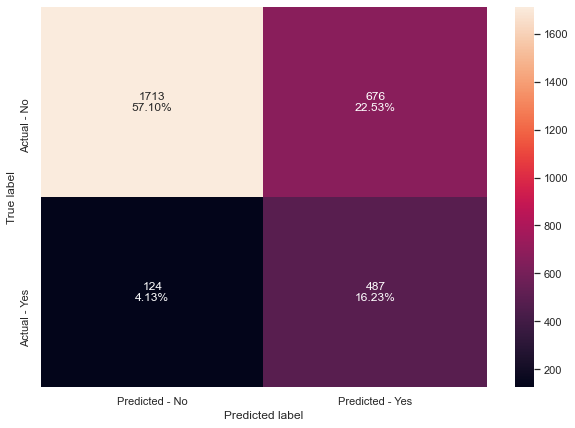

In [311]:
make_confusion_matrix(model11,X_test,y_test,threshold=optimal)

* Above are the metrics of our final model at the optimum threshold as deturmined by the ROC curve.
* We can see that the accuracy is below 80%, this is because, at this threshold, the model is predicting more customers as exiters. This increases the recall but drops the accuracy and precision of the model.
* In this case, the trade off is ok, it is not as costly to predict a customer will exit when they will not (a false positive) as it is to miss a customer who will exit (a false negative).
* our intial model had a recall of ~70%, we have managed to increase the recall to ~80% by updating the model and using an optimum threshold.

# Conclusion and key takeaways
*Final conclusion about the analysis*

Our objective was: “Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.”  

We have created a neural network to do just that. Our model is more focused on predicting if a customer will leave, as the bank was concerned about “Churn” i.e. customers leaving. So our final model is the one with the best recall, even if the accuracy and precision are not as high as other models. The reason I believe a high accuracy was hard to obtain is given below:

We observed in our EDA that there were areas of our variable’s distribution’s where there was a high purity of Class 1 (exited) customers. For example, all customers with a credit score less than 400 exited the bank. All customers with 4 products exited the bank. These types of customers should be very easy for our model to capture… unfortunately these types of clusters are the exception and not the norm. Customers with a credit score < 400 make up 0.19% of total customers. Customers with 4 products make up only 0.6% of the data.  

For the remaining 99.21% of the data, there was an almost completely heterogenous mix of Class 1 (exited customers) and Class 0 (retained customers). There were some patches where the mix became a little purer, for example the age range between 40-70 was a little richer in Class 1 customers, but for the most part, Class 1 and Class 0 customers were fairly evenly spread throughout each variable.  

I believe that this is the reason why our neural network models had such trouble increasing accuracy much beyond 80-85%. The target class was so heterogeneously mixed through each variable that the decision boundaries between the two classes were very complex. If we attempted to fit these complex decision boundaries in the training data, they were not general enough to fit the validation or test data. Despite our best efforts (and there was a lot of effort put into this!), the accuracy of our models was limited by the heterogeneity of the data.